Bug analysis for github issue [Bug fix for first_metric_only on earlystopping](https://github.com/microsoft/LightGBM/pull/2127) .
1. Order of metric list is not fixed even if it is defined by list. So explicitly indicating which metric is used on early stopping.  


2. Due to introducing eval_train_metric feature, if the feature is enabled, then the first metric became train score of the metrics, so it does not appropriate for early stopping. So until the specified metrics of validation is coming, skipping to check early stopping in the loop.  


* reference: Parameters
https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters


In [24]:
import sys
sys.path = ["/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/"] + sys.path

In [25]:
import traceback
import lightgbm as lgb
import numpy as np
import numpy.random as rd
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._search import ParameterGrid

from IPython.display import display
from itertools import permutations


# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

In [26]:
lgb.__file__

'/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/__init__.py'

In [27]:
def test_train(train_func, param_func, dataset):
    num_boost_round = 300
    pg = param_func()
    for p in pg:
        print("="*100, flush=True)
        print("="*100, flush=True)
        print(p, flush=True)
        try:
            df_ret = train_func(dataset, metric_list=p["metric_list"], 
                                 eval_train_metric=p["eval_train_metric"], 
                                 first_metric_only=p["first_metric_only"],
                                 num_boost_round=num_boost_round)
            draw_metric_graph(df_ret)
            if df_ret.shape[0]==num_boost_round:
                raise Exception("early_stopping was not applied.")
        except Exception as e:
            traceback.print_exc()

        print("", flush=True)
        # break
        

def draw_metric_graph(df_ret):
    valid_cols = [c for c in df_ret.columns if c.find("valid")>=0 and c.find("mean")>=0]
    train_cols = [c for c in df_ret.columns if c.find("train")>=0 and c.find("mean")>=0]
    
    if len(valid_cols)==0:
        valid_cols = [c for c in df_ret.columns if c.find("mean")>=0]

    n_graph = len(valid_cols) + len(train_cols)
    n_cols = 3
    n_rows = n_graph//n_cols+1

    plt.figure(figsize=(25, 5*n_rows))
    cnt = 1
    for c in valid_cols:
        plt.subplot(n_rows, n_cols, cnt); cnt += 1
        df_ret[c].plot()
        plt.title(f"{c}")
        # plt.show()


    for c in train_cols:
        plt.subplot(n_rows, n_cols, cnt); cnt += 1
        df_ret[c].plot()
        plt.title(f"{c}")
        #plt.show()
    plt.tight_layout()
    plt.show()
    

In [28]:
   import itertools
decreasing_generator = itertools.count(0, -1)    
def decreasing_metric(preds, train_data):
    return ('decreasing_metric', next(decreasing_generator), False)

def constant_metric(preds, train_data):
    return ('constant_metric', 0.0, False)

def custom_evals(preds, train_data): 
    return [decreasing_metric(preds, train_data), constant_metric(preds, train_data)]

# Binary Classification

## Load data

In [29]:
def load_data_for_classification():
    rd.seed(123)
    print('Loading data...')
    # load or create your dataset
    df_train = pd.read_csv('../dataset/binary.train', header=None, sep='\t')
    df_test = pd.read_csv('../dataset/binary.test', header=None, sep='\t')

    print("df_train.shape:{}, df_test.shape:{}".format(df_train.shape, df_test.shape))
    display(df_train.head())

    y_train = df_train[0]
    y_test = df_test[0]
    X_train = df_train.drop(0, axis=1)
    X_test = df_test.drop(0, axis=1)
    return X_train, y_train, X_test, y_test

def classification_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500):
    X_train, y_train, X_test, y_test = dataset

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': metric_list,
        #'metric': ['auc', 'binary_logloss',],
        'num_leaves': 8,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    res_dict = {}
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)

    # Fitting
    ret = lgb.cv(params=params, # feval=custom_evals,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 50,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   # return_boosters=True
                   )

    #print(f"best_iteration : {model.best_iteration}")
    df_ret = pd.DataFrame(ret)
    display(df_ret.tail())
    return df_ret

def classification_params():
    two_metrics = list(permutations(['binary_logloss','auc', ], 2))
    three_metrics = list(permutations(['binary_logloss','auc', "xentropy"], 3))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" :[
                          None, "", "None", "binary_logloss", "auc", "xentropy",  # just one metric
                          
                       ] + two_metrics + three_metrics , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg


Loading data...
df_train.shape:(7000, 29), df_test.shape:(500, 29)


0      1      2      3      4      5      6      7      8      9   ...  \
0   1  0.869 -0.635  0.226  0.327 -0.690  0.754 -0.249 -1.092  0.000  ...   
1   1  0.908  0.329  0.359  1.498 -0.313  1.096 -0.558 -1.588  2.173  ...   
2   1  0.799  1.471 -1.636  0.454  0.426  1.105  1.282  1.382  0.000  ...   
3   0  1.344 -0.877  0.936  1.992  0.882  1.786 -1.647 -0.942  0.000  ...   
4   1  1.105  0.321  1.522  0.883 -1.205  0.681 -1.070 -0.922  0.000  ...   

      19     20     21     22     23     24     25     26     27     28  
0 -0.010 -0.046  3.102  1.354  0.980  0.978  0.920  0.722  0.989  0.877  
1 -1.139 -0.001  0.000  0.302  0.833  0.986  0.978  0.780  0.992  0.798  
2  1.129  0.900  0.000  0.910  1.108  0.986  0.951  0.803  0.866  0.780  
3 -0.678 -1.360  0.000  0.947  1.029  0.999  0.728  0.869  1.027  0.958  
4 -0.374  0.113  0.000  0.756  1.361  0.987  0.838  1.133  0.872  0.808  

[5 rows x 29 columns]

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-27-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-29-5317d5b173be>", line 55, in classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623
metric_key:valid binary_logloss


train binary_logloss-mean  train binary_logloss-stdv  \
99                    0.489460                   0.002139   
100                   0.488741                   0.002174   
101                   0.488106                   0.002191   
102                   0.487379                   0.002094   
103                   0.486689                   0.002089   

     valid binary_logloss-mean  valid binary_logloss-stdv  
99                    0.567869                   0.009902  
100                   0.567898                   0.009931  
101                   0.567922                   0.009937  
102                   0.567912                   0.009919  
103                   0.567659                   0.009976

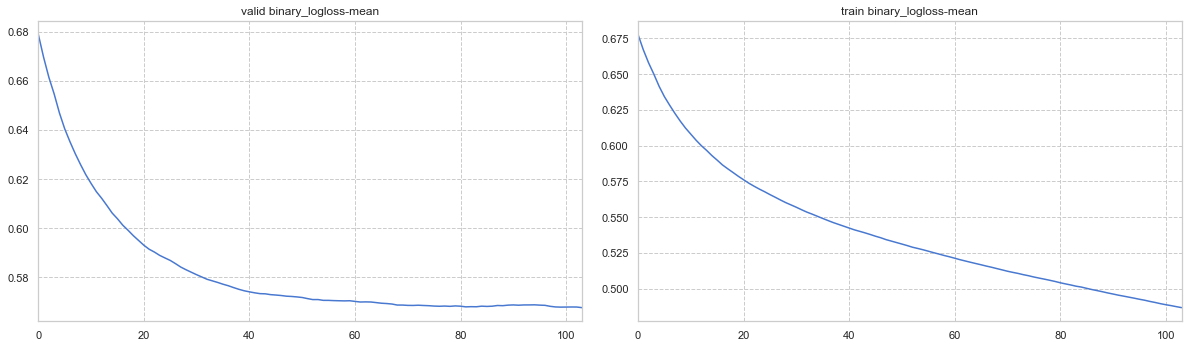


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'binary_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-27-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-29-5317d5b173be>", line 55, in classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623
metric_key:valid binary_logloss


train binary_logloss-mean  train binary_logloss-stdv  \
99                    0.489460                   0.002139   
100                   0.488741                   0.002174   
101                   0.488106                   0.002191   
102                   0.487379                   0.002094   
103                   0.486689                   0.002089   

     valid binary_logloss-mean  valid binary_logloss-stdv  
99                    0.567869                   0.009902  
100                   0.567898                   0.009931  
101                   0.567922                   0.009937  
102                   0.567912                   0.009919  
103                   0.567659                   0.009976

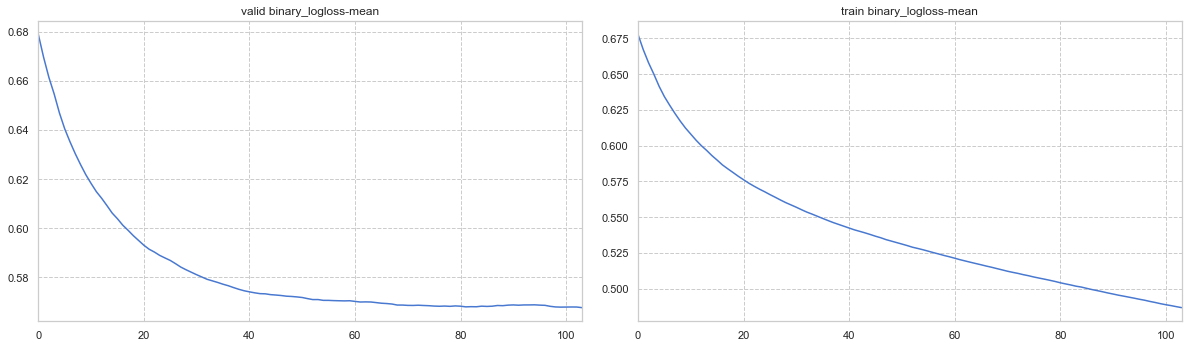


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'auc'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid auc: 0.77113 + 0.0116124
Early stopping, best iteration is:
[82]	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's valid auc: 0.774197 + 0.0137751
metric_key:valid auc


train auc-mean  train auc-stdv  valid auc-mean  valid auc-stdv
77        0.846830        0.002407        0.773952        0.014784
78        0.847386        0.002383        0.774053        0.014320
79        0.848161        0.002385        0.773936        0.014322
80        0.848802        0.002513        0.773933        0.013769
81        0.849456        0.002497        0.774197        0.013775

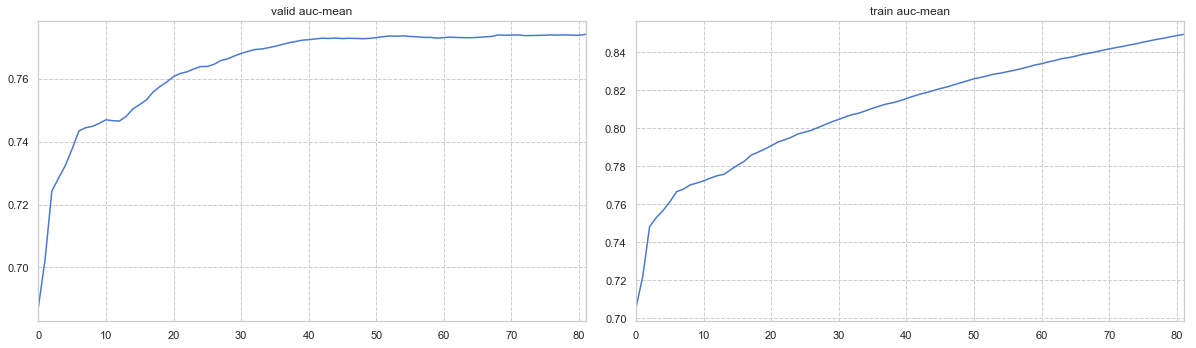


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'xentropy'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's valid xentropy: 0.572024 + 0.0108773
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's valid xentropy: 0.567869 + 0.00990152


In [ ]:
test_train(classification_train, 
           param_func=classification_params,
           dataset=load_data_for_classification())

# Multi-label classification

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
def load_data_for_multi_label_classification():
    rd.seed(123)
    print('Loading data...')
    # Loading Iris Dataset
    iris = datasets.load_iris()
    X, y = iris.data, iris.target

    # Split dataset for this demonstration.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    random_state=42)
    return X_train, y_train, X_test, y_test

def multi_label_classification_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500):
    X_train, y_train, X_test, y_test = dataset
    # one hot representation of y_train
    max_class_num = y_train.max()+1
    y_train_ohe = np.identity(max_class_num)[y_train]

    # Create LightGBM dataset for train.
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

    # LightGBM parameter
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric' :metric_list,
        # 'metric' : ["multi_logloss", "multi_error", ],
        'num_class': 3,
        'verbosity' : -1,
    }
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
    eval_train_metric=True
    # # Fitting
    ret = lgb.cv(params=params,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 30,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   # return_boosters=True
                   )
    df_ret = pd.DataFrame(ret)
    display(df_ret.tail())
    return df_ret
    
def multi_classification_params():
    two_metrics = list(permutations(["multi_logloss", "multi_error", ], 2))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" : two_metrics + [
                          None, "", "None", "multi_logloss", "multi_error",  # just one metric
                        ] , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg

Loading data...
{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('multi_logloss', 'multi_error')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_error: 0.0716168 + 0.0593762	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_error: 0.0807077 + 0.0581416	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_error: 0.072012 + 0.0454085	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_error: 0.0807077 + 0.0333468	cv_agg's valid multi_logloss: 0.370295 + 

train multi_error-mean  train multi_error-stdv  train multi_logloss-mean  \
33                0.029015                0.011382                  0.115982   
34                0.031262                0.013070                  0.112324   
35                0.029015                0.011382                  0.108726   
36                0.026793                0.008985                  0.104969   
37                0.024570                0.008450                  0.101291   

    train multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  \
33                  0.016045                0.071617                0.059376   
34                  0.015875                0.071617                0.059376   
35                  0.015537                0.071617                0.059376   
36                  0.015449                0.071617                0.059376   
37                  0.015524                0.080708                0.058142   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

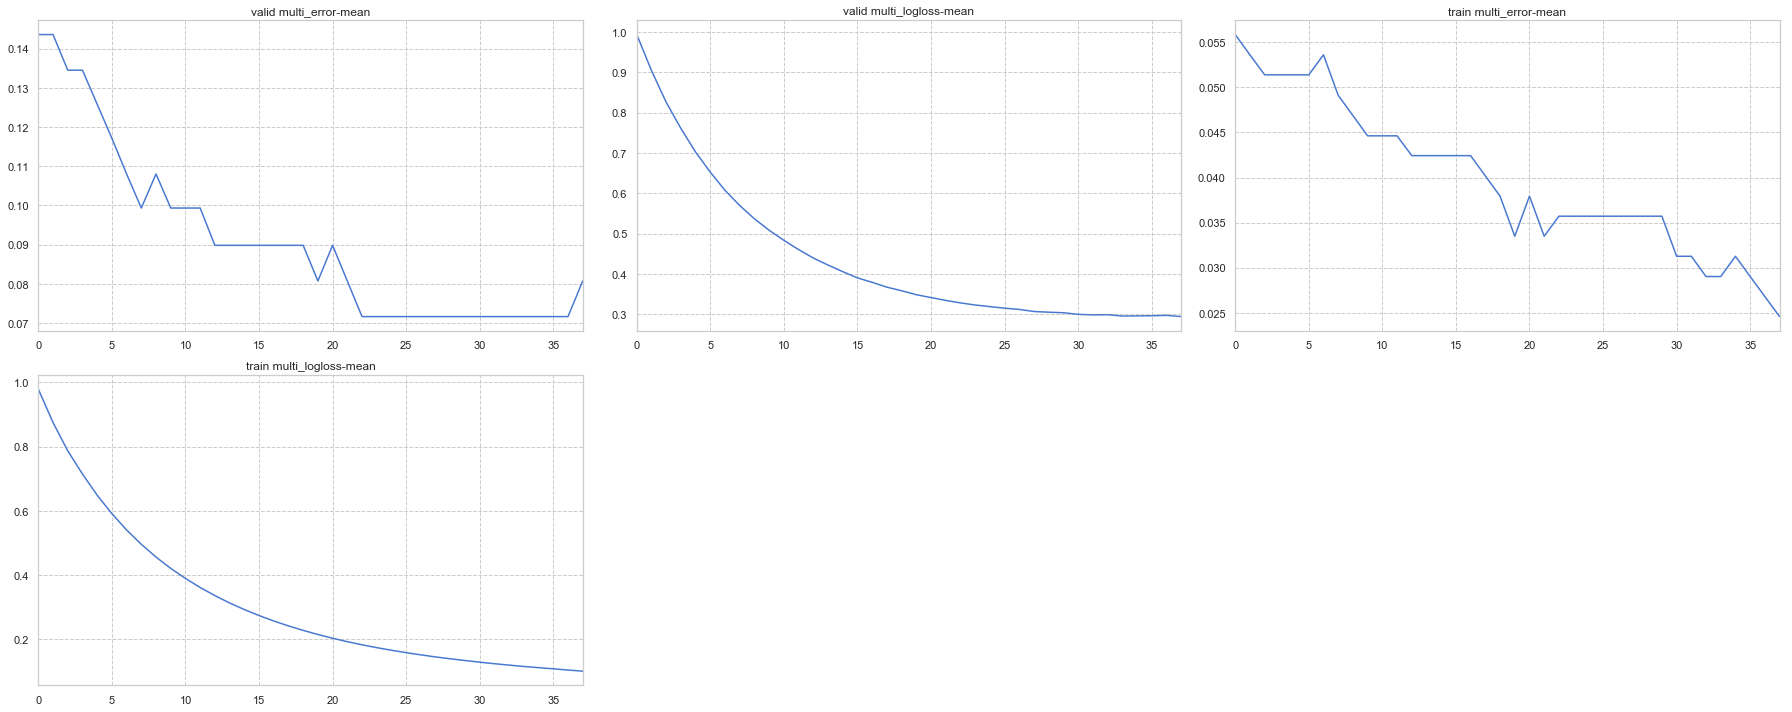


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('multi_error', 'multi_logloss')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_logloss: 0.303975 + 0.129743	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_logloss: 0.30044 + 0.185254	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.327377 + 0.237144	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.370295 + 0.277056	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early 

train multi_logloss-mean  train multi_logloss-stdv  \
18                  0.228277                  0.016910   
19                  0.215409                  0.016715   
20                  0.203825                  0.016549   
21                  0.193139                  0.016468   
22                  0.183447                  0.016354   

    train multi_error-mean  train multi_error-stdv  valid multi_logloss-mean  \
18                0.037929                0.016726                  0.358475   
19                0.033485                0.014216                  0.348635   
20                0.037929                0.016726                  0.341552   
21                0.033485                0.014216                  0.334496   
22                0.035707                0.014872                  0.328291   

    valid multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  
18                  0.100058                0.089799                0.062422  
19                  0.104418                0.080708                0.058142  
20                  0.107705                0.089799                0.062422  
21                  0.110455                0.080708                0.058142  
22                  0.114151                0.071617                0.059376

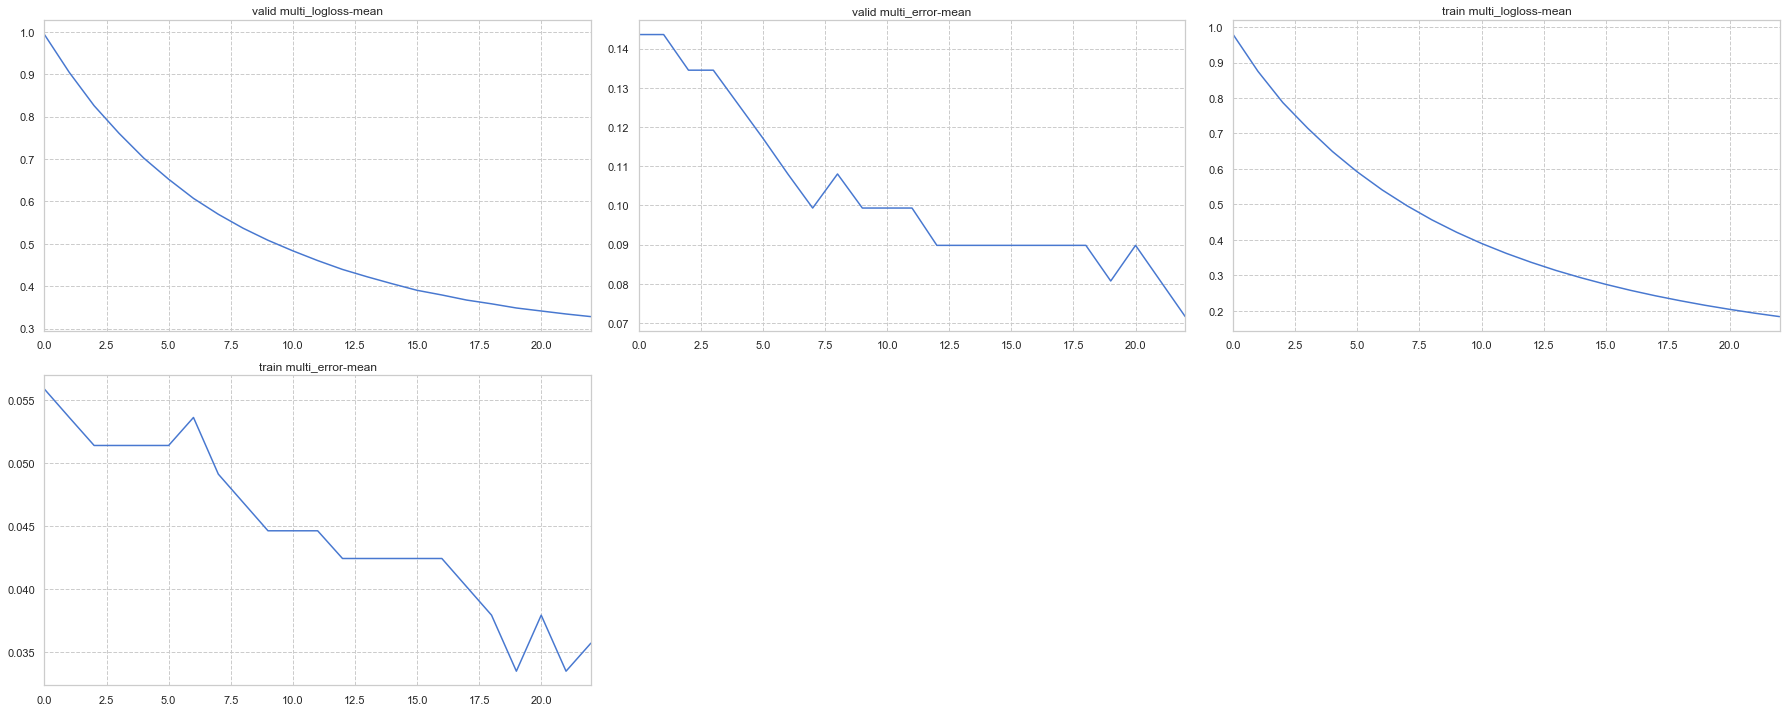


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149
metric_key:valid multi_logloss


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

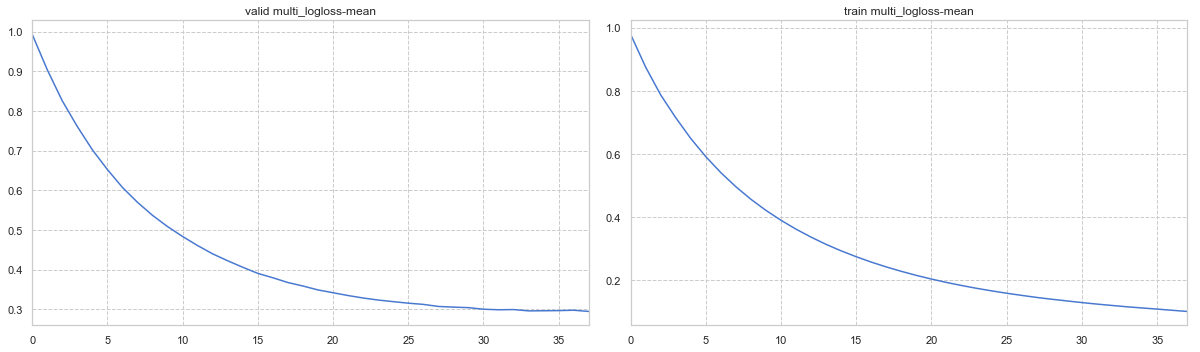


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'multi_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149
metric_key:valid multi_logloss


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

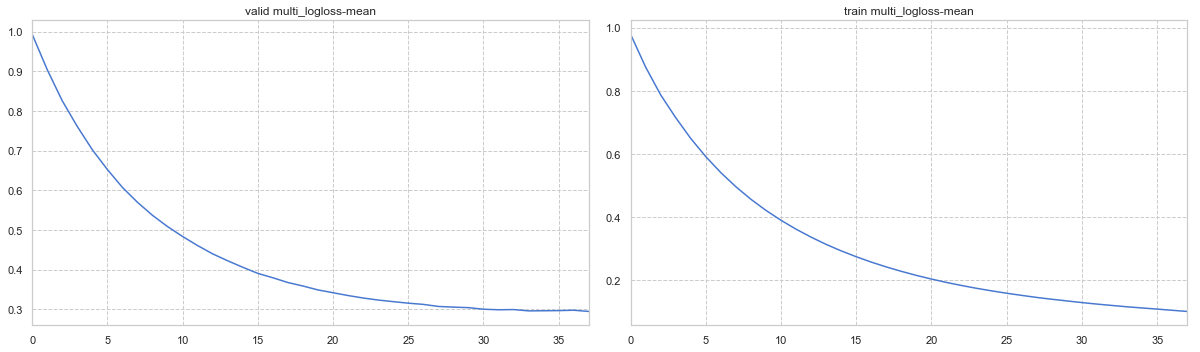


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'multi_error'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early stopping, best iteration is:
[23]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
metric_key:valid multi_error


train multi_error-mean  train multi_error-stdv  valid multi_error-mean  \
18                0.037929                0.016726                0.089799   
19                0.033485                0.014216                0.080708   
20                0.037929                0.016726                0.089799   
21                0.033485                0.014216                0.080708   
22                0.035707                0.014872                0.071617   

    valid multi_error-stdv  
18                0.062422  
19                0.058142  
20                0.062422  
21                0.058142  
22                0.059376

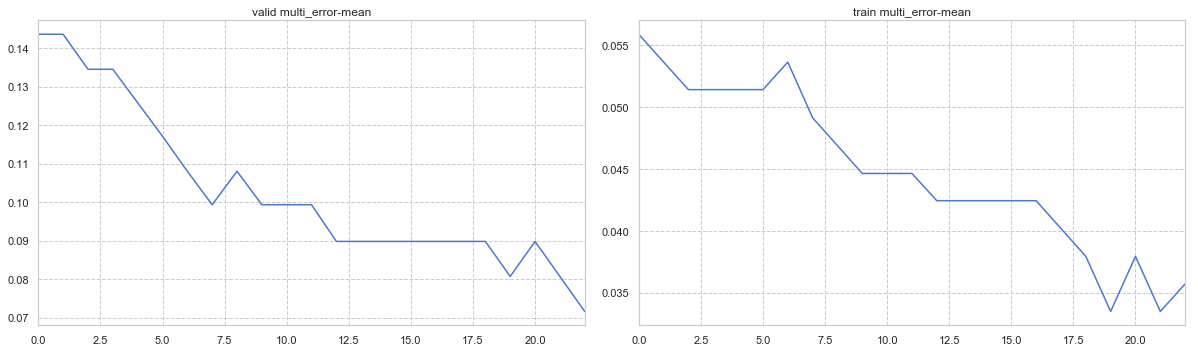


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('multi_logloss', 'multi_error')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_error: 0.0716168 + 0.0593762	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_error: 0.0807077 + 0.0581416	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_error: 0.072012 + 0.0454085	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_error: 0.0807077 + 0.0333468	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early

train multi_error-mean  train multi_error-stdv  train multi_logloss-mean  \
18                0.037929                0.016726                  0.228277   
19                0.033485                0.014216                  0.215409   
20                0.037929                0.016726                  0.203825   
21                0.033485                0.014216                  0.193139   
22                0.035707                0.014872                  0.183447   

    train multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  \
18                  0.016910                0.089799                0.062422   
19                  0.016715                0.080708                0.058142   
20                  0.016549                0.089799                0.062422   
21                  0.016468                0.080708                0.058142   
22                  0.016354                0.071617                0.059376   

    valid multi_logloss-mean  valid multi_logloss-stdv  
18                  0.358475                  0.100058  
19                  0.348635                  0.104418  
20                  0.341552                  0.107705  
21                  0.334496                  0.110455  
22                  0.328291                  0.114151

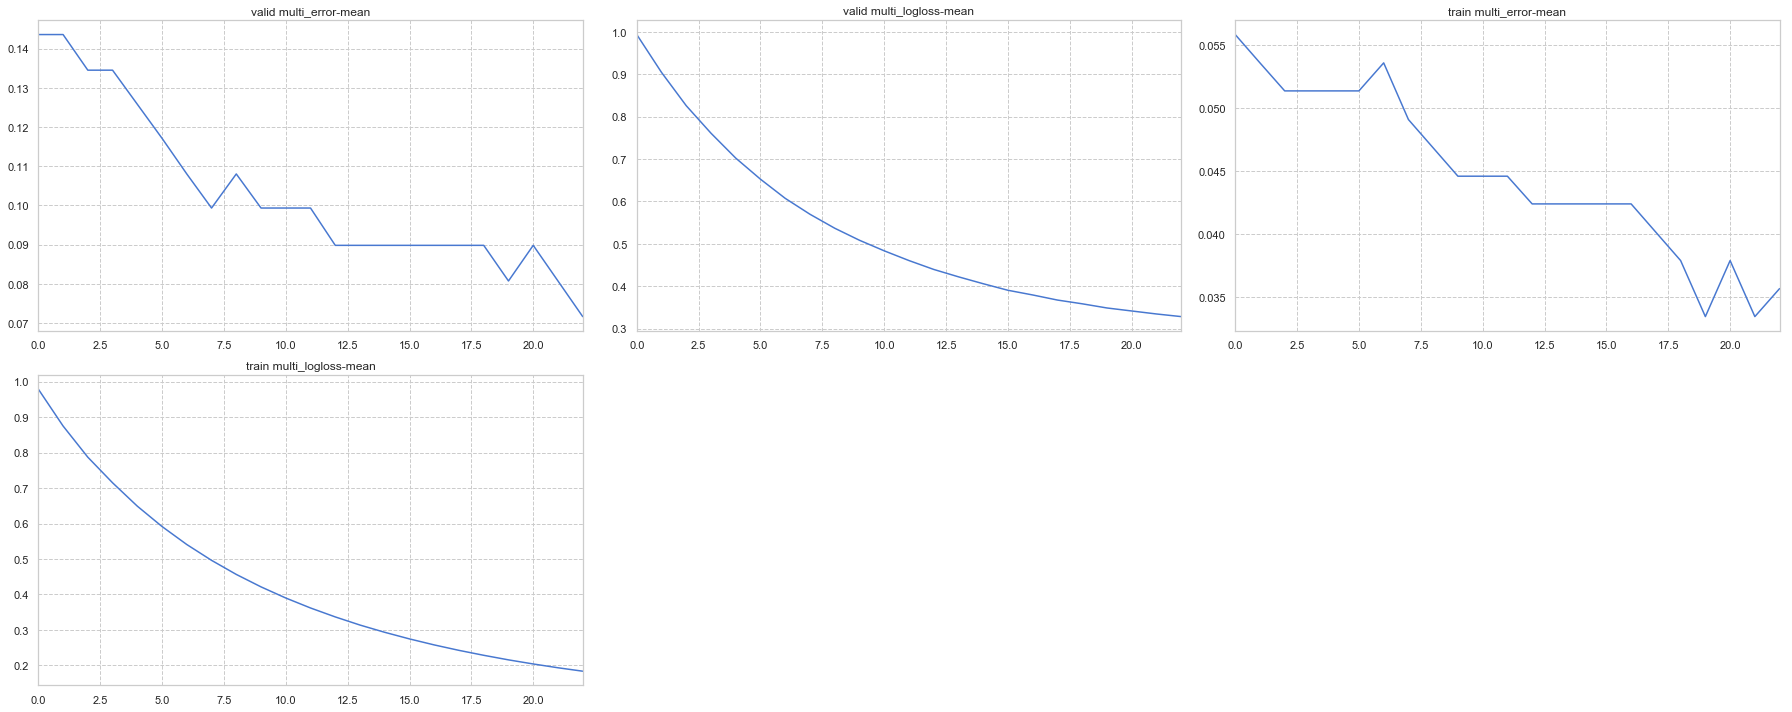


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('multi_error', 'multi_logloss')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_logloss: 0.303975 + 0.129743	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_logloss: 0.30044 + 0.185254	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.327377 + 0.237144	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.370295 + 0.277056	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early

train multi_logloss-mean  train multi_logloss-stdv  \
18                  0.228277                  0.016910   
19                  0.215409                  0.016715   
20                  0.203825                  0.016549   
21                  0.193139                  0.016468   
22                  0.183447                  0.016354   

    train multi_error-mean  train multi_error-stdv  valid multi_logloss-mean  \
18                0.037929                0.016726                  0.358475   
19                0.033485                0.014216                  0.348635   
20                0.037929                0.016726                  0.341552   
21                0.033485                0.014216                  0.334496   
22                0.035707                0.014872                  0.328291   

    valid multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  
18                  0.100058                0.089799                0.062422  
19                  0.104418                0.080708                0.058142  
20                  0.107705                0.089799                0.062422  
21                  0.110455                0.080708                0.058142  
22                  0.114151                0.071617                0.059376

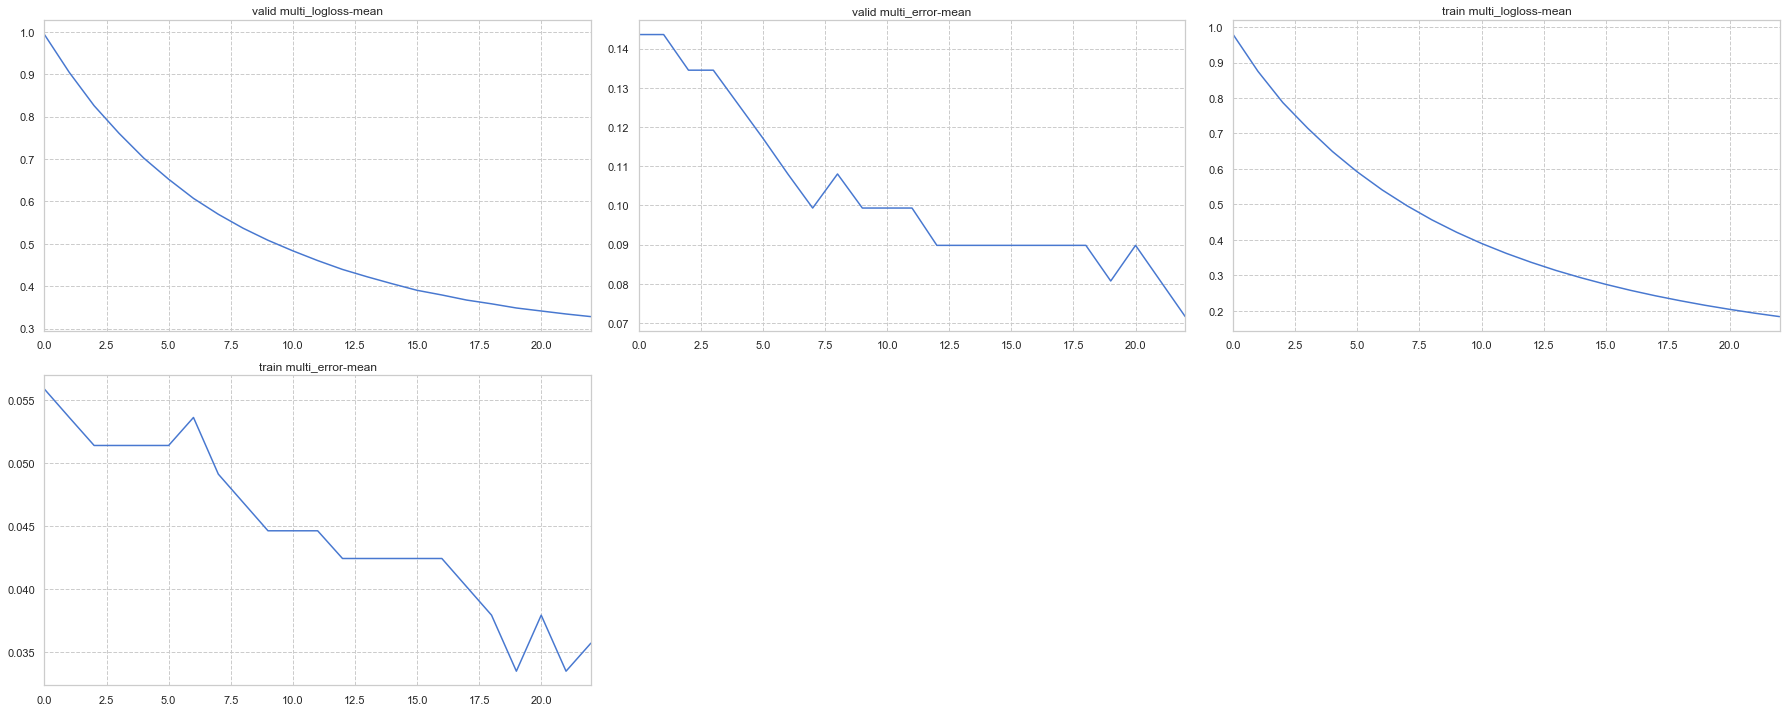


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

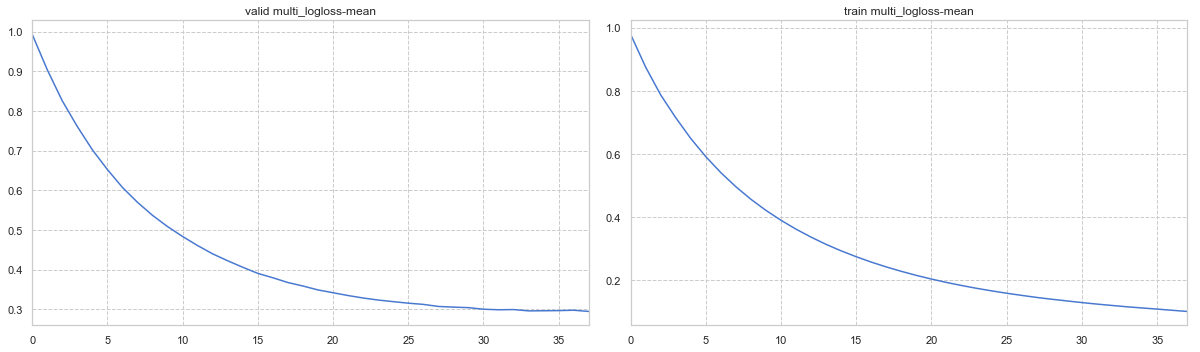


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

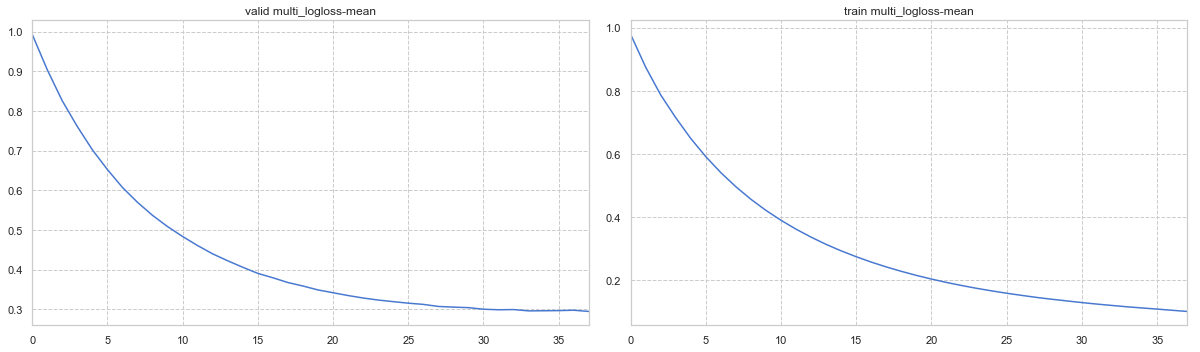


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'multi_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

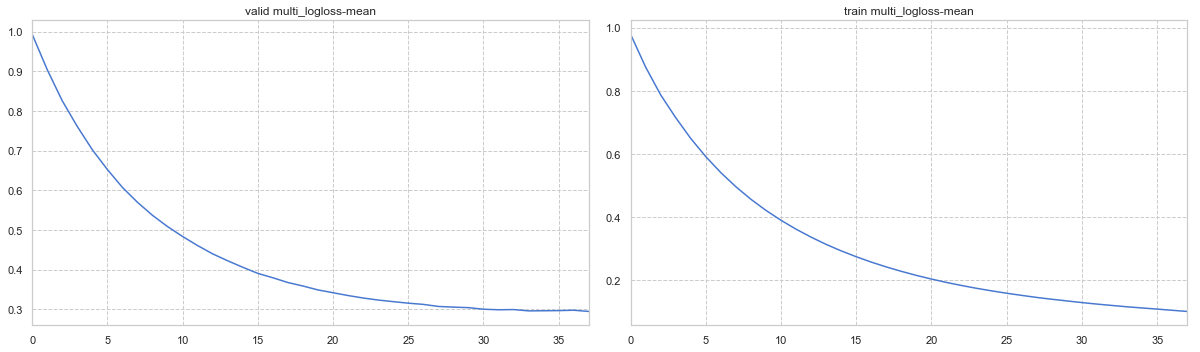


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'multi_error'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early stopping, best iteration is:
[23]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762


train multi_error-mean  train multi_error-stdv  valid multi_error-mean  \
18                0.037929                0.016726                0.089799   
19                0.033485                0.014216                0.080708   
20                0.037929                0.016726                0.089799   
21                0.033485                0.014216                0.080708   
22                0.035707                0.014872                0.071617   

    valid multi_error-stdv  
18                0.062422  
19                0.058142  
20                0.062422  
21                0.058142  
22                0.059376

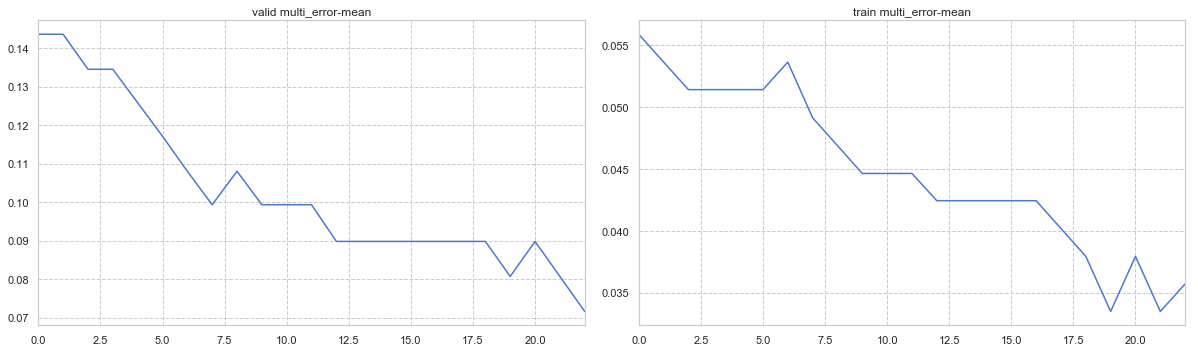


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('multi_logloss', 'multi_error')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_error: 0.0716168 + 0.0593762	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_error: 0.0807077 + 0.0581416	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_error: 0.072012 + 0.0454085	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_error: 0.0807077 + 0.0333468	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early

train multi_error-mean  train multi_error-stdv  train multi_logloss-mean  \
33                0.029015                0.011382                  0.115982   
34                0.031262                0.013070                  0.112324   
35                0.029015                0.011382                  0.108726   
36                0.026793                0.008985                  0.104969   
37                0.024570                0.008450                  0.101291   

    train multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  \
33                  0.016045                0.071617                0.059376   
34                  0.015875                0.071617                0.059376   
35                  0.015537                0.071617                0.059376   
36                  0.015449                0.071617                0.059376   
37                  0.015524                0.080708                0.058142   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

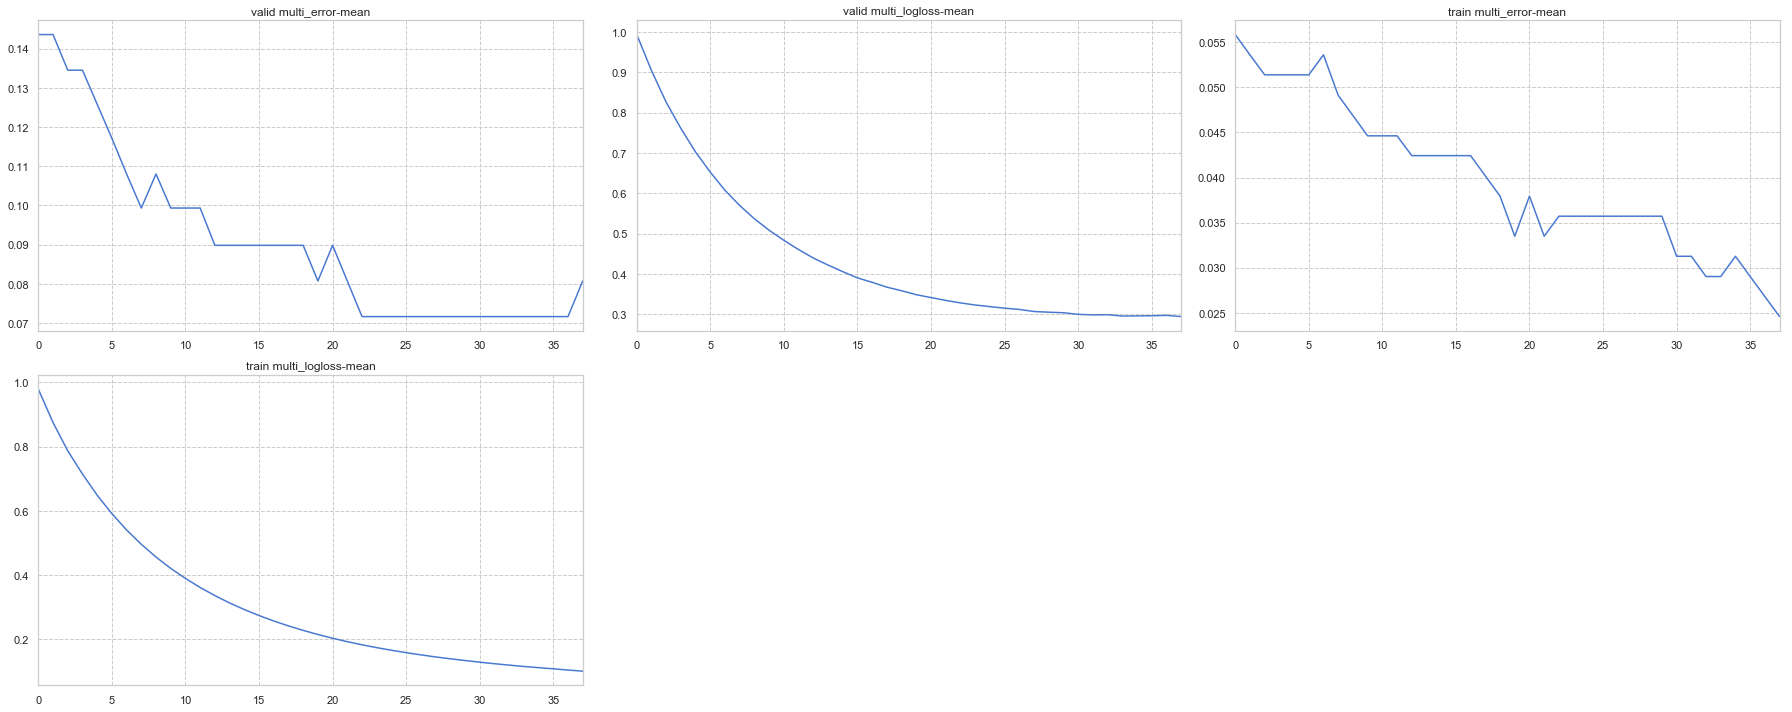


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('multi_error', 'multi_logloss')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_logloss: 0.303975 + 0.129743	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_logloss: 0.30044 + 0.185254	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.327377 + 0.237144	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.370295 + 0.277056	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early

train multi_logloss-mean  train multi_logloss-stdv  \
18                  0.228277                  0.016910   
19                  0.215409                  0.016715   
20                  0.203825                  0.016549   
21                  0.193139                  0.016468   
22                  0.183447                  0.016354   

    train multi_error-mean  train multi_error-stdv  valid multi_logloss-mean  \
18                0.037929                0.016726                  0.358475   
19                0.033485                0.014216                  0.348635   
20                0.037929                0.016726                  0.341552   
21                0.033485                0.014216                  0.334496   
22                0.035707                0.014872                  0.328291   

    valid multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  
18                  0.100058                0.089799                0.062422  
19                  0.104418                0.080708                0.058142  
20                  0.107705                0.089799                0.062422  
21                  0.110455                0.080708                0.058142  
22                  0.114151                0.071617                0.059376

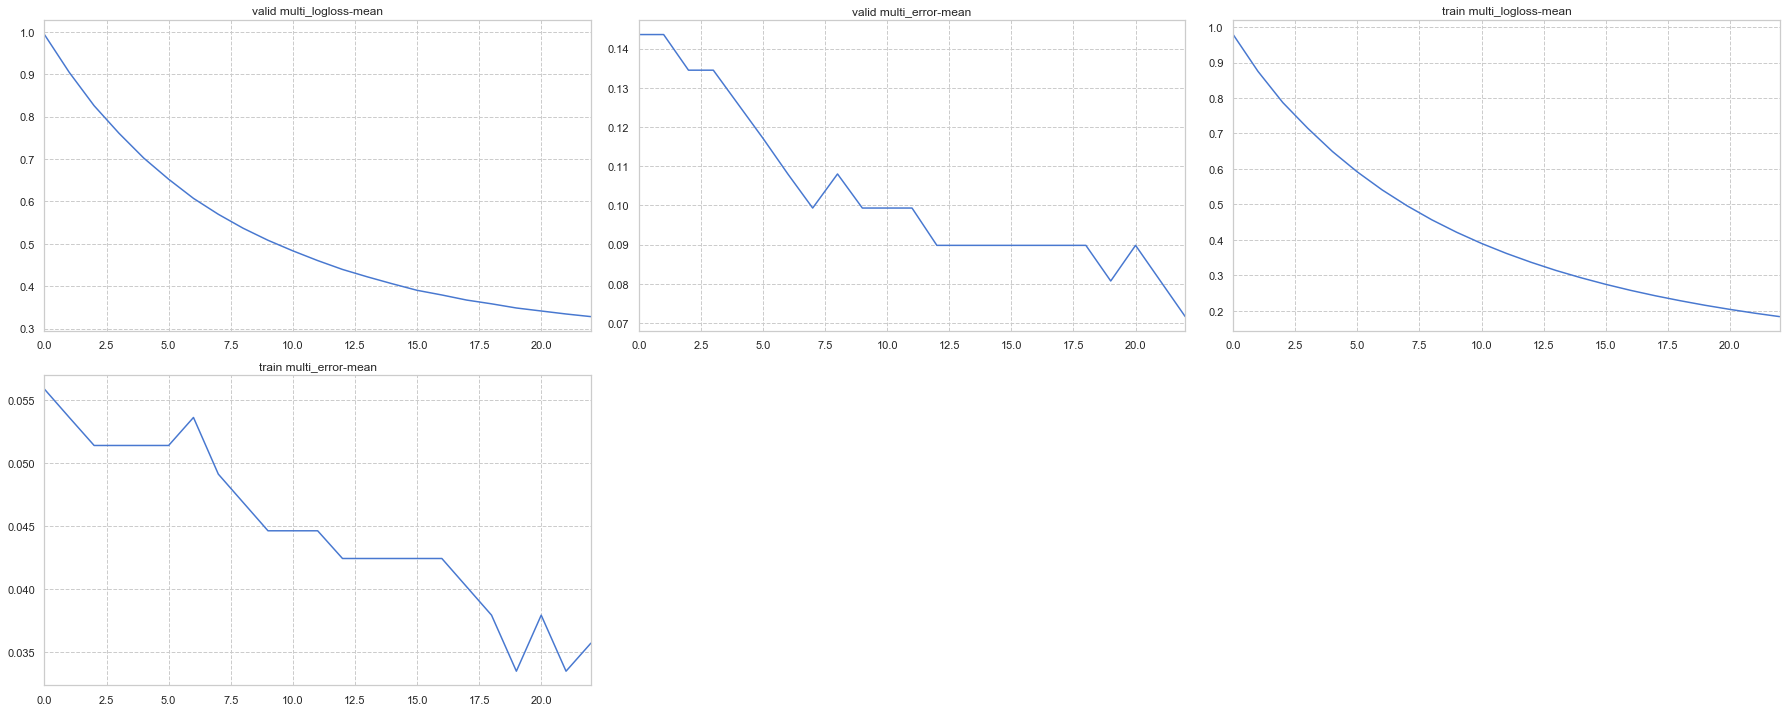


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149
metric_key:valid multi_logloss


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

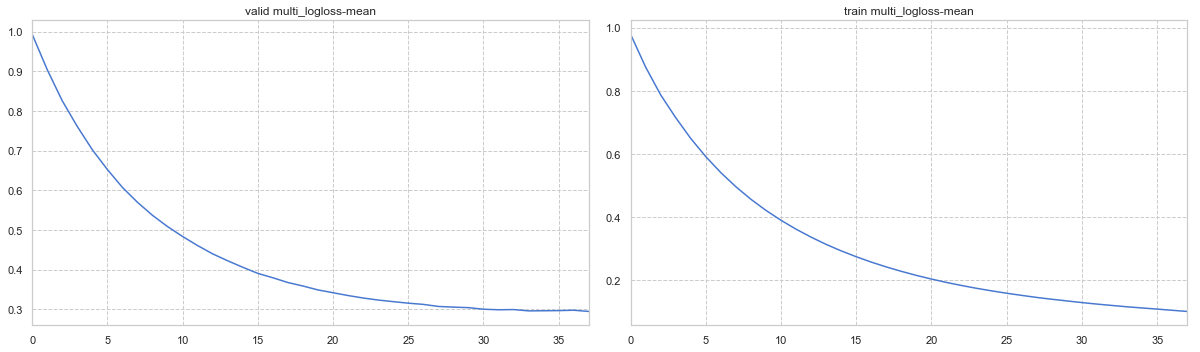


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'multi_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149
metric_key:valid multi_logloss


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

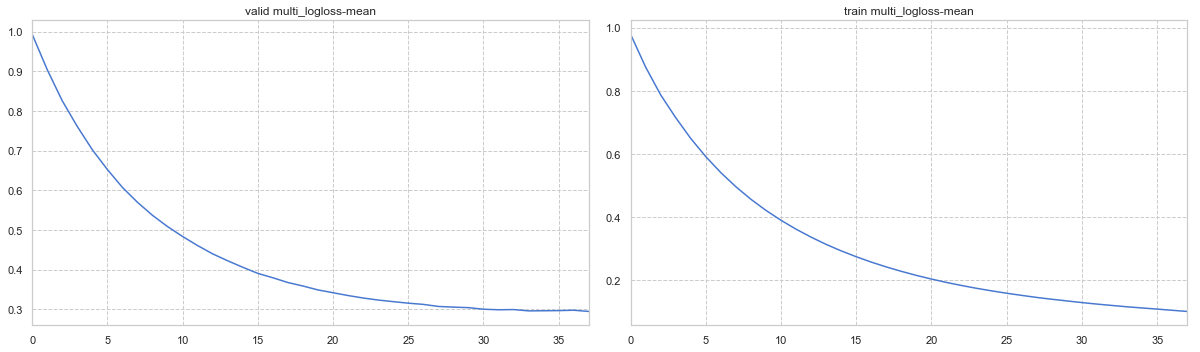


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'multi_error'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early stopping, best iteration is:
[23]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
metric_key:valid multi_error


train multi_error-mean  train multi_error-stdv  valid multi_error-mean  \
18                0.037929                0.016726                0.089799   
19                0.033485                0.014216                0.080708   
20                0.037929                0.016726                0.089799   
21                0.033485                0.014216                0.080708   
22                0.035707                0.014872                0.071617   

    valid multi_error-stdv  
18                0.062422  
19                0.058142  
20                0.062422  
21                0.058142  
22                0.059376

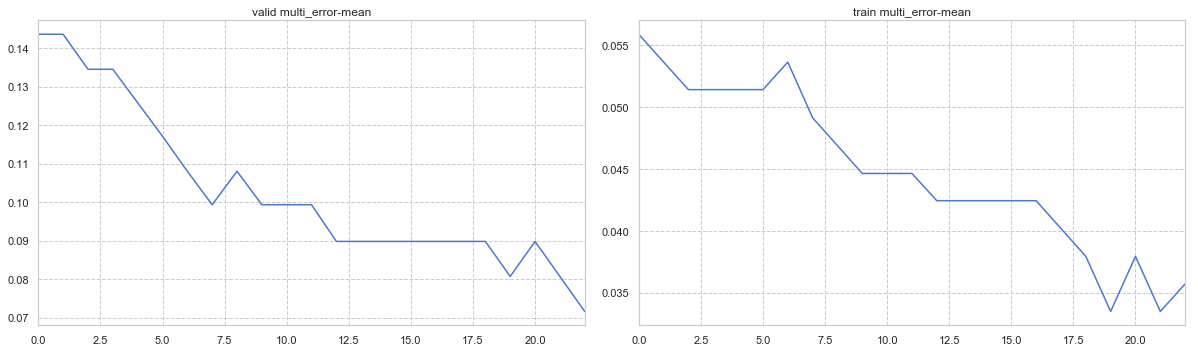


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('multi_logloss', 'multi_error')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_error: 0.0716168 + 0.0593762	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_error: 0.0807077 + 0.0581416	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_error: 0.072012 + 0.0454085	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_error: 0.0807077 + 0.0333468	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Earl

train multi_error-mean  train multi_error-stdv  train multi_logloss-mean  \
18                0.037929                0.016726                  0.228277   
19                0.033485                0.014216                  0.215409   
20                0.037929                0.016726                  0.203825   
21                0.033485                0.014216                  0.193139   
22                0.035707                0.014872                  0.183447   

    train multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  \
18                  0.016910                0.089799                0.062422   
19                  0.016715                0.080708                0.058142   
20                  0.016549                0.089799                0.062422   
21                  0.016468                0.080708                0.058142   
22                  0.016354                0.071617                0.059376   

    valid multi_logloss-mean  valid multi_logloss-stdv  
18                  0.358475                  0.100058  
19                  0.348635                  0.104418  
20                  0.341552                  0.107705  
21                  0.334496                  0.110455  
22                  0.328291                  0.114151

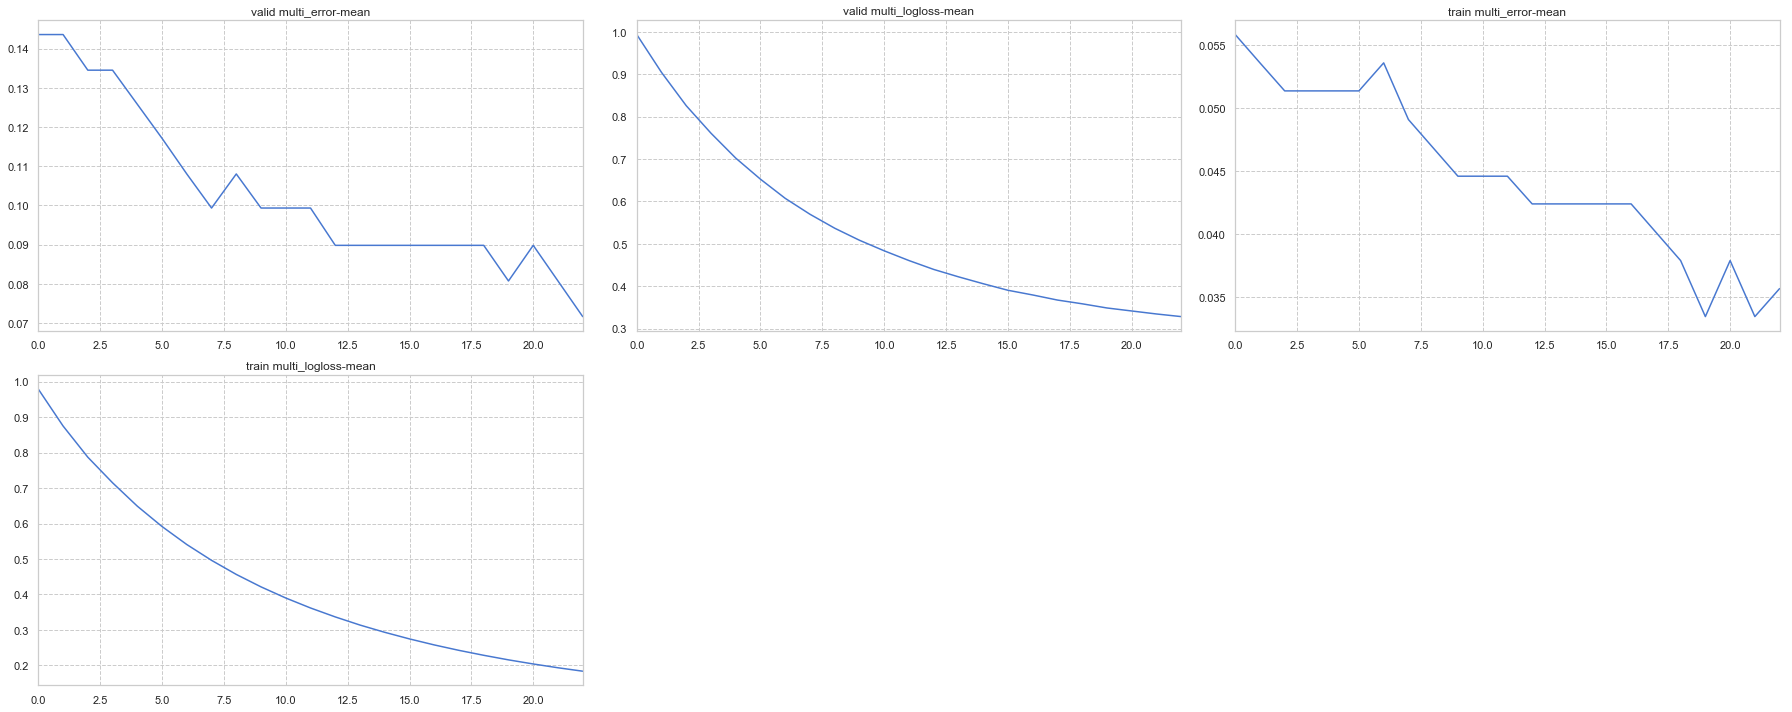


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('multi_error', 'multi_logloss')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_logloss: 0.303975 + 0.129743	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_logloss: 0.30044 + 0.185254	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.327377 + 0.237144	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_logloss: 0.370295 + 0.277056	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Earl

train multi_logloss-mean  train multi_logloss-stdv  \
18                  0.228277                  0.016910   
19                  0.215409                  0.016715   
20                  0.203825                  0.016549   
21                  0.193139                  0.016468   
22                  0.183447                  0.016354   

    train multi_error-mean  train multi_error-stdv  valid multi_logloss-mean  \
18                0.037929                0.016726                  0.358475   
19                0.033485                0.014216                  0.348635   
20                0.037929                0.016726                  0.341552   
21                0.033485                0.014216                  0.334496   
22                0.035707                0.014872                  0.328291   

    valid multi_logloss-stdv  valid multi_error-mean  valid multi_error-stdv  
18                  0.100058                0.089799                0.062422  
19                  0.104418                0.080708                0.058142  
20                  0.107705                0.089799                0.062422  
21                  0.110455                0.080708                0.058142  
22                  0.114151                0.071617                0.059376

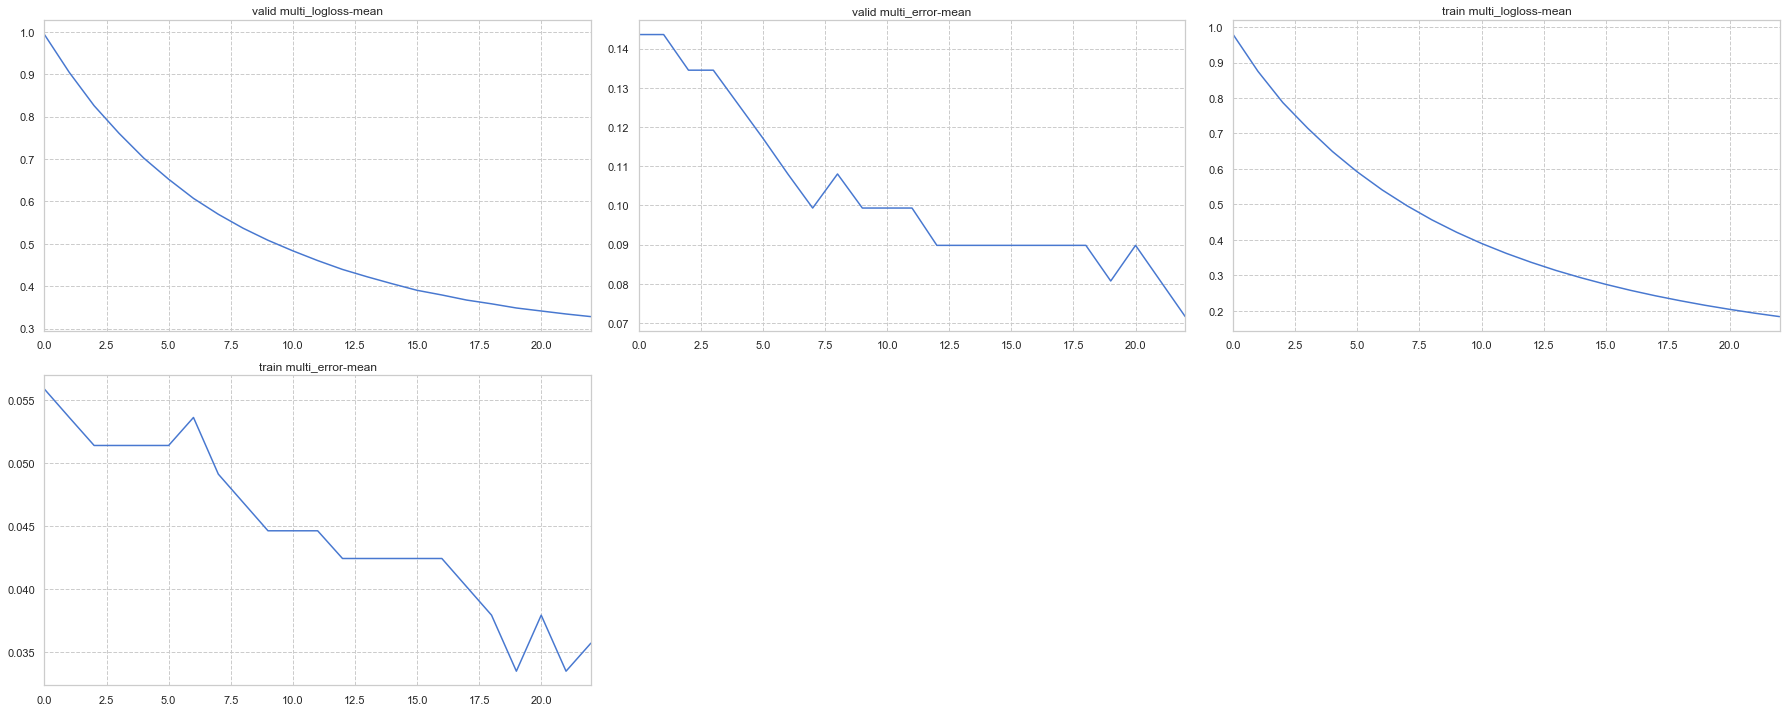


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

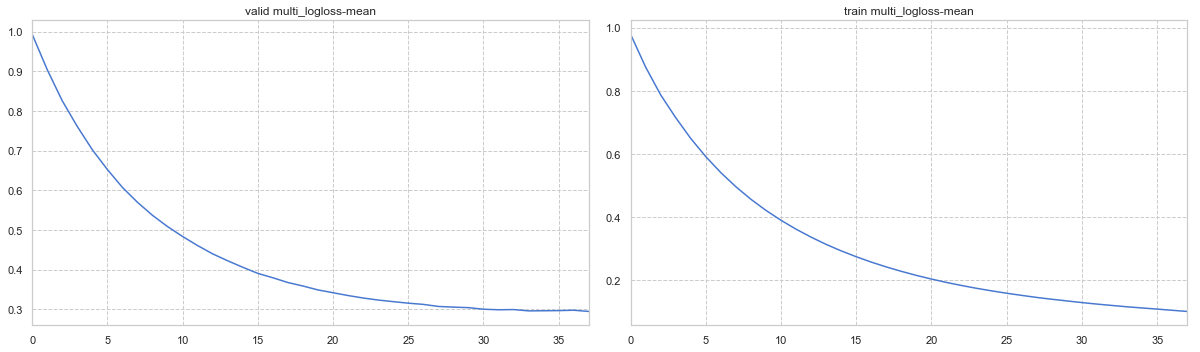


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

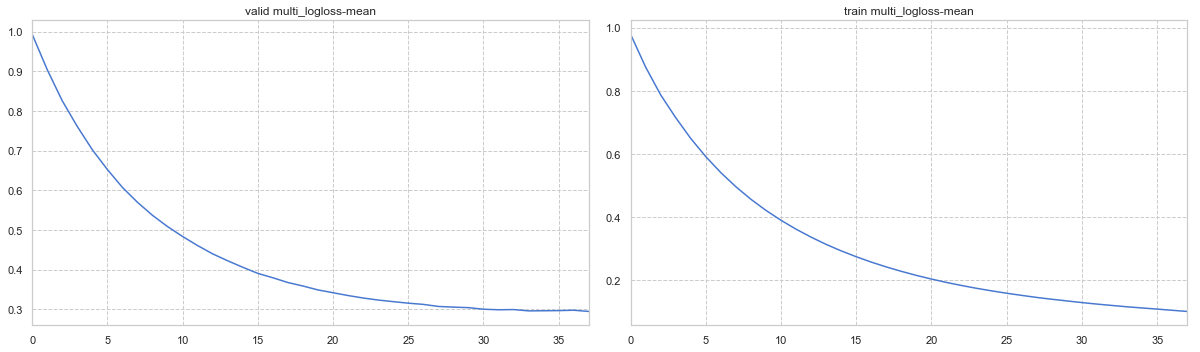


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'None'}

{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'multi_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-8-9c34ae5974fb>", line 49, in multi_label_classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train multi_logloss: 0.13462 + 0.0160243	cv_agg's valid multi_logloss: 0.303975 + 0.129743
[60]	cv_agg's train multi_logloss: 0.0569382 + 0.0144529	cv_agg's valid multi_logloss: 0.30044 + 0.185254
[90]	cv_agg's train multi_logloss: 0.0360136 + 0.013976	cv_agg's valid multi_logloss: 0.327377 + 0.237144
[120]	cv_agg's train multi_logloss: 0.0263465 + 0.013389	cv_agg's valid multi_logloss: 0.370295 + 0.277056
Early stopping, best iteration is:
[38]	cv_agg's train multi_logloss: 0.101291 + 0.0155241	cv_agg's valid multi_logloss: 0.294398 + 0.144149


train multi_logloss-mean  train multi_logloss-stdv  \
33                  0.115982                  0.016045   
34                  0.112324                  0.015875   
35                  0.108726                  0.015537   
36                  0.104969                  0.015449   
37                  0.101291                  0.015524   

    valid multi_logloss-mean  valid multi_logloss-stdv  
33                  0.295804                  0.135394  
34                  0.296125                  0.138316  
35                  0.296504                  0.141331  
36                  0.297446                  0.144257  
37                  0.294398                  0.144149

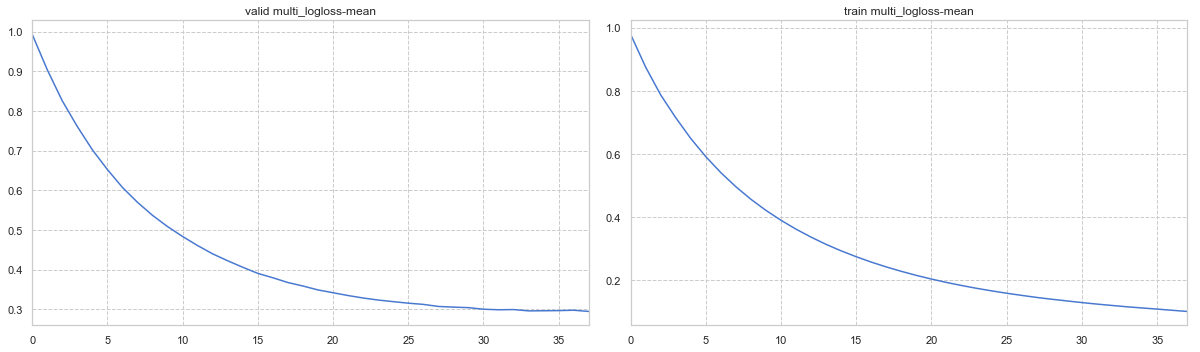


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'multi_error'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762
[60]	cv_agg's train multi_error: 0.0156809 + 0.0114783	cv_agg's valid multi_error: 0.0807077 + 0.0581416
[90]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.072012 + 0.0454085
[120]	cv_agg's train multi_error: 0.00893938 + 0.00839559	cv_agg's valid multi_error: 0.0807077 + 0.0333468
Early stopping, best iteration is:
[23]	cv_agg's train multi_error: 0.035707 + 0.0148715	cv_agg's valid multi_error: 0.0716168 + 0.0593762


train multi_error-mean  train multi_error-stdv  valid multi_error-mean  \
18                0.037929                0.016726                0.089799   
19                0.033485                0.014216                0.080708   
20                0.037929                0.016726                0.089799   
21                0.033485                0.014216                0.080708   
22                0.035707                0.014872                0.071617   

    valid multi_error-stdv  
18                0.062422  
19                0.058142  
20                0.062422  
21                0.058142  
22                0.059376

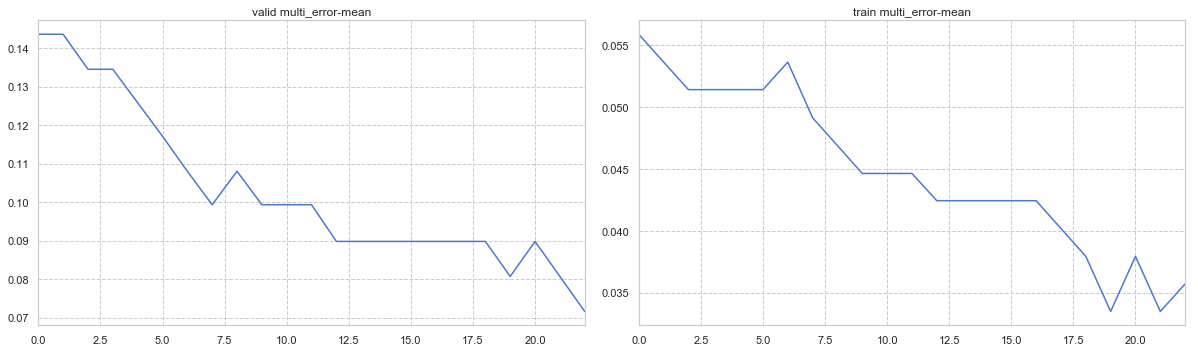

In [9]:
test_train(multi_label_classification_train, 
           param_func=multi_classification_params, 
           dataset=load_data_for_multi_label_classification())

# Regression

In [10]:
from sklearn.metrics import mean_absolute_error

In [11]:
def load_data_for_regression():
    rd.seed(123)
    print('Loading data...')
    df_train = pd.read_csv('../dataset/regression.train', header=None, sep='\t')
    df_test = pd.read_csv('../dataset/regression.test', header=None, sep='\t')

    y_train = df_train[0]
    y_test = df_test[0]
    X_train = df_train.drop(0, axis=1)
    X_test = df_test.drop(0, axis=1)
    return X_train, y_train, X_test, y_test


def regression_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500):
    X_train, y_train, X_test, y_test = dataset
    
    lgb_train = lgb.Dataset(X_train, y_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': 0.5,
        'num_leaves': 5,
        #'metric': ['l1', 'l2'],
        'metric' :metric_list,
        'verbose': -1
    }

    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
    eval_train_metric=True
    # # Fitting
    ret = lgb.cv(params=params,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 30,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   #return_boosters=True
                   )
    #print(f"best_iteration : {model.best_iteration}")

    df_ret = pd.DataFrame(ret)
    df_ret.tail()
    return df_ret

def regression_params():
    two_metrics = list(permutations(['l1','l2', ], 2))
    three_metrics = list(permutations(['l1','l2',  'rmse'], 3))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" : two_metrics + three_metrics + [
                          None, "", "None", 'l1','l2',  'rmse',  # just one metric
                        ] , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg

Loading data...
{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l2: 0.122033 + 0.00108333	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l2: 0.213233 + 0.00281925	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l2: 0.110439 + 0.00116102	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l2: 0.216656 + 0.00209944	cv_agg's valid l1: 0.39735 + 0.

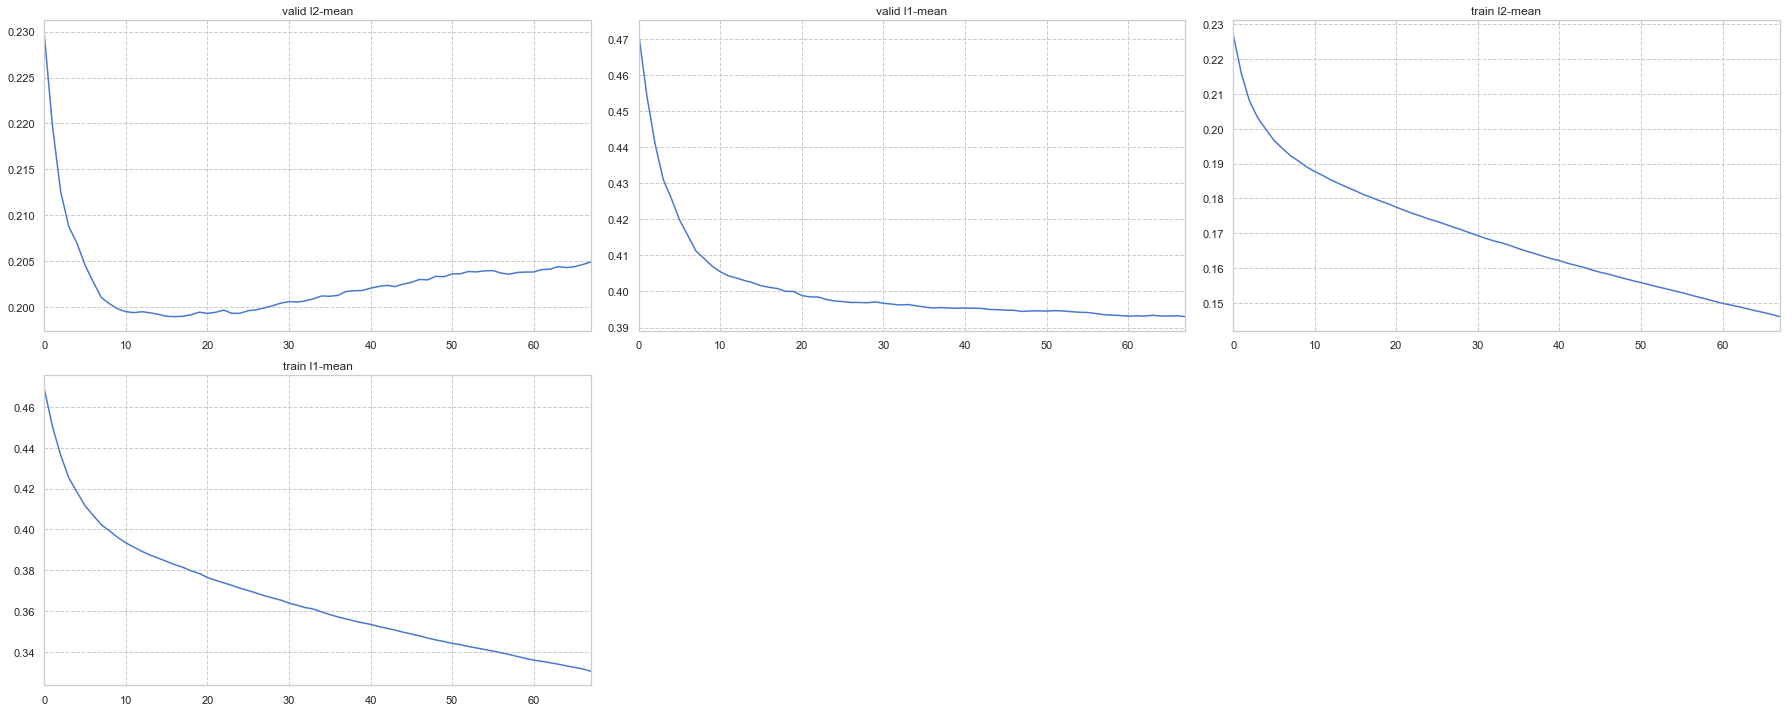


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l1: 0.401154 + 0.00478475	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


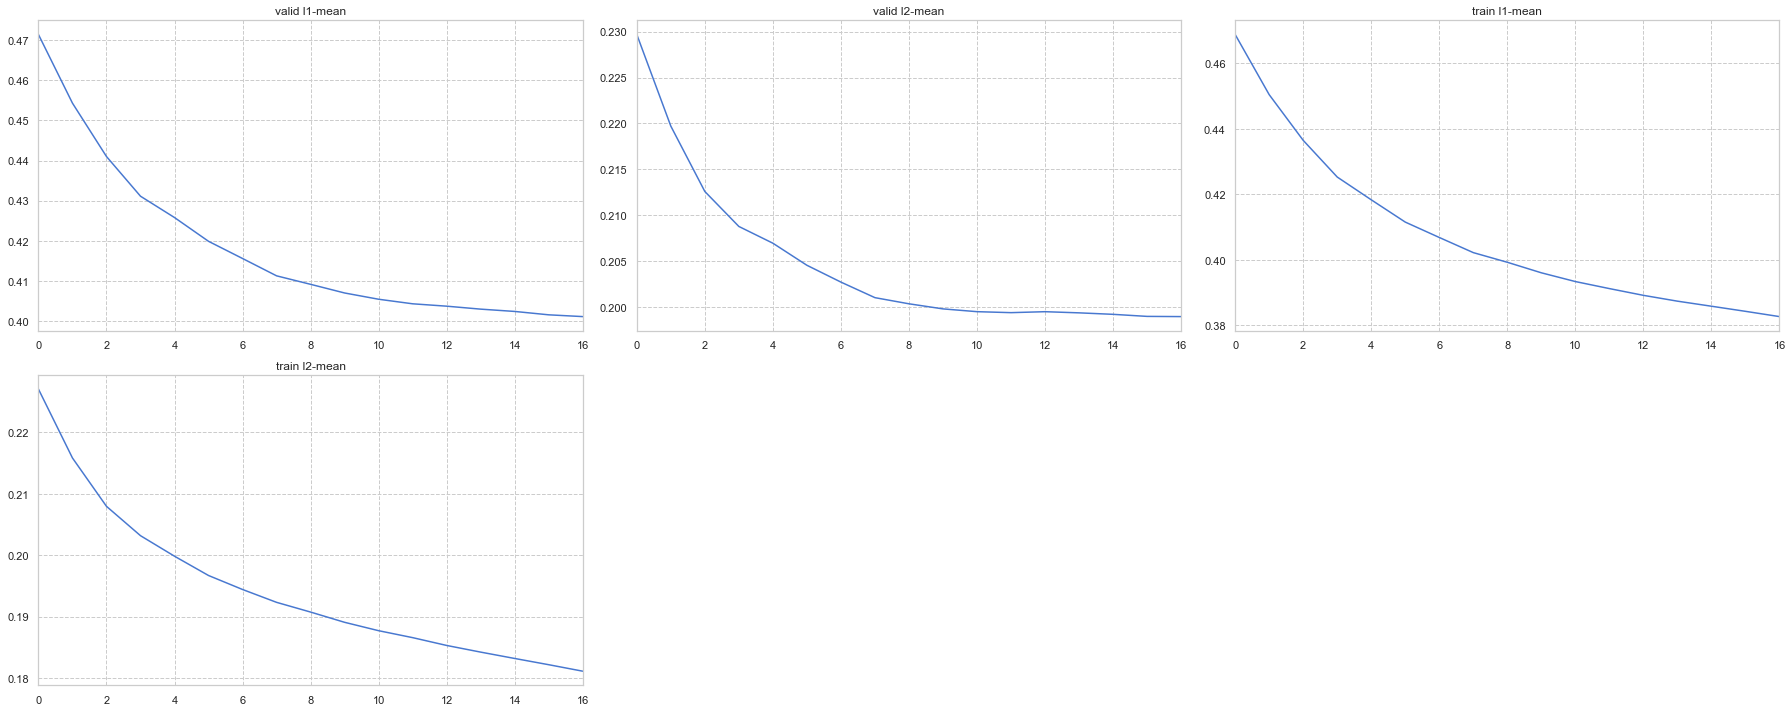


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l1', 'l2', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train rmse: 0.349329 + 0.00155094	cv_agg's train l2: 0.122033 + 0.

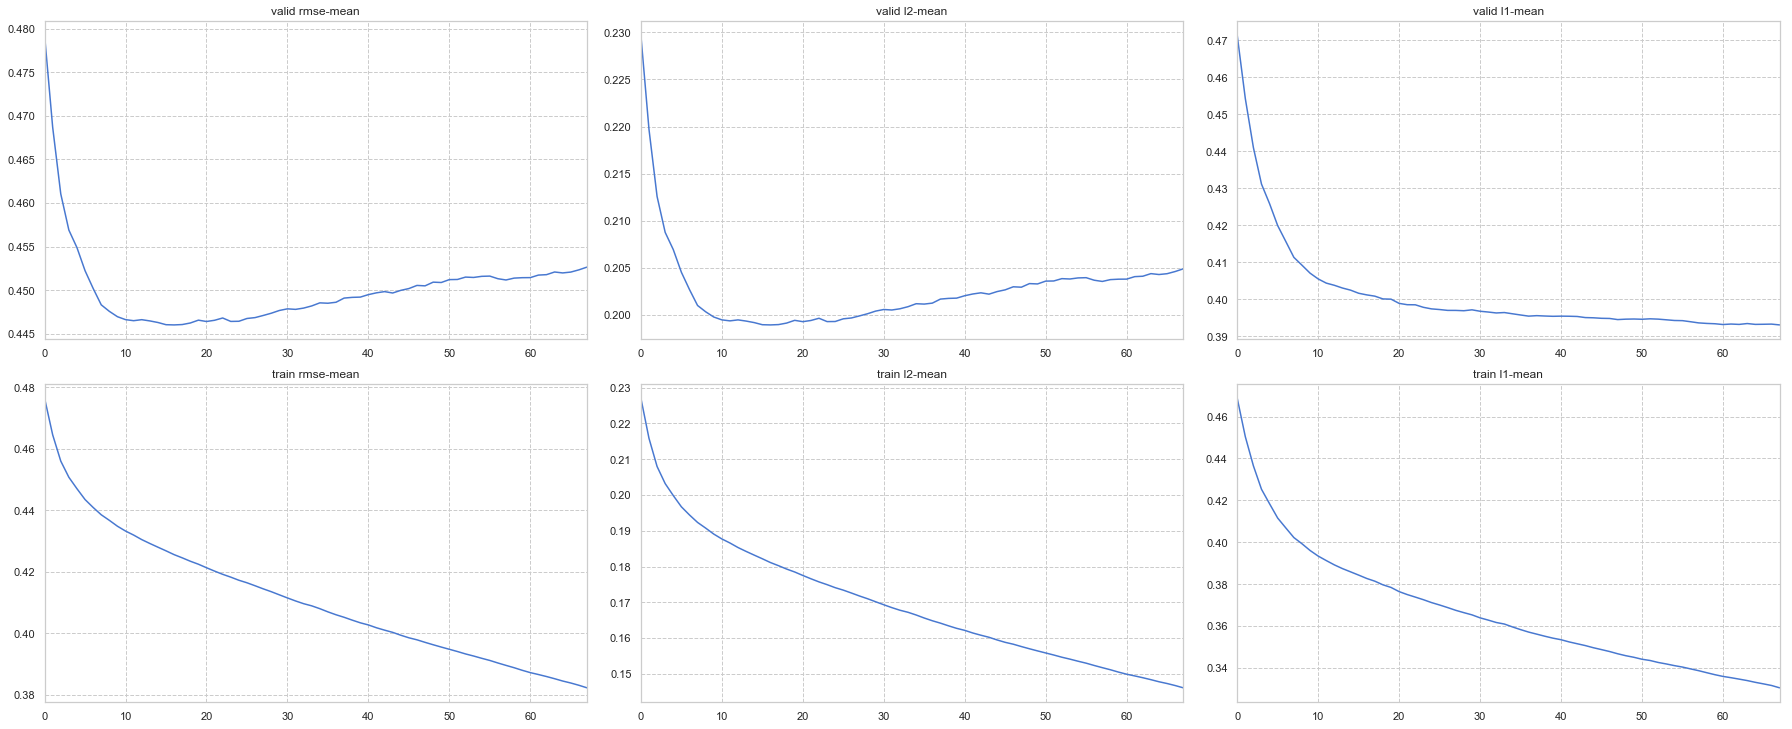


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l1', 'rmse', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l2: 0.122033 + 0.00108333	cv_agg's train rmse: 0.349329 + 0.

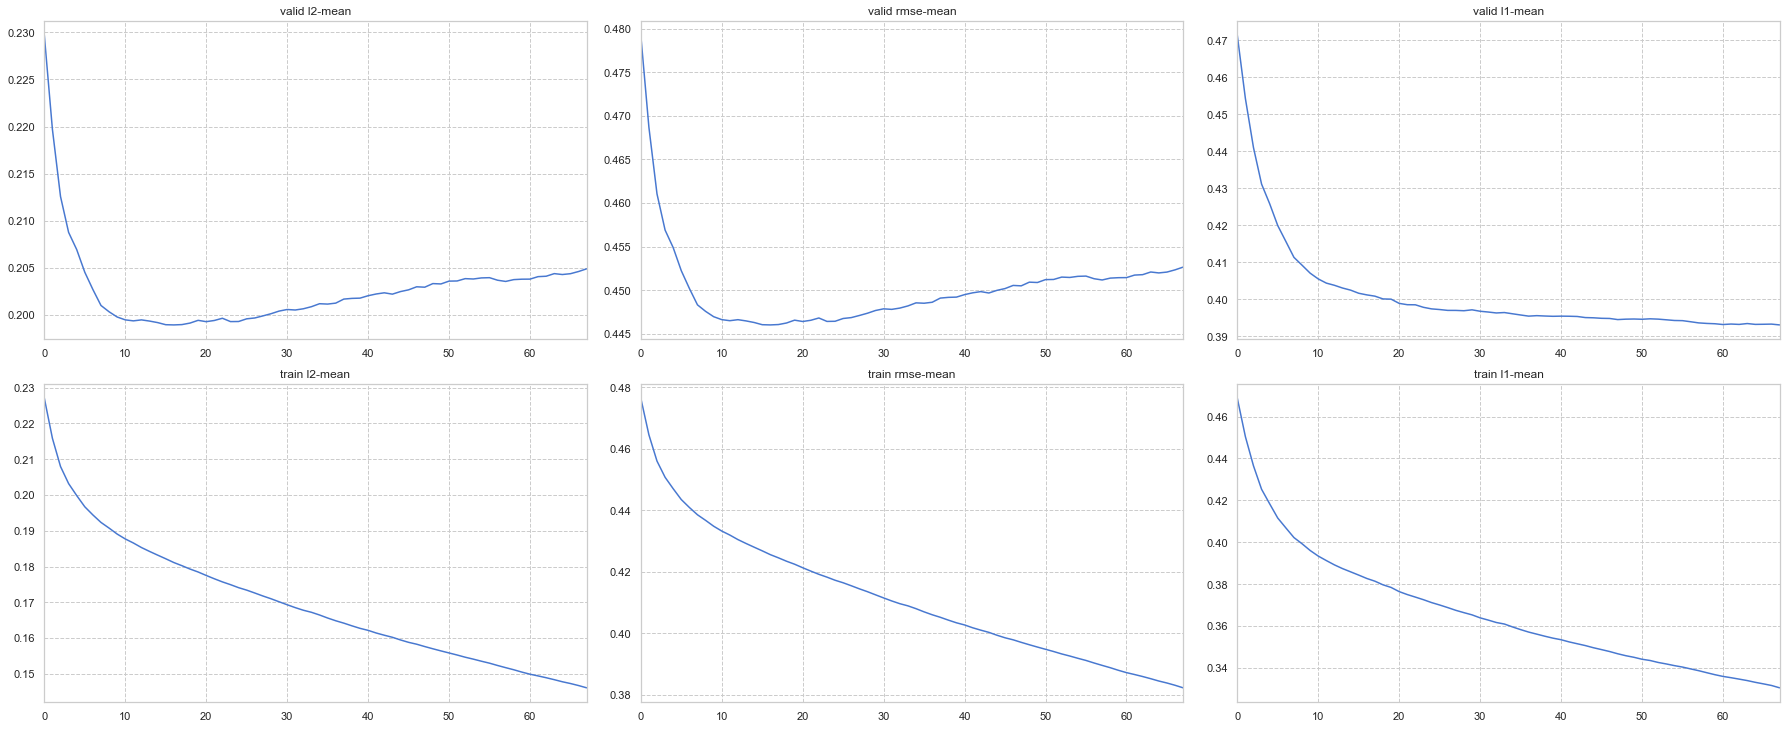


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l2', 'l1', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.0010277

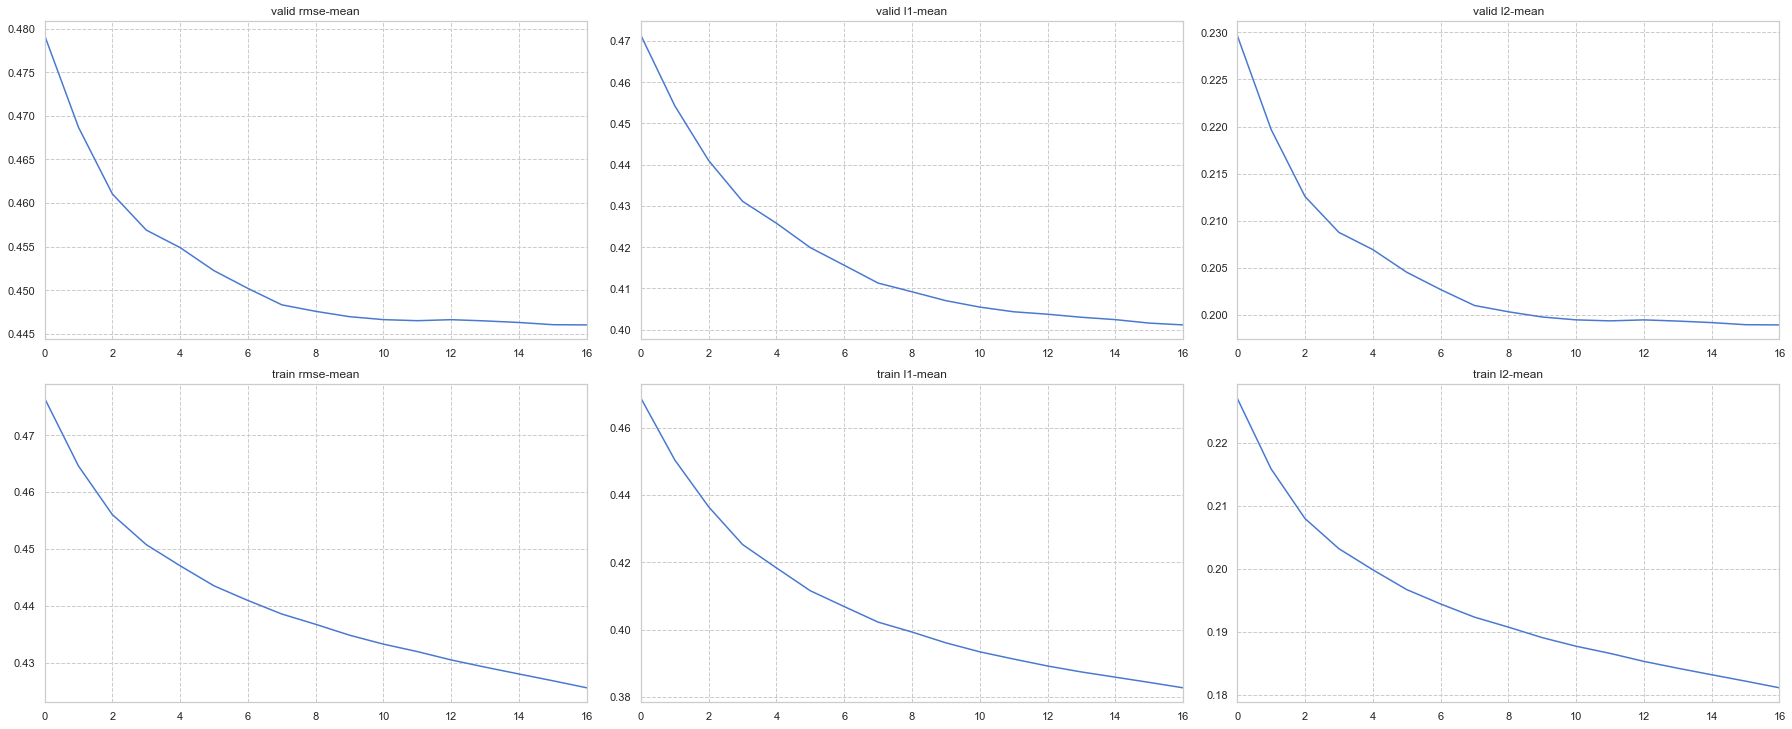


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('l2', 'rmse', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	c

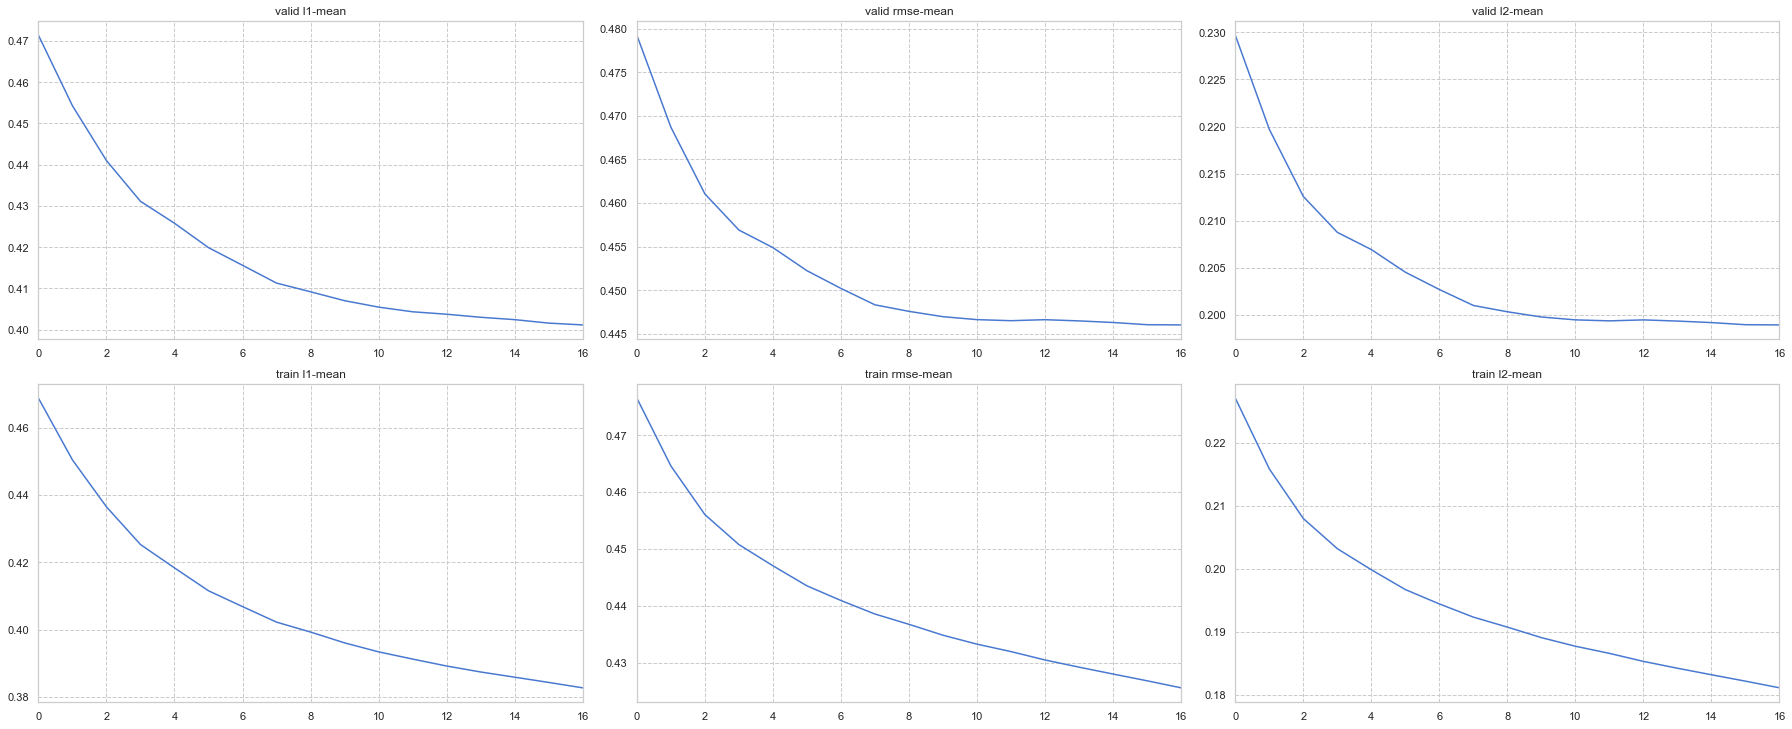


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('rmse', 'l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	

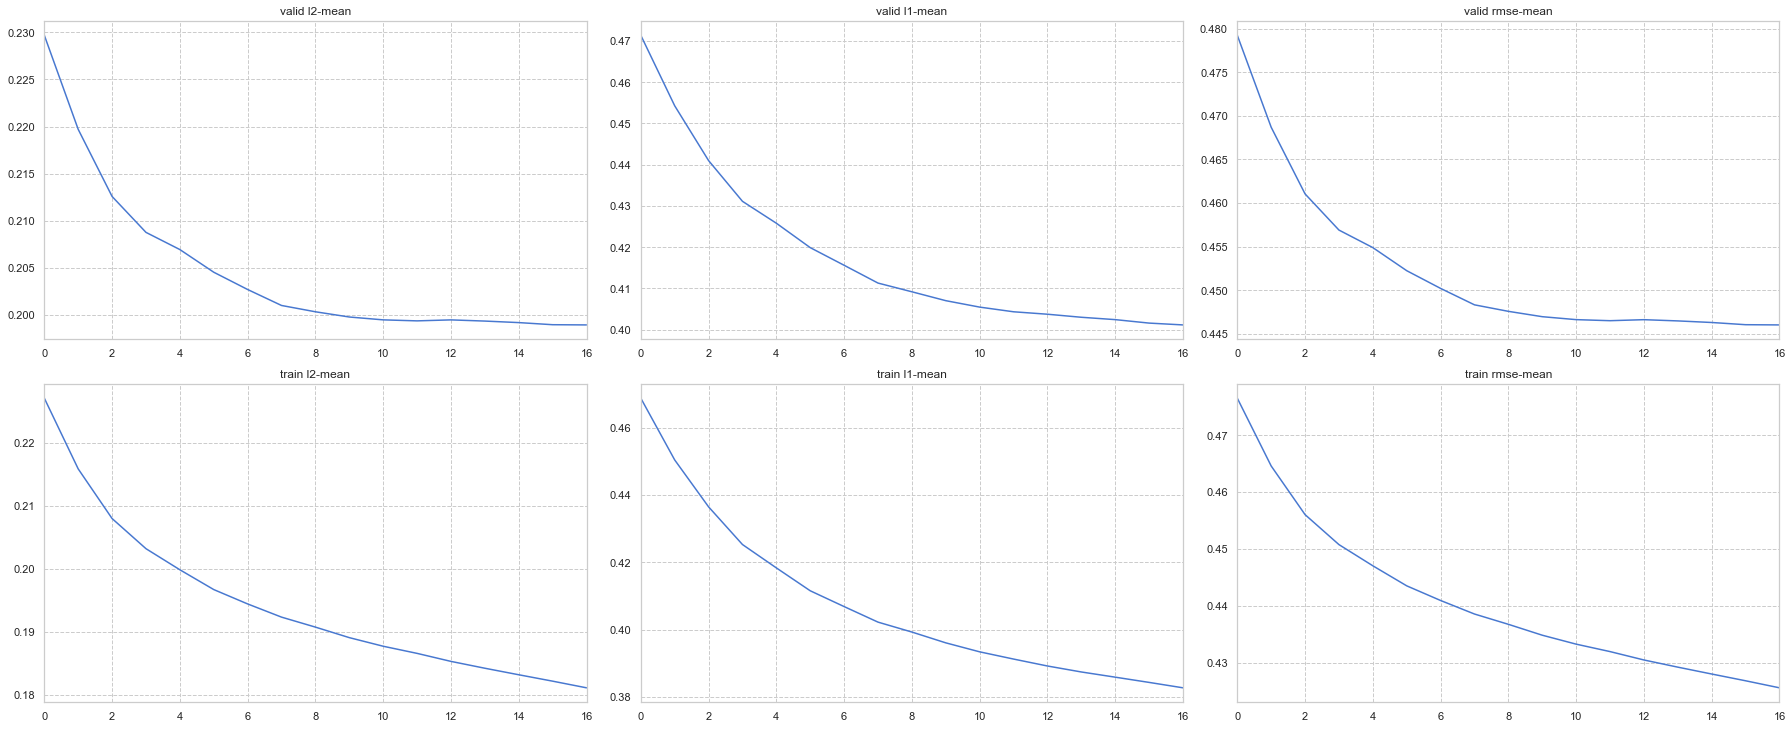


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('rmse', 'l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	c

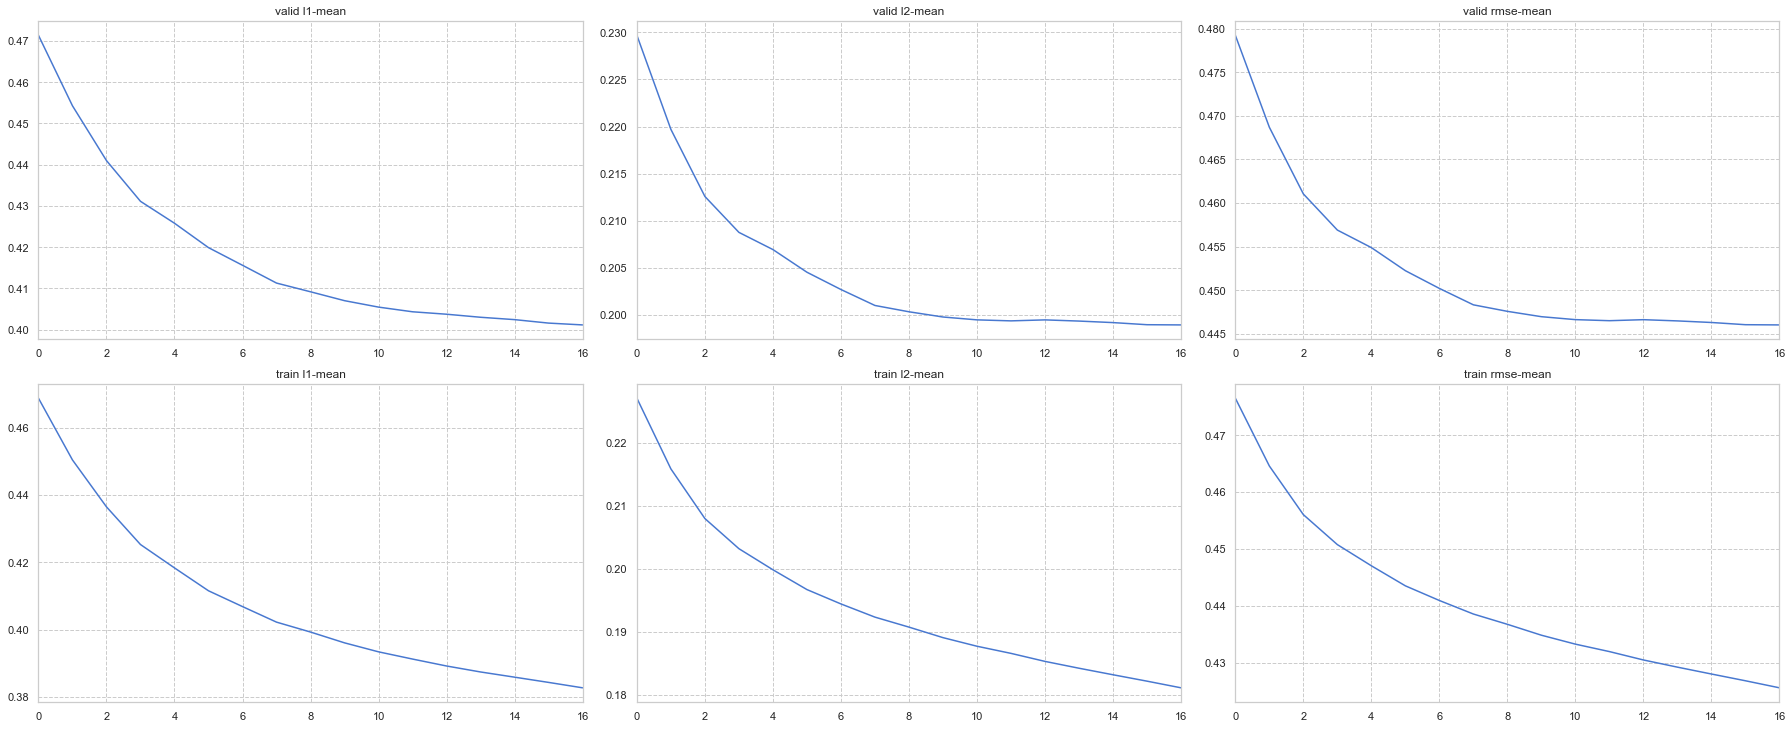


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


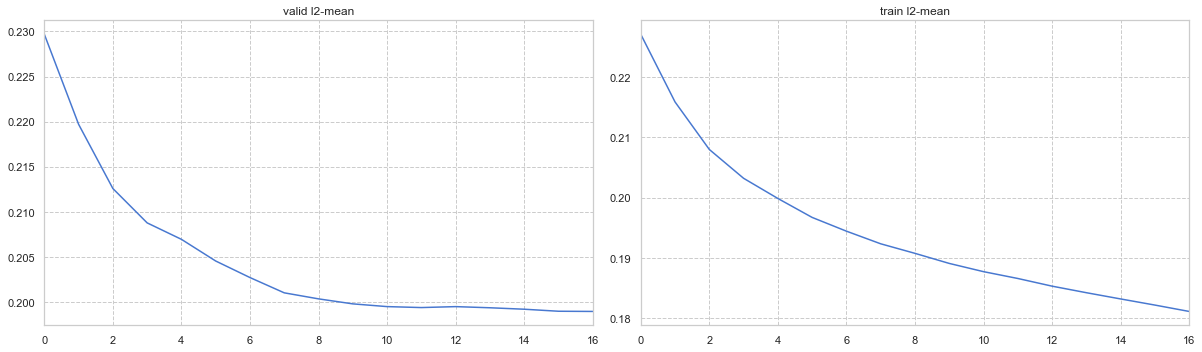


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'l1'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l1: 0.39735 + 0.00318484
Early stopping, best iteration is:
[68]	cv_agg's train l1: 0.330498 + 0.00213712	cv_agg's valid l1: 0.393031 + 0.00319347
metric_key:valid l1


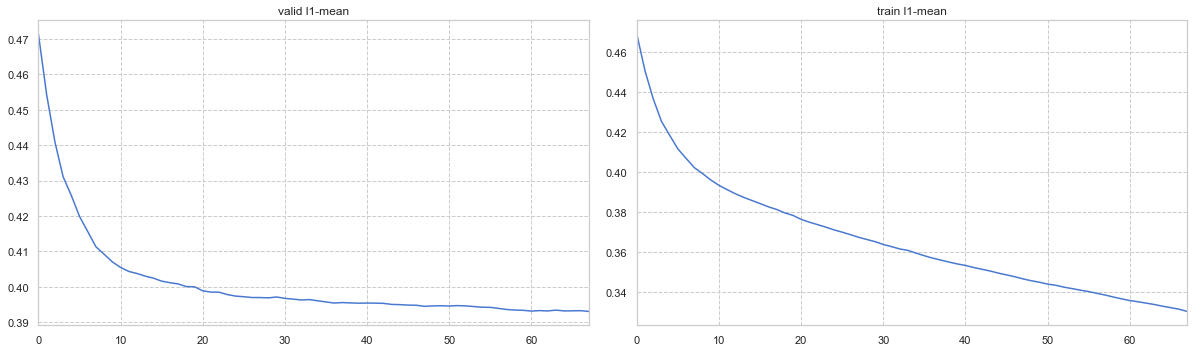


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'l2'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


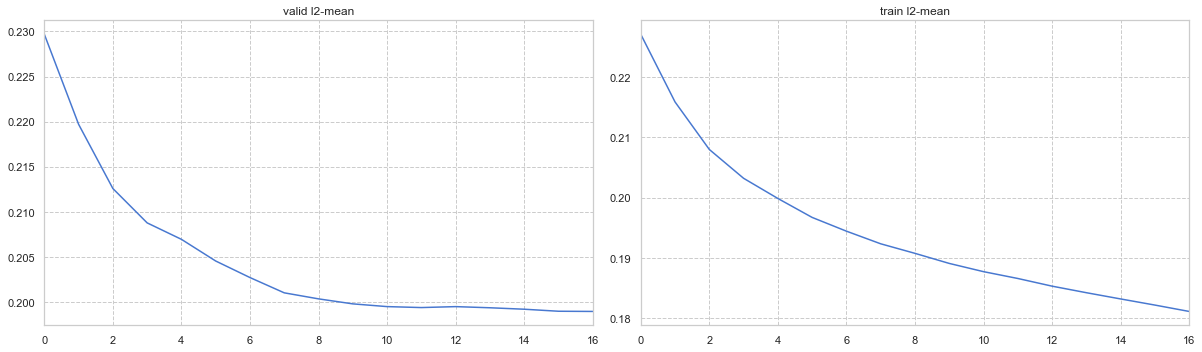


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'rmse'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102774	cv_agg's valid rmse: 0.446009 + 0.00448162
metric_key:valid rmse


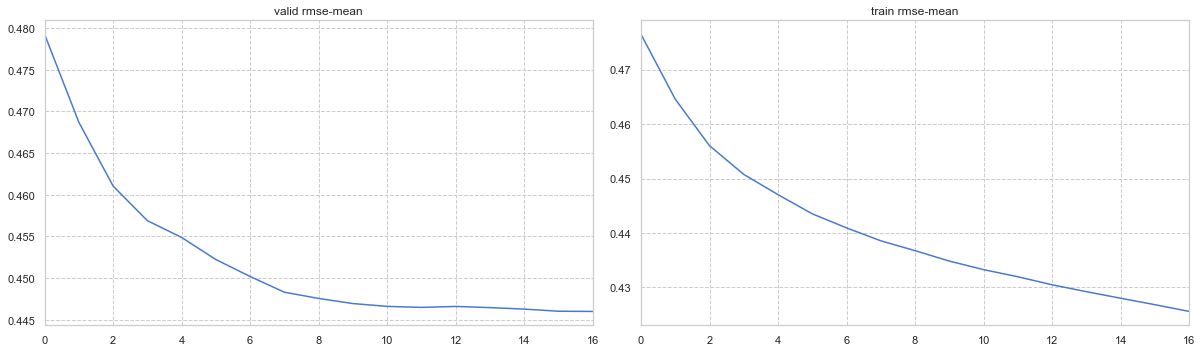


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's valid l2: 0.198944 + 0.00400309	cv_agg's valid l1: 0.401154 + 0.00478475


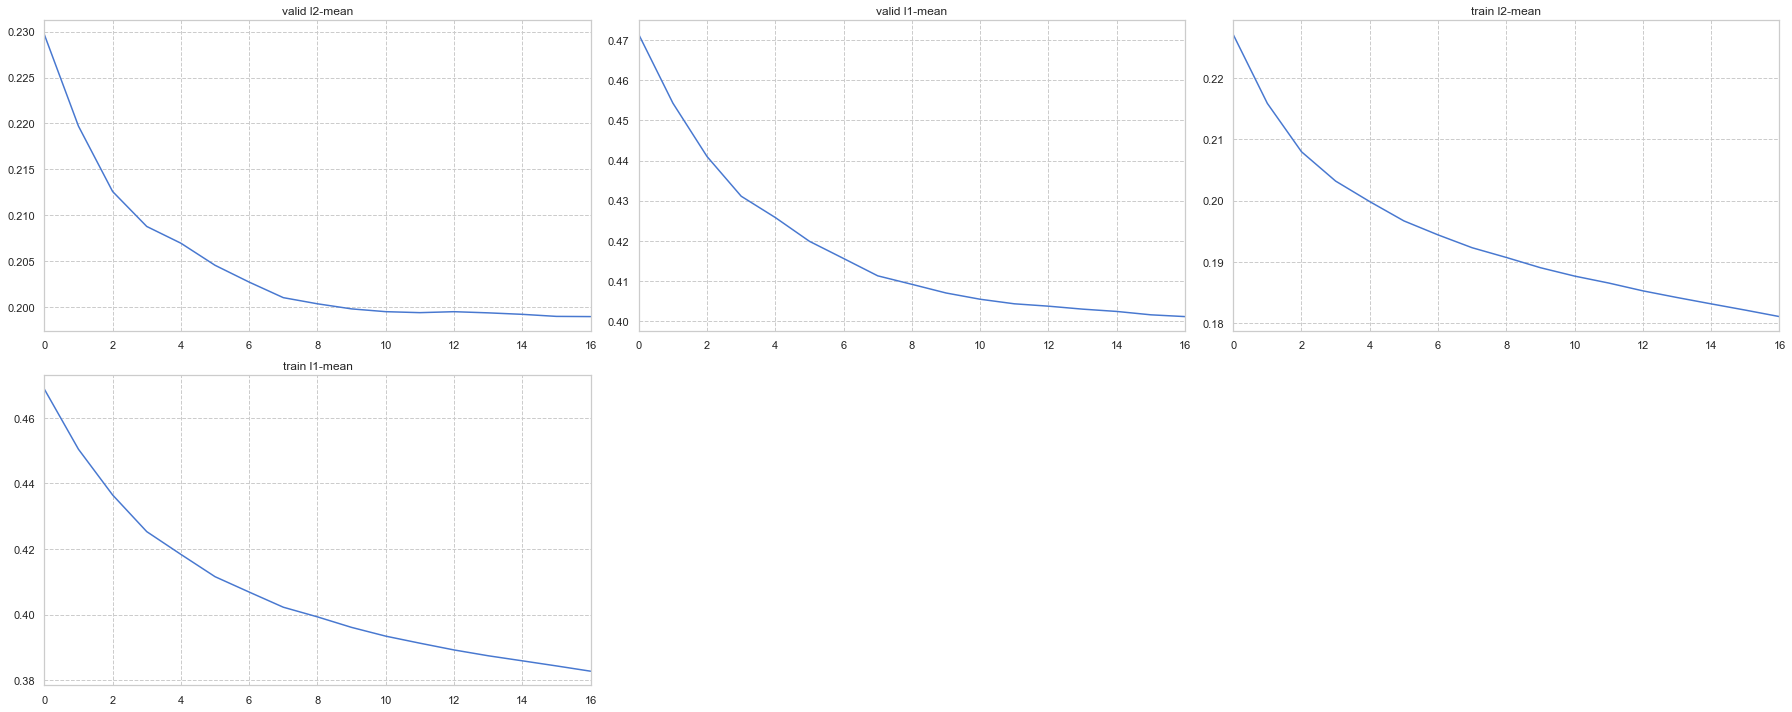


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l1: 0.401154 + 0.00478475	cv_agg's valid l2: 0.198944 + 0.00400309


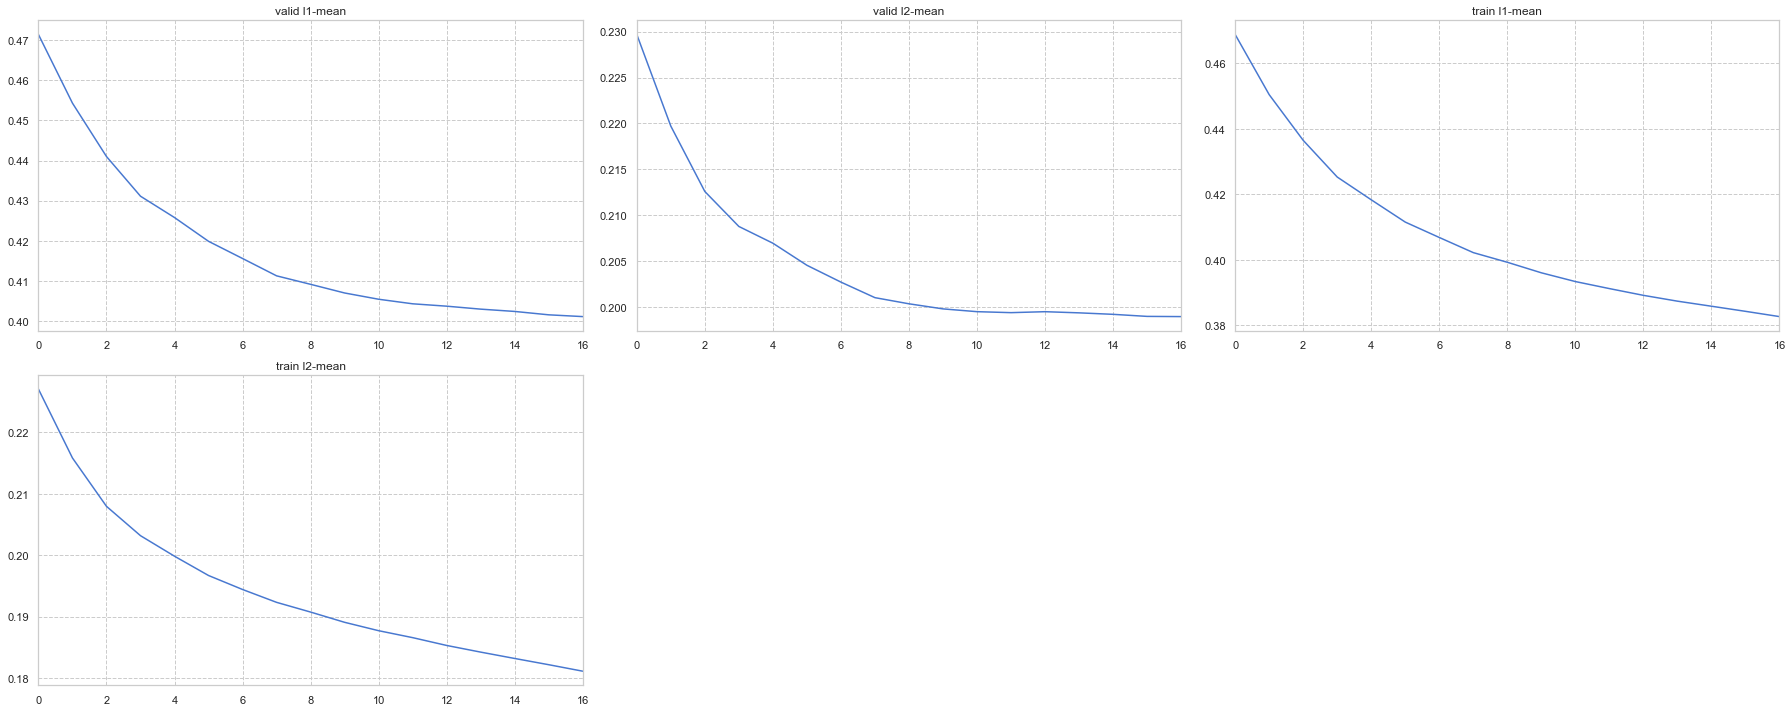


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l1', 'l2', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.001027

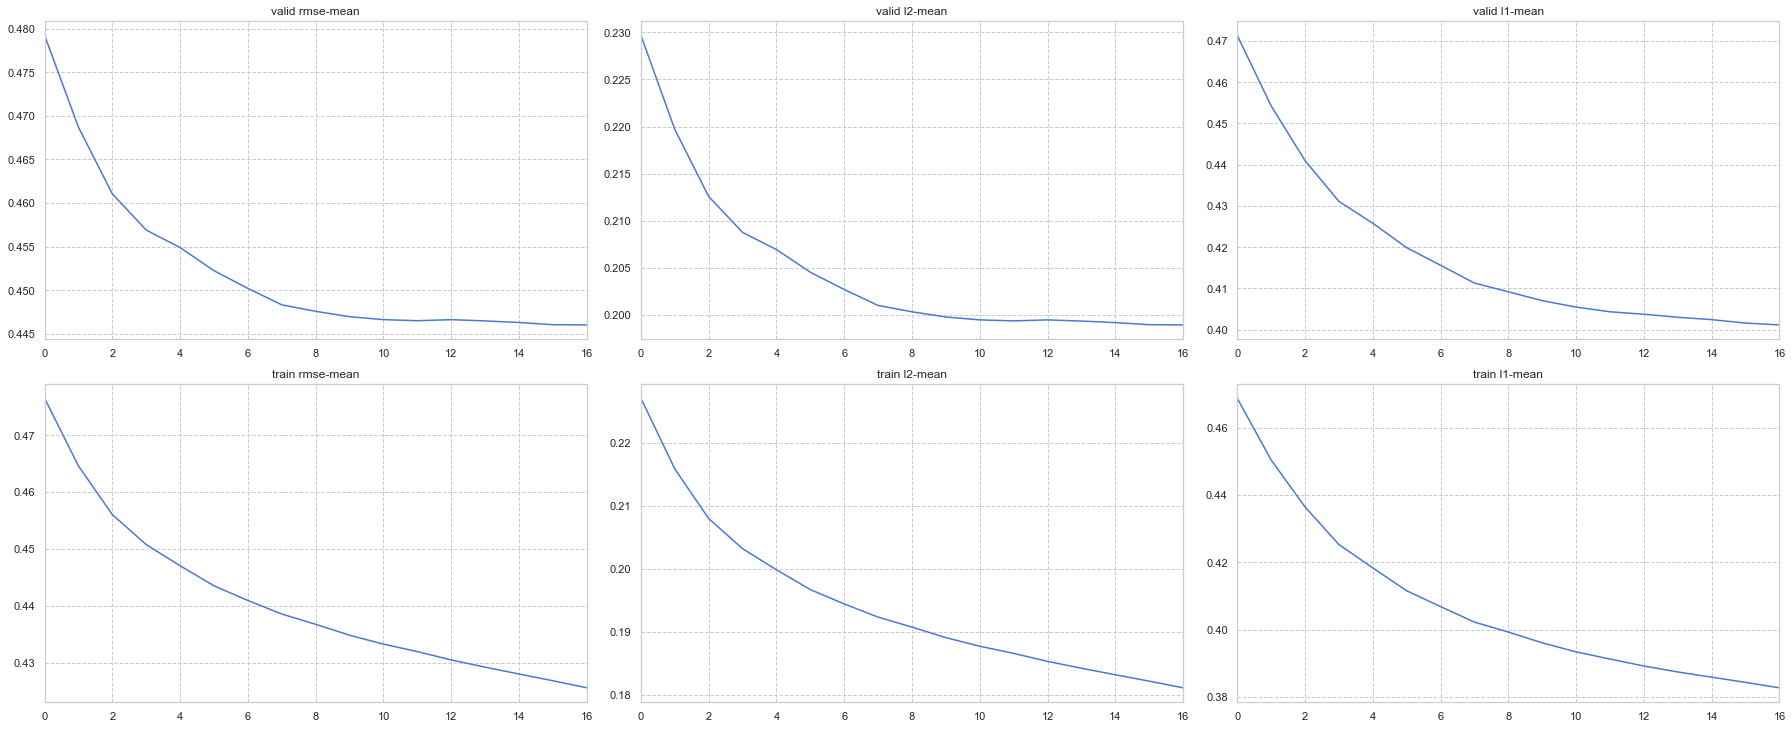


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l1', 'rmse', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619

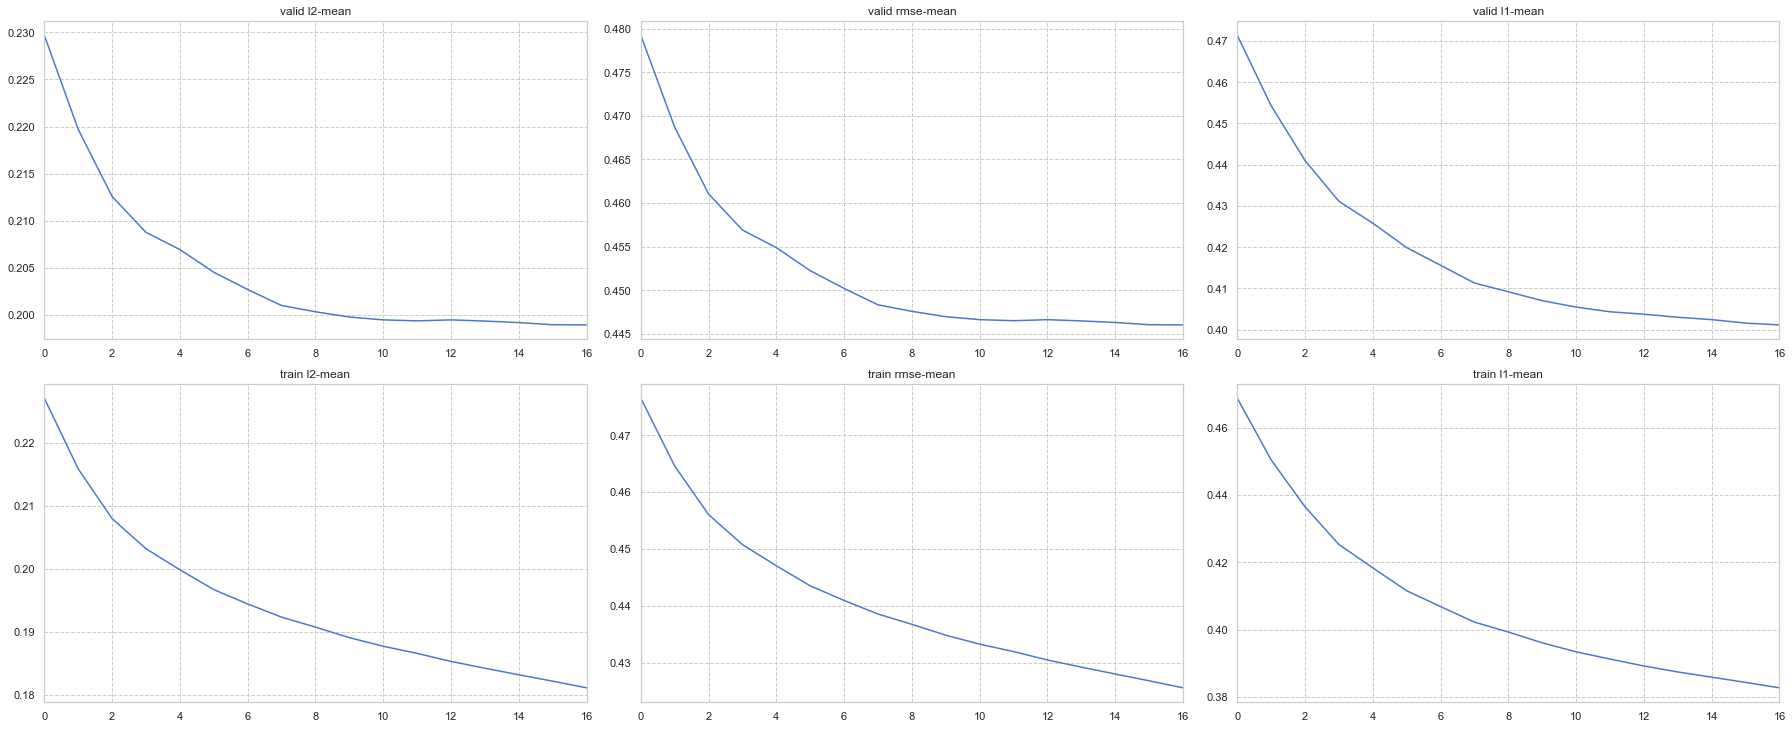


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l2', 'l1', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.001027

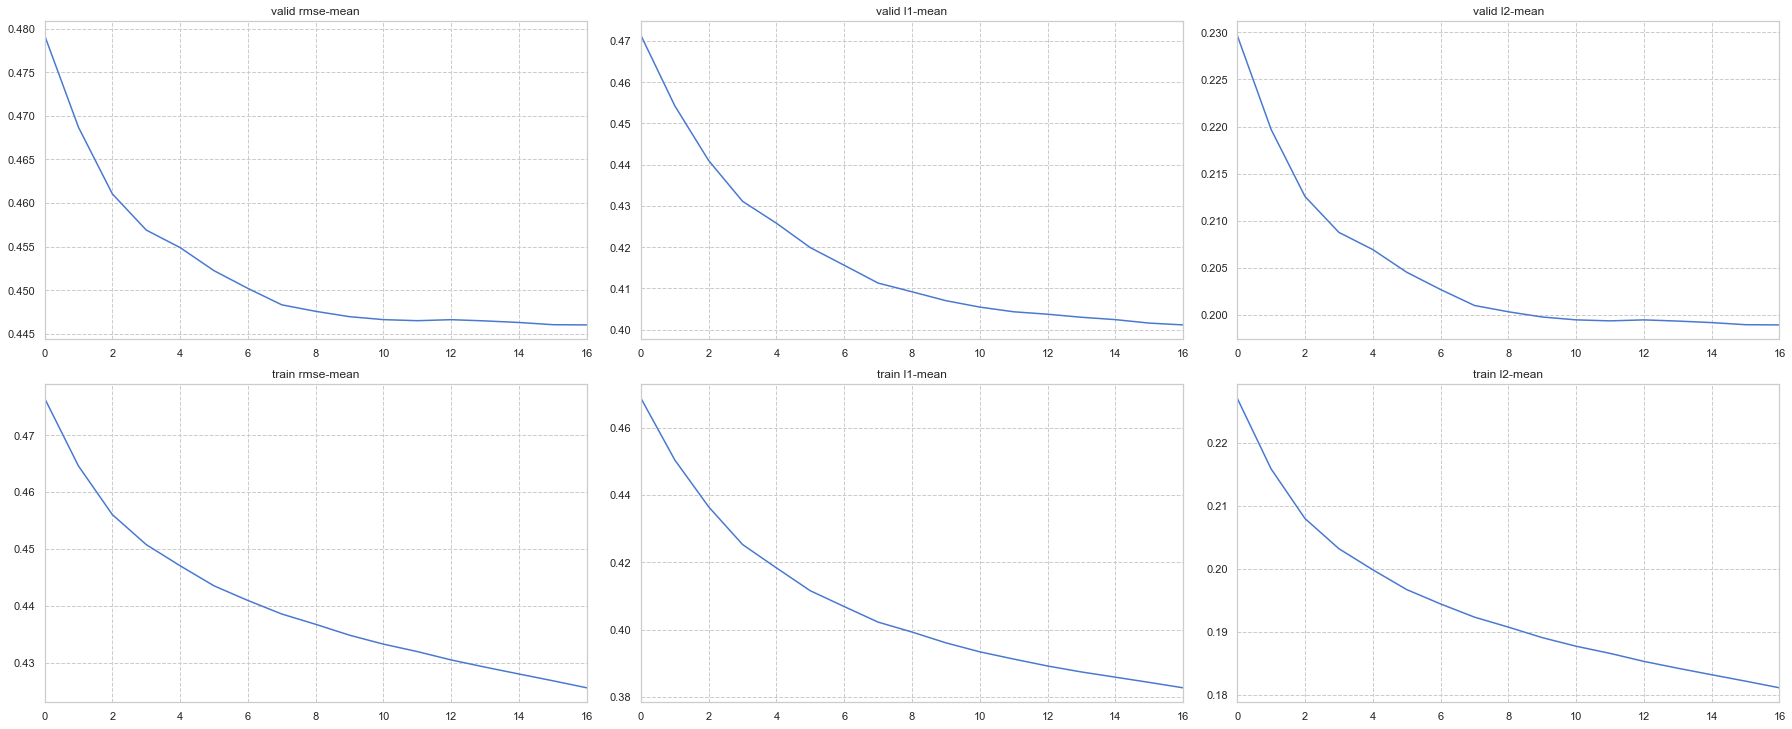


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('l2', 'rmse', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	

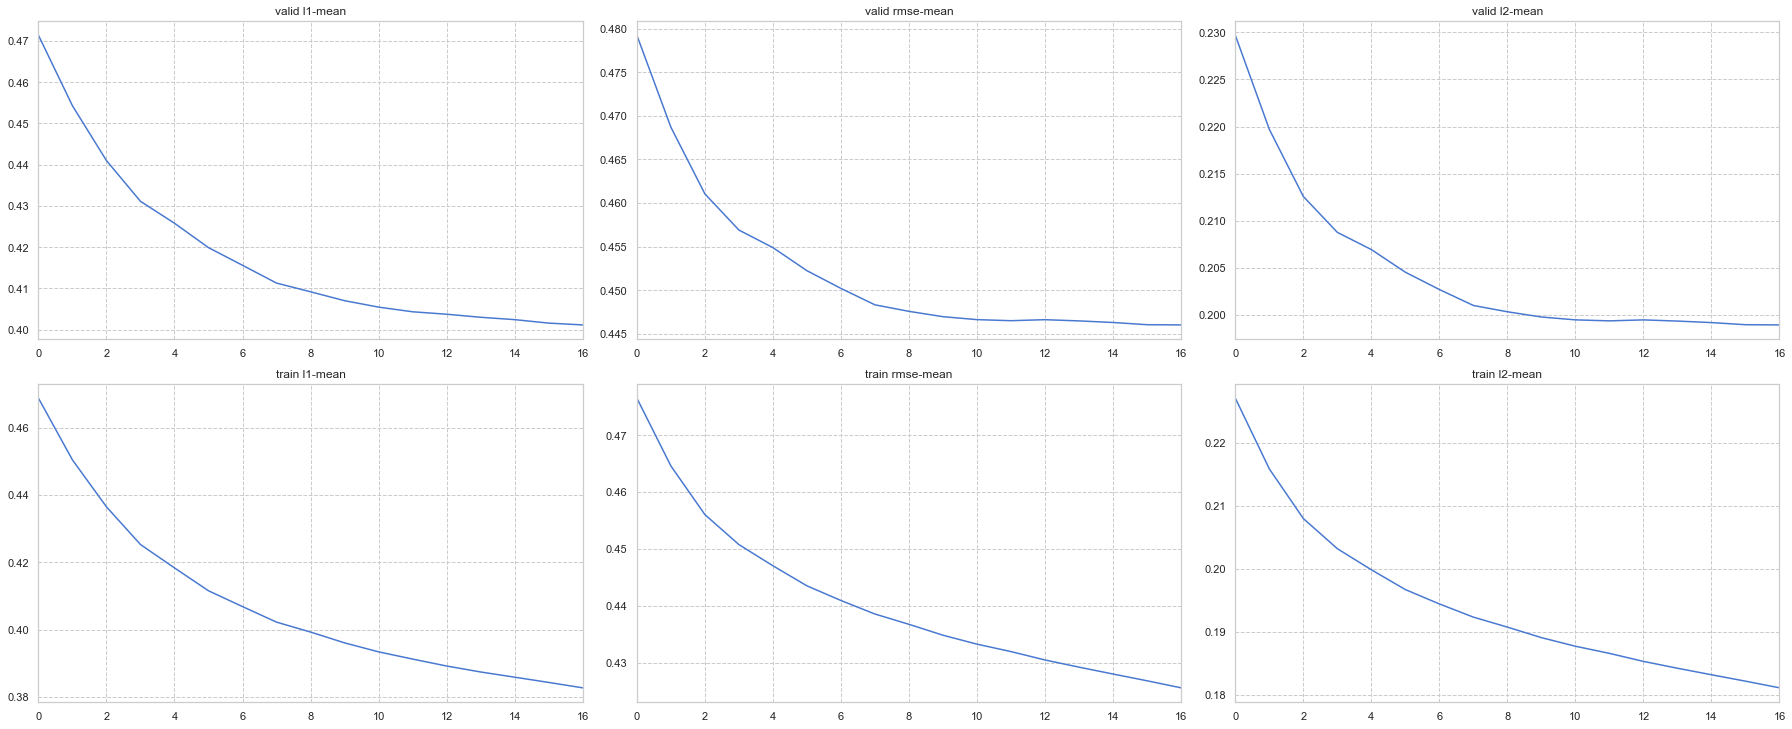


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('rmse', 'l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619

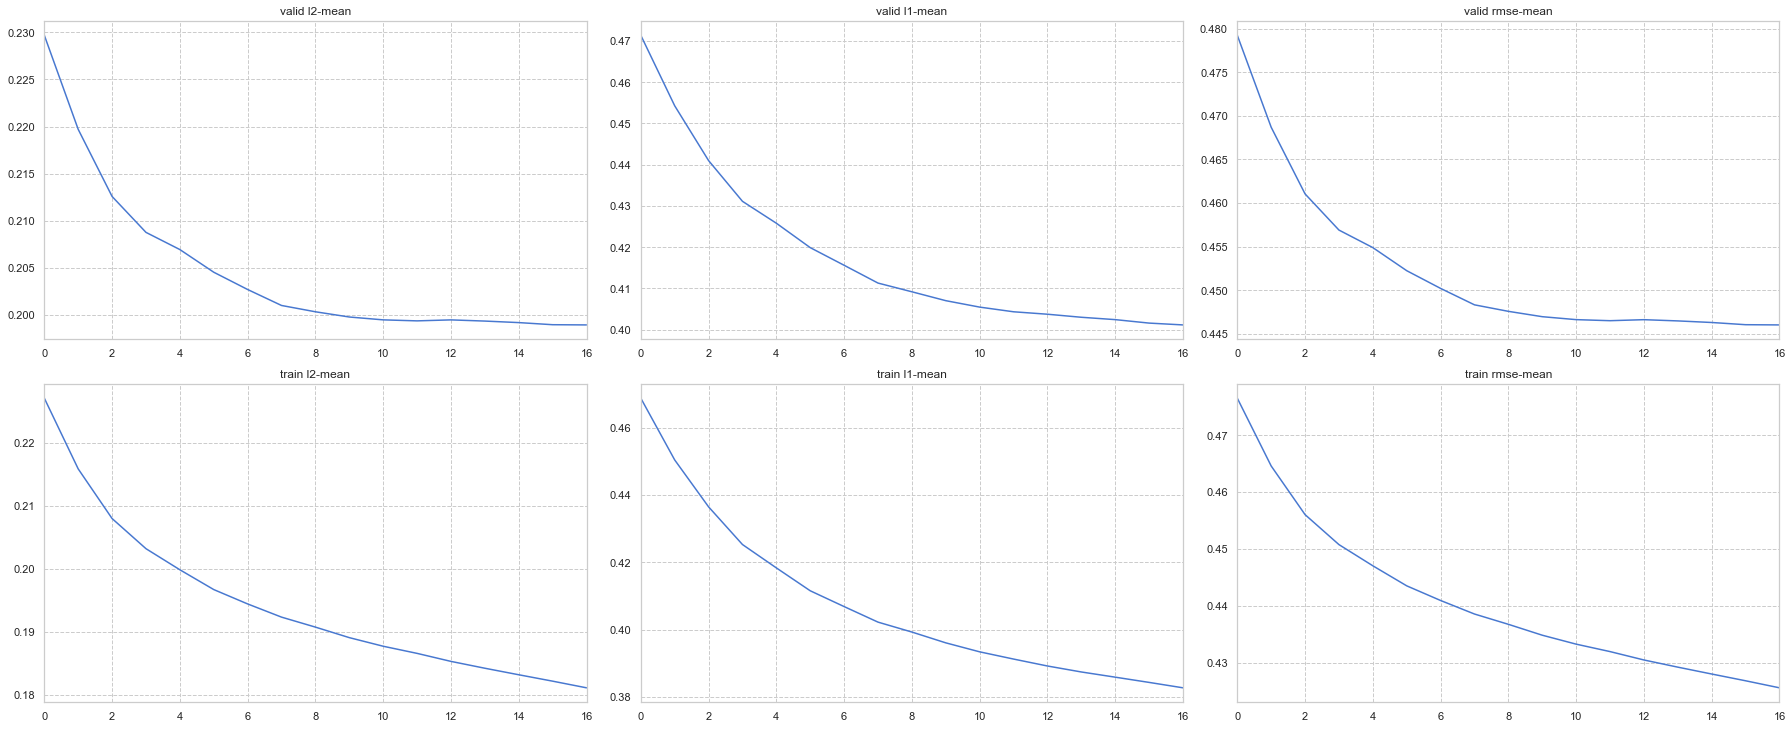


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('rmse', 'l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	

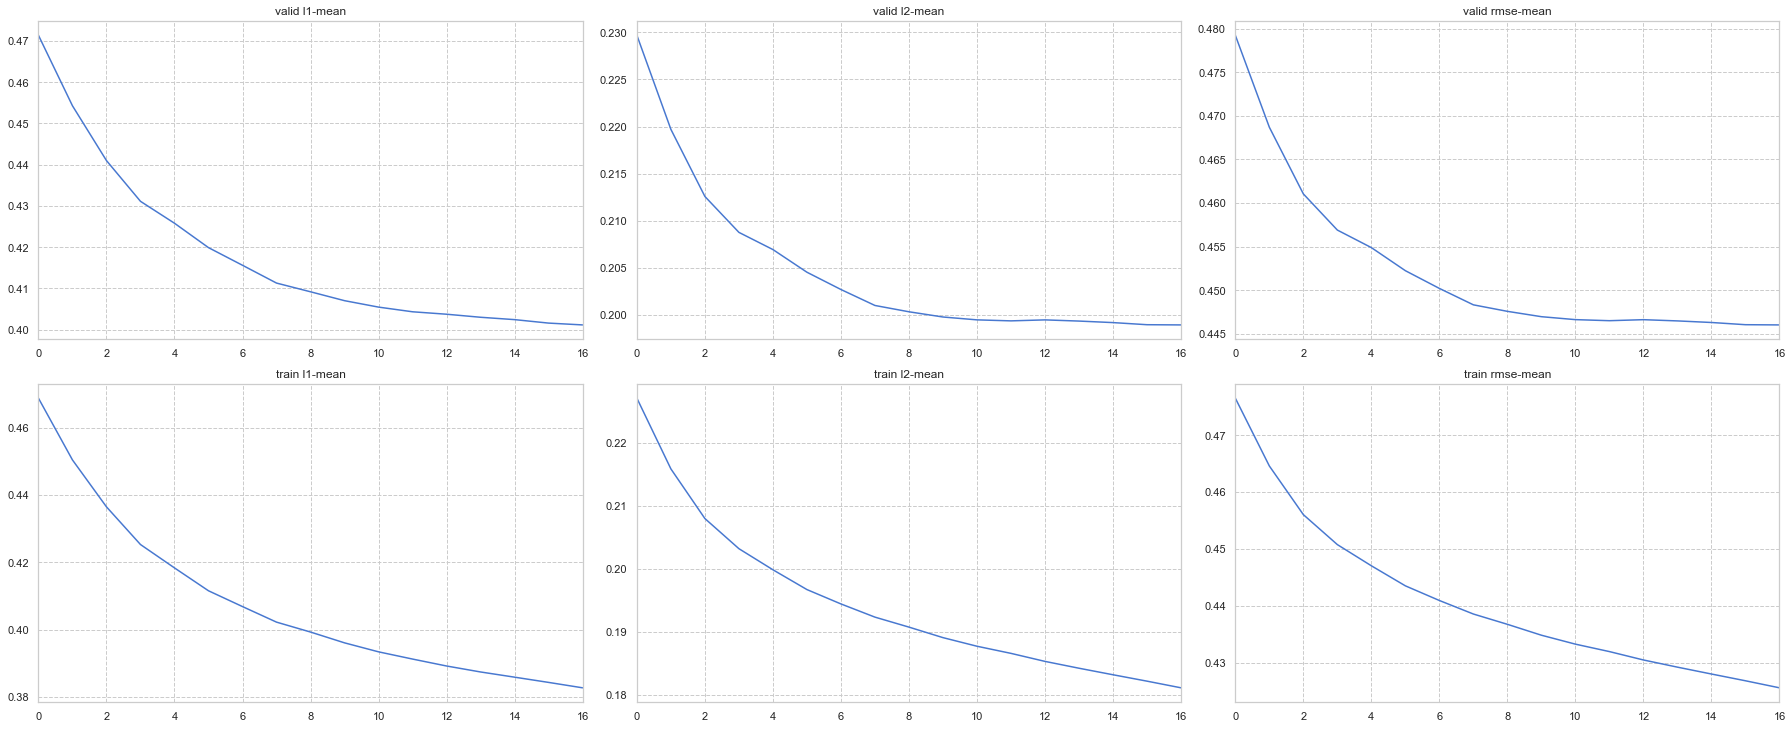


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


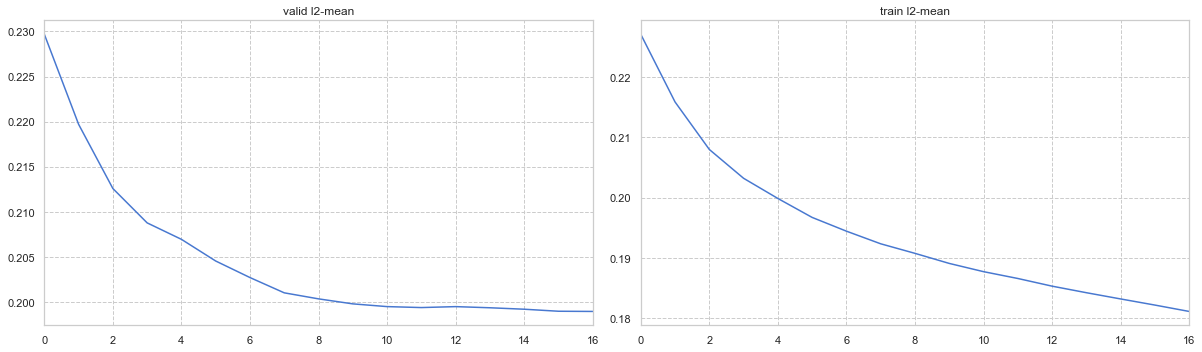


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


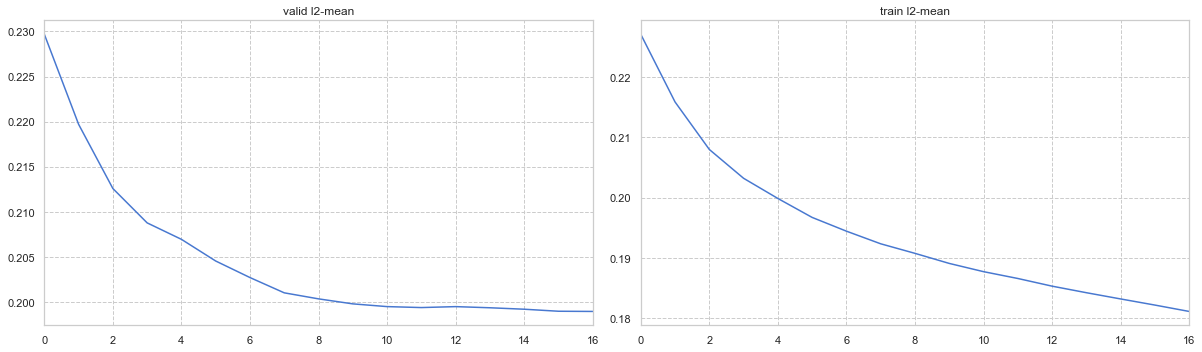


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'l1'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l1: 0.39735 + 0.00318484
Early stopping, best iteration is:
[68]	cv_agg's train l1: 0.330498 + 0.00213712	cv_agg's valid l1: 0.393031 + 0.00319347


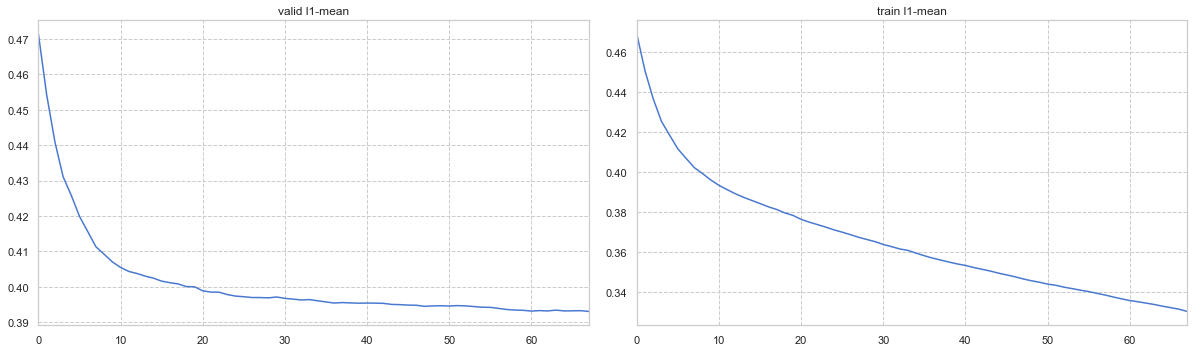


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'l2'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


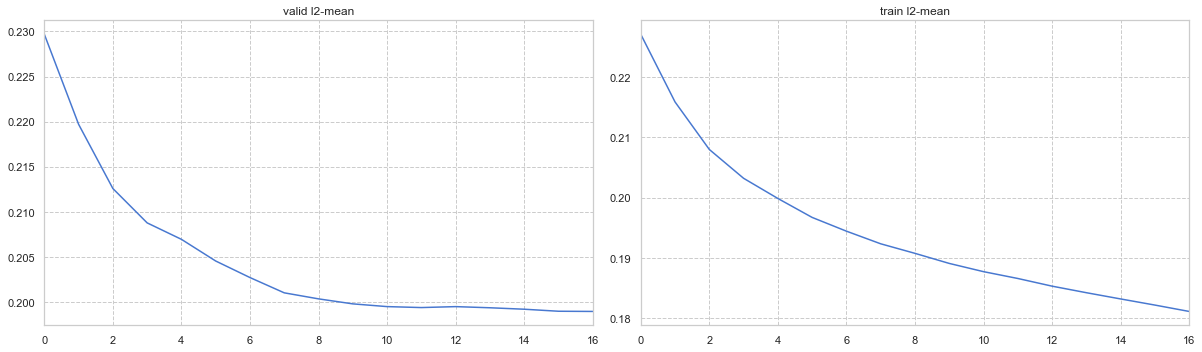


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'rmse'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102774	cv_agg's valid rmse: 0.446009 + 0.00448162


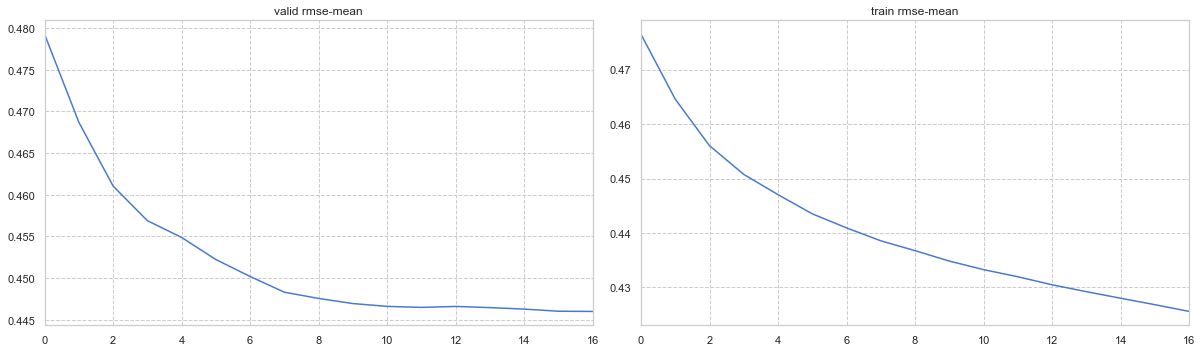


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l2: 0.122033 + 0.00108333	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l2: 0.213233 + 0.00281925	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l2: 0.110439 + 0.00116102	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l2: 0.216656 + 0.00209944	cv_agg's valid l1: 0.39735 + 0.00318484
Early

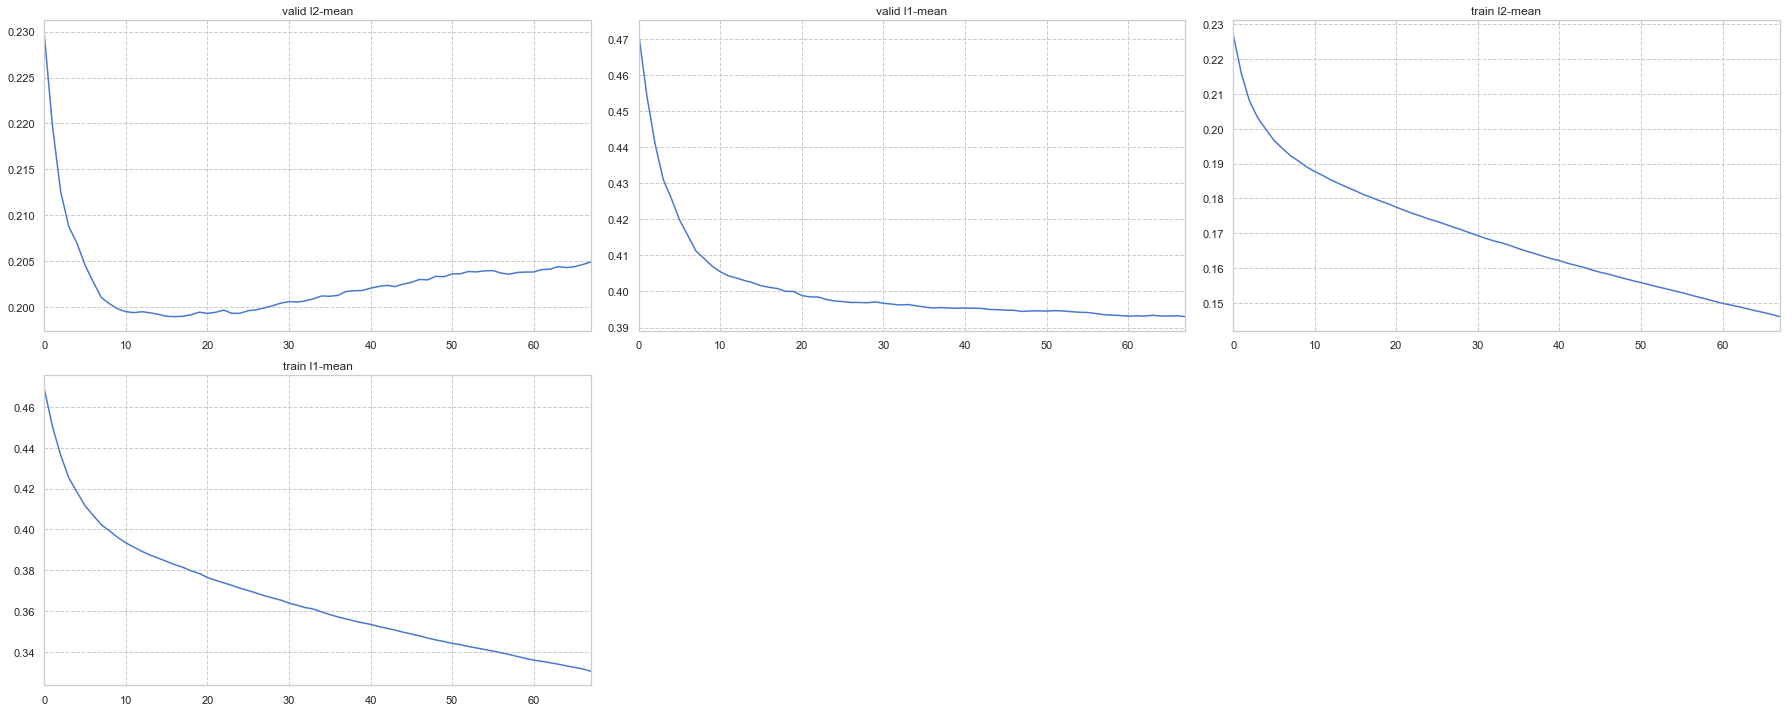


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l1: 0.401154 + 0.00478475	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


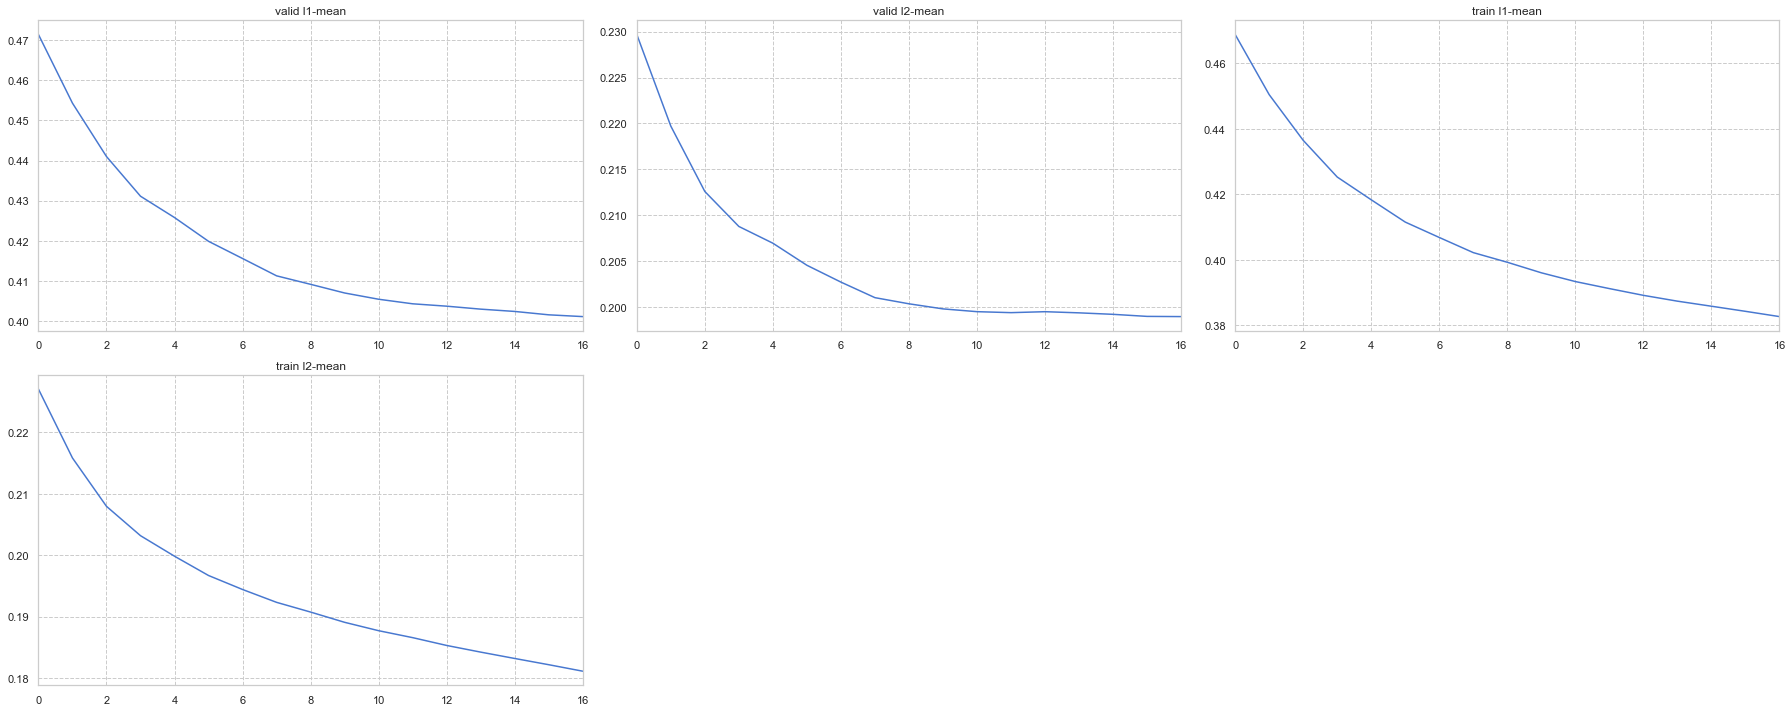


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l1', 'l2', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train rmse: 0.349329 + 0.00155094	cv_agg's train l2: 0.122033 + 0

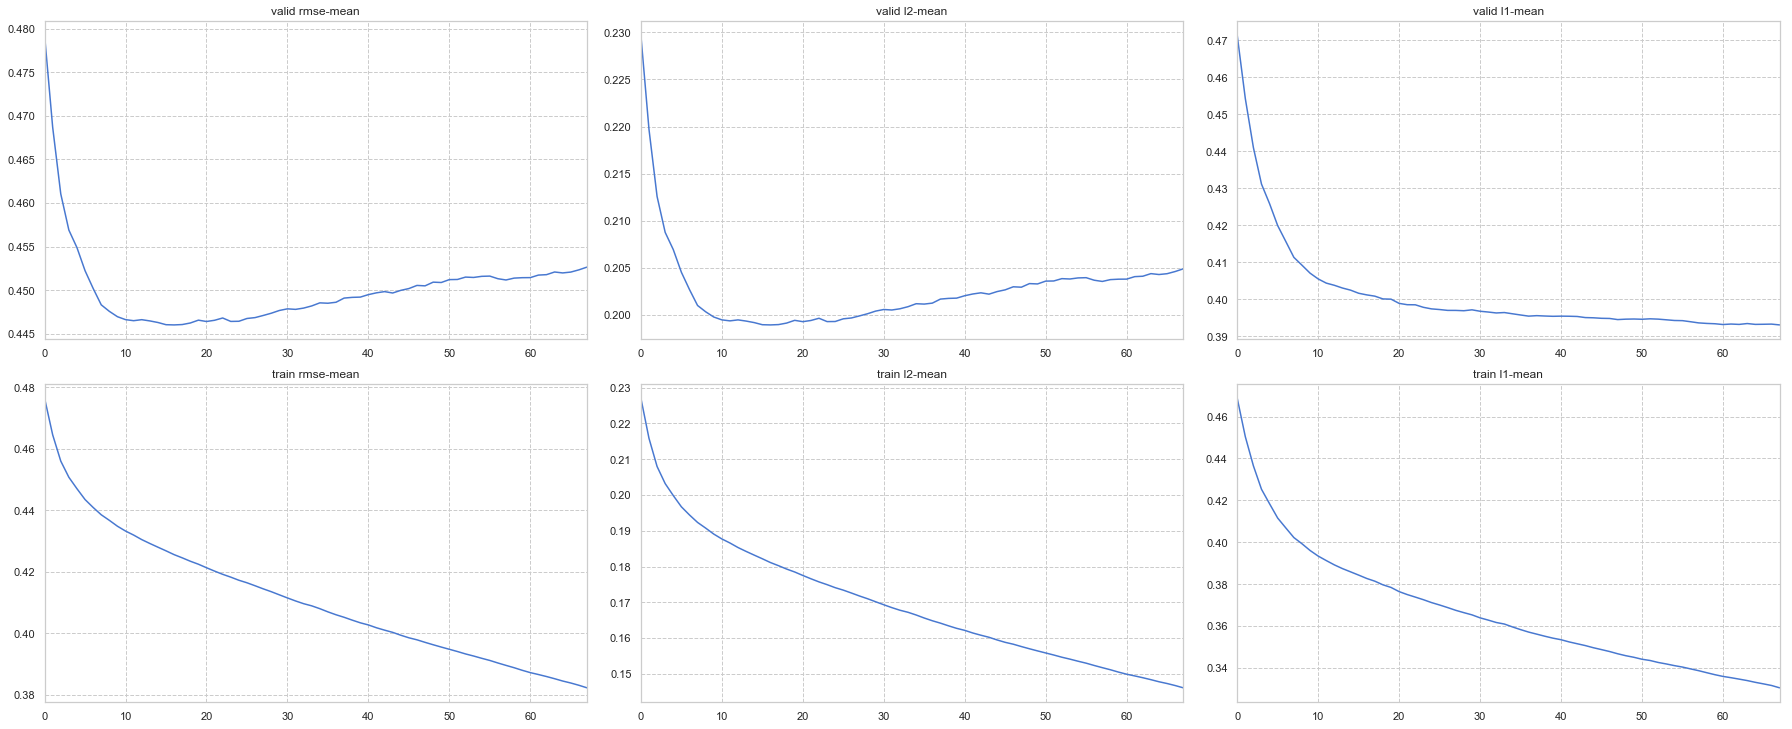


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l1', 'rmse', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l2: 0.122033 + 0.00108333	cv_agg's train rmse: 0.349329 + 0

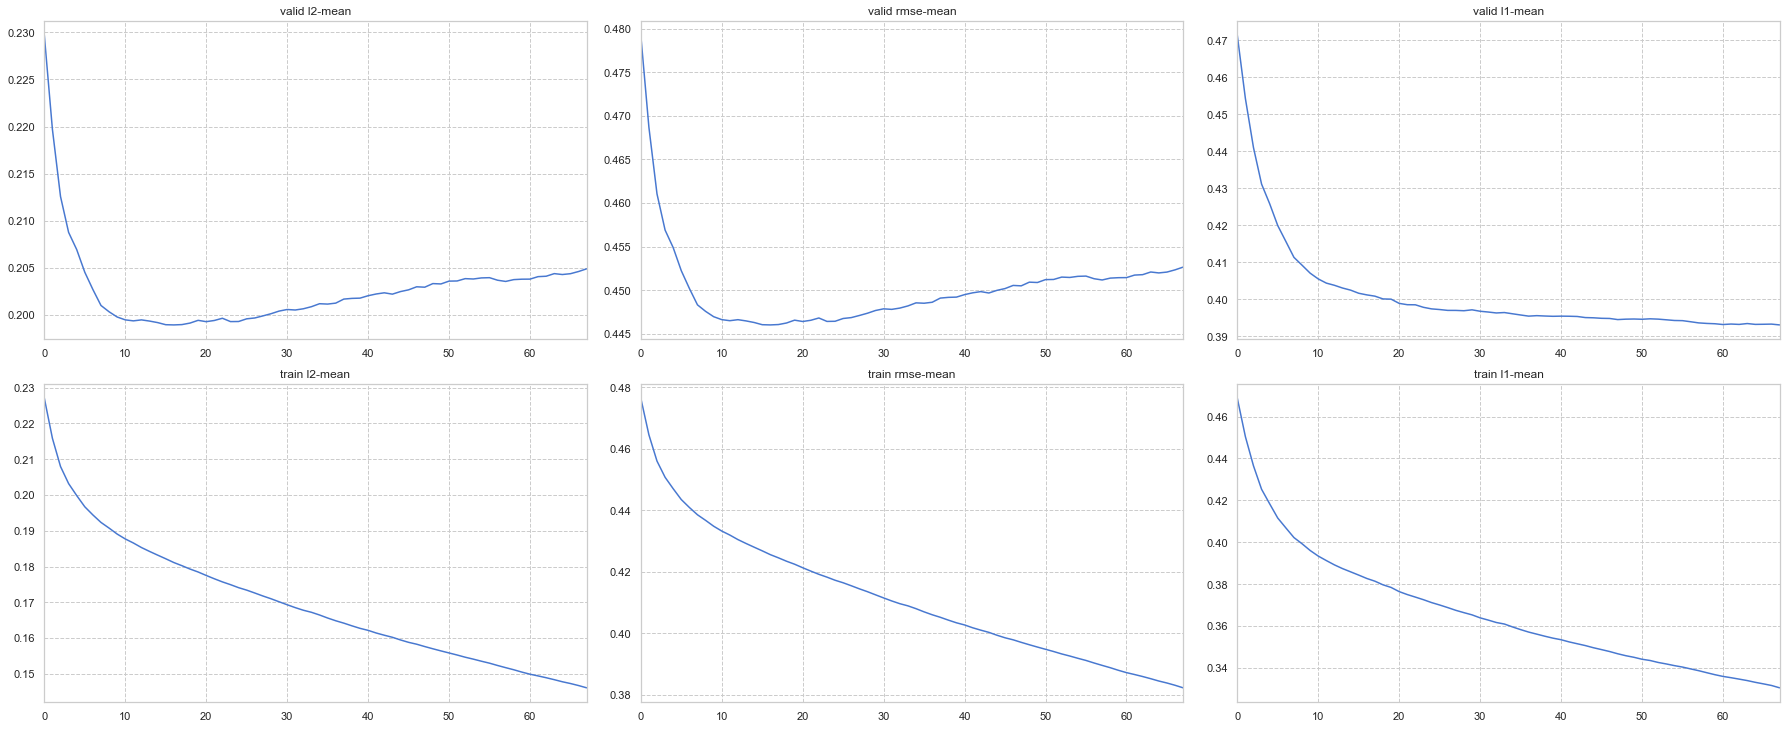


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l2', 'l1', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.001027

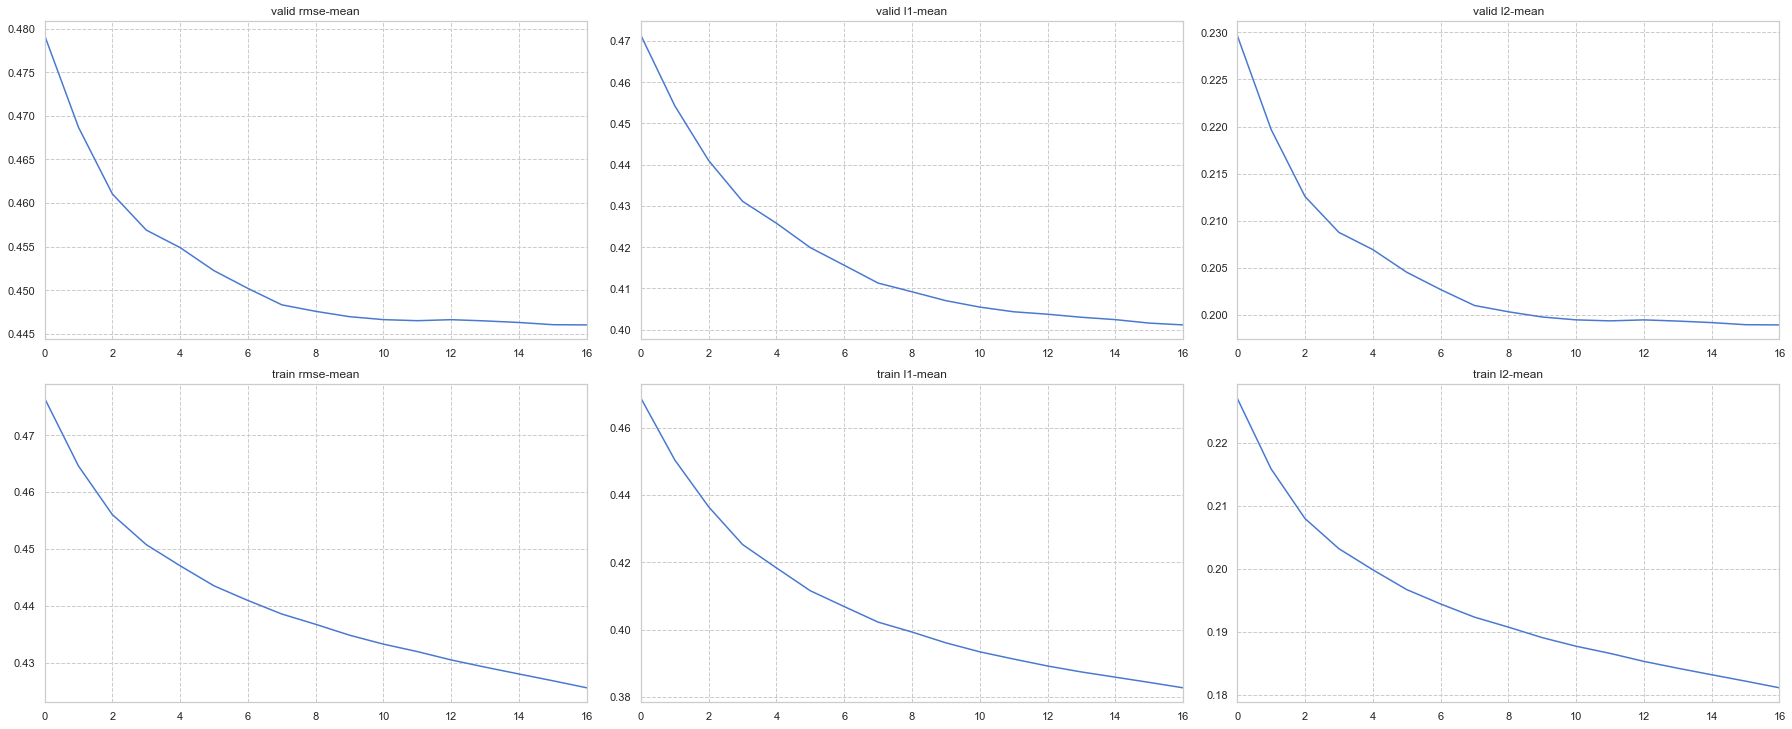


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('l2', 'rmse', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	

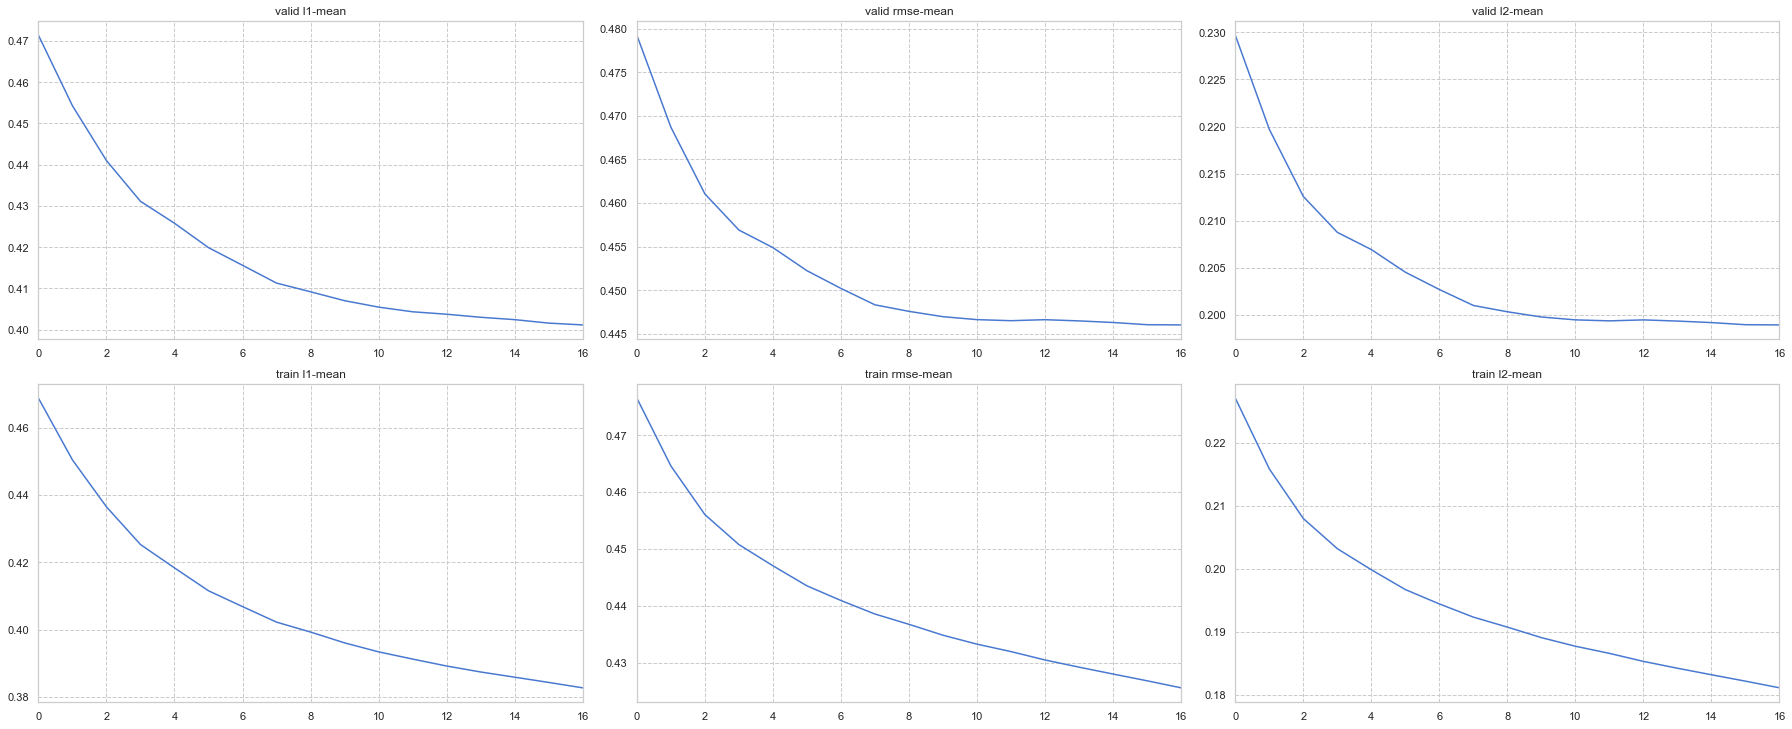


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('rmse', 'l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619

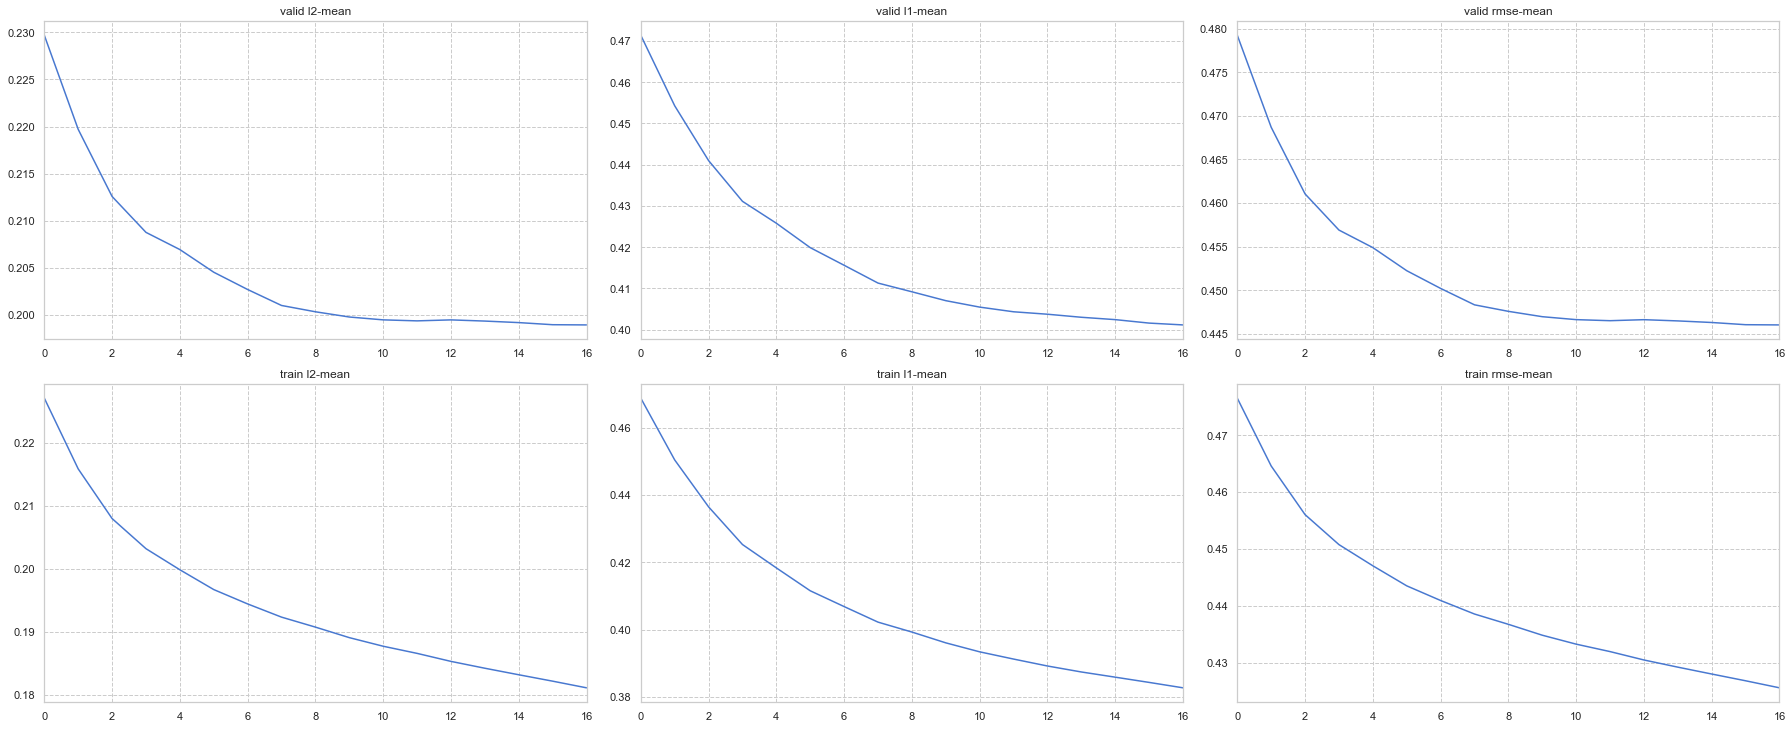


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ('rmse', 'l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	

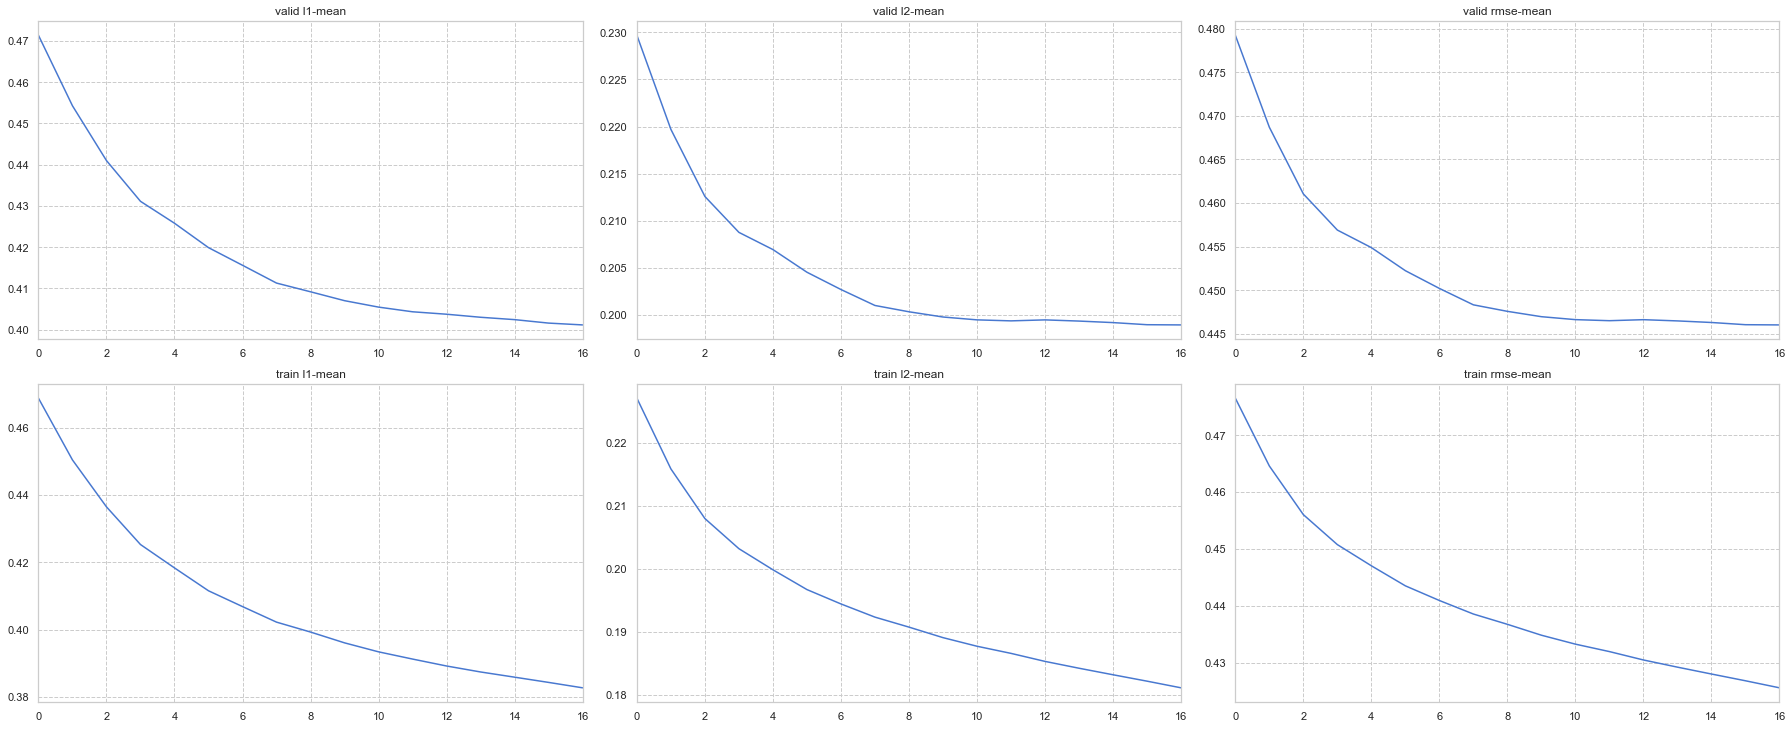


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


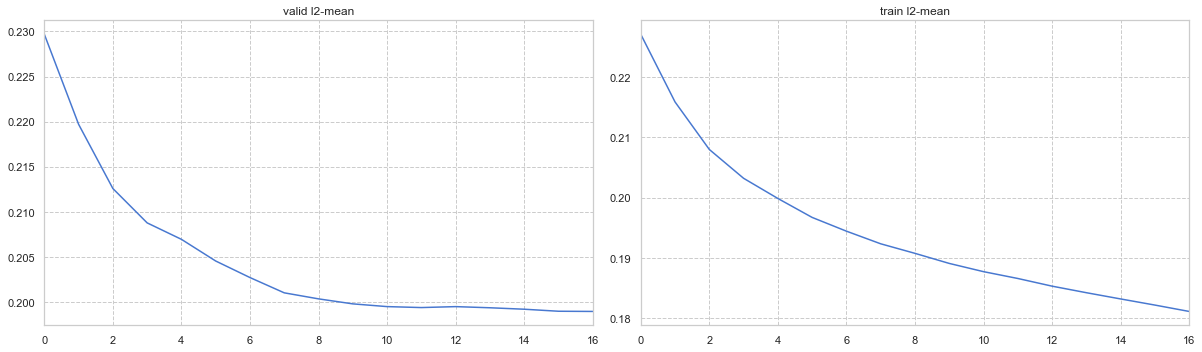


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'l1'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l1: 0.39735 + 0.00318484
Early stopping, best iteration is:
[68]	cv_agg's train l1: 0.330498 + 0.00213712	cv_agg's valid l1: 0.393031 + 0.00319347
metric_key:valid l1


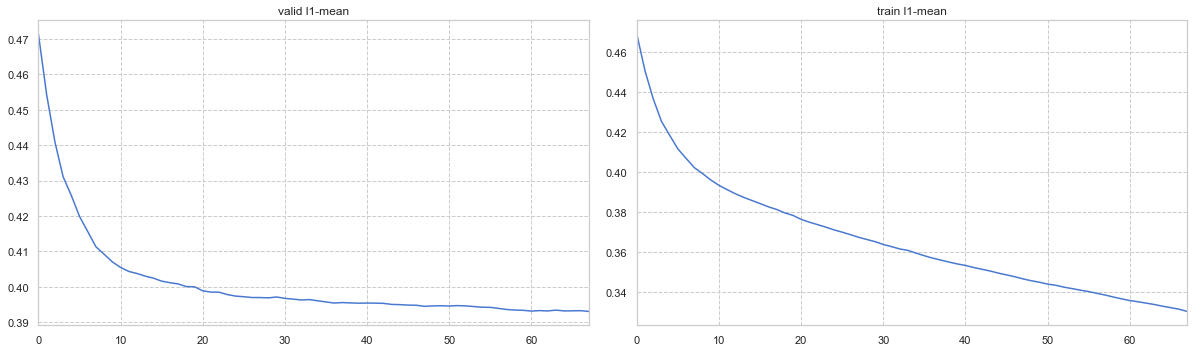


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'l2'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309
metric_key:valid l2


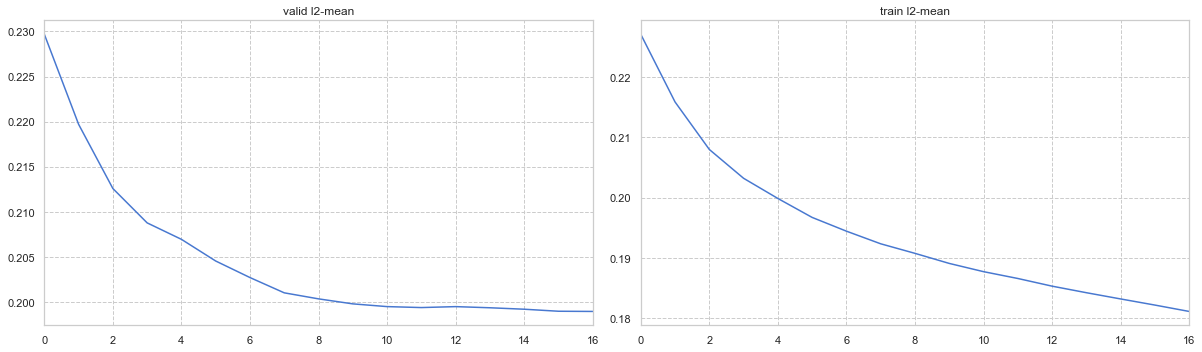


{'eval_train_metric': False, 'first_metric_only': True, 'metric_list': 'rmse'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102774	cv_agg's valid rmse: 0.446009 + 0.00448162
metric_key:valid rmse


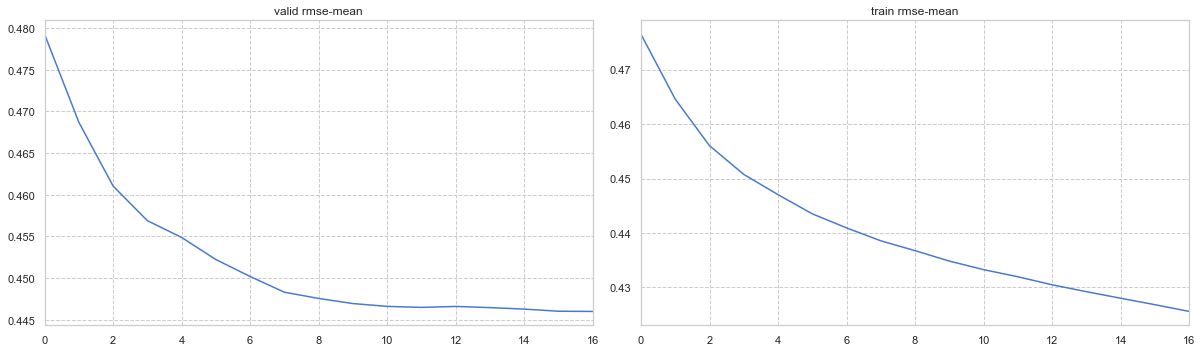


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's valid l2: 0.198944 + 0.00400309	cv_agg's valid l1: 0.401154 + 0.00478475


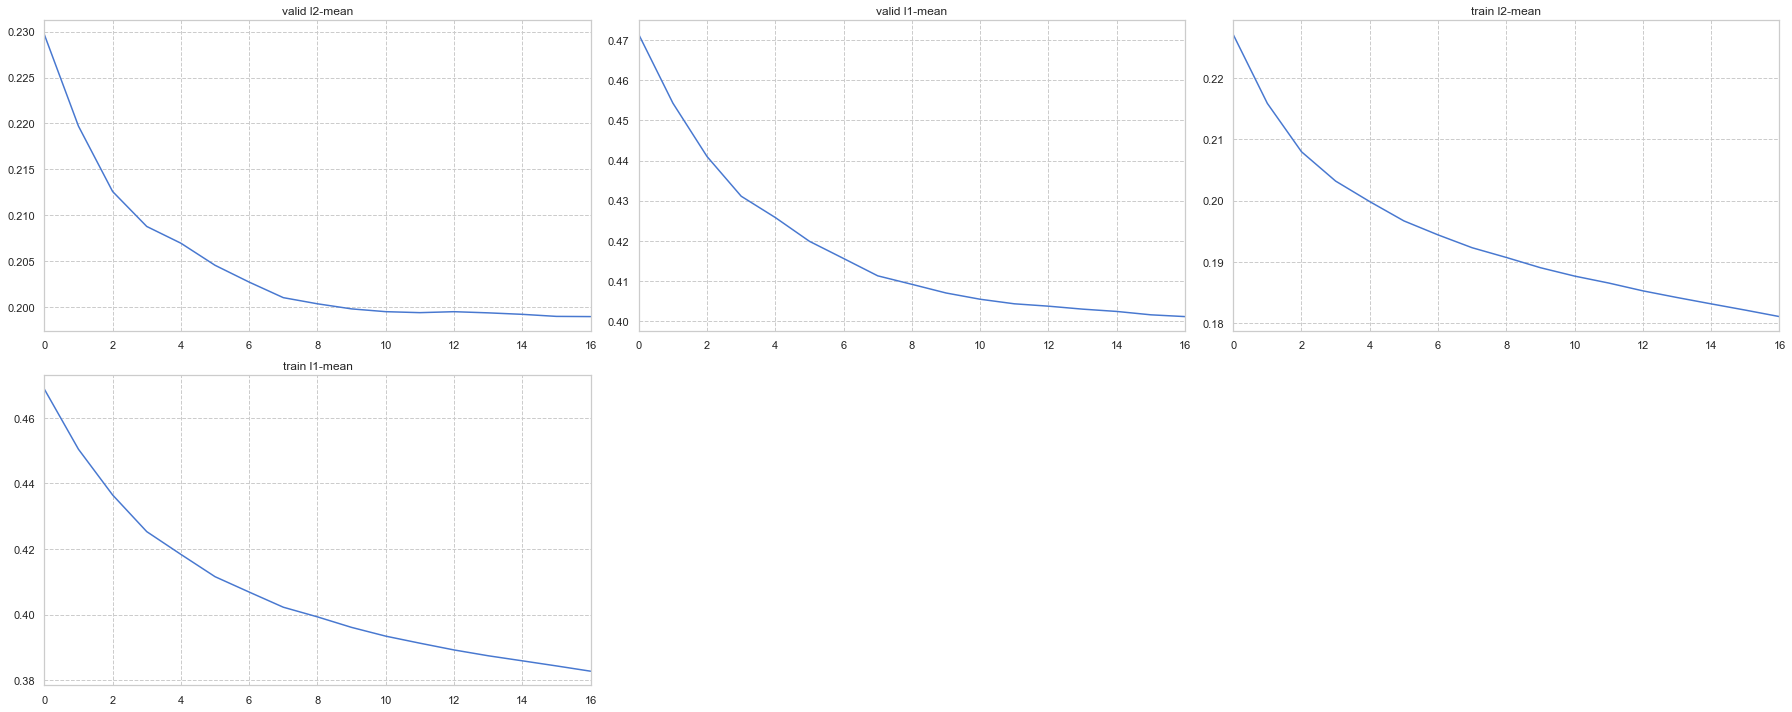


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l1: 0.401154 + 0.00478475	cv_agg's valid l2: 0.198944 + 0.00400309


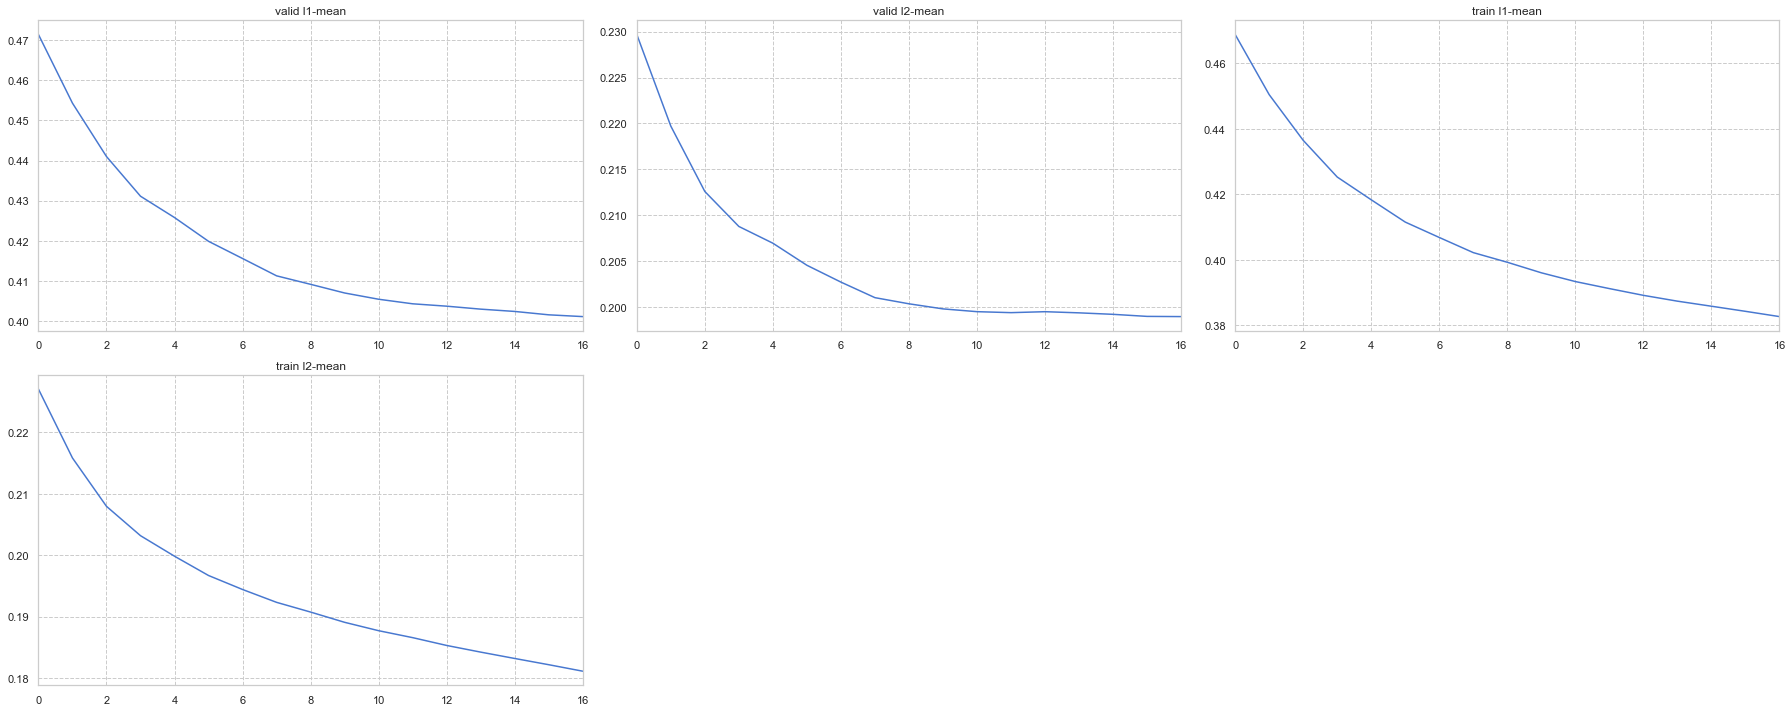


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l1', 'l2', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102

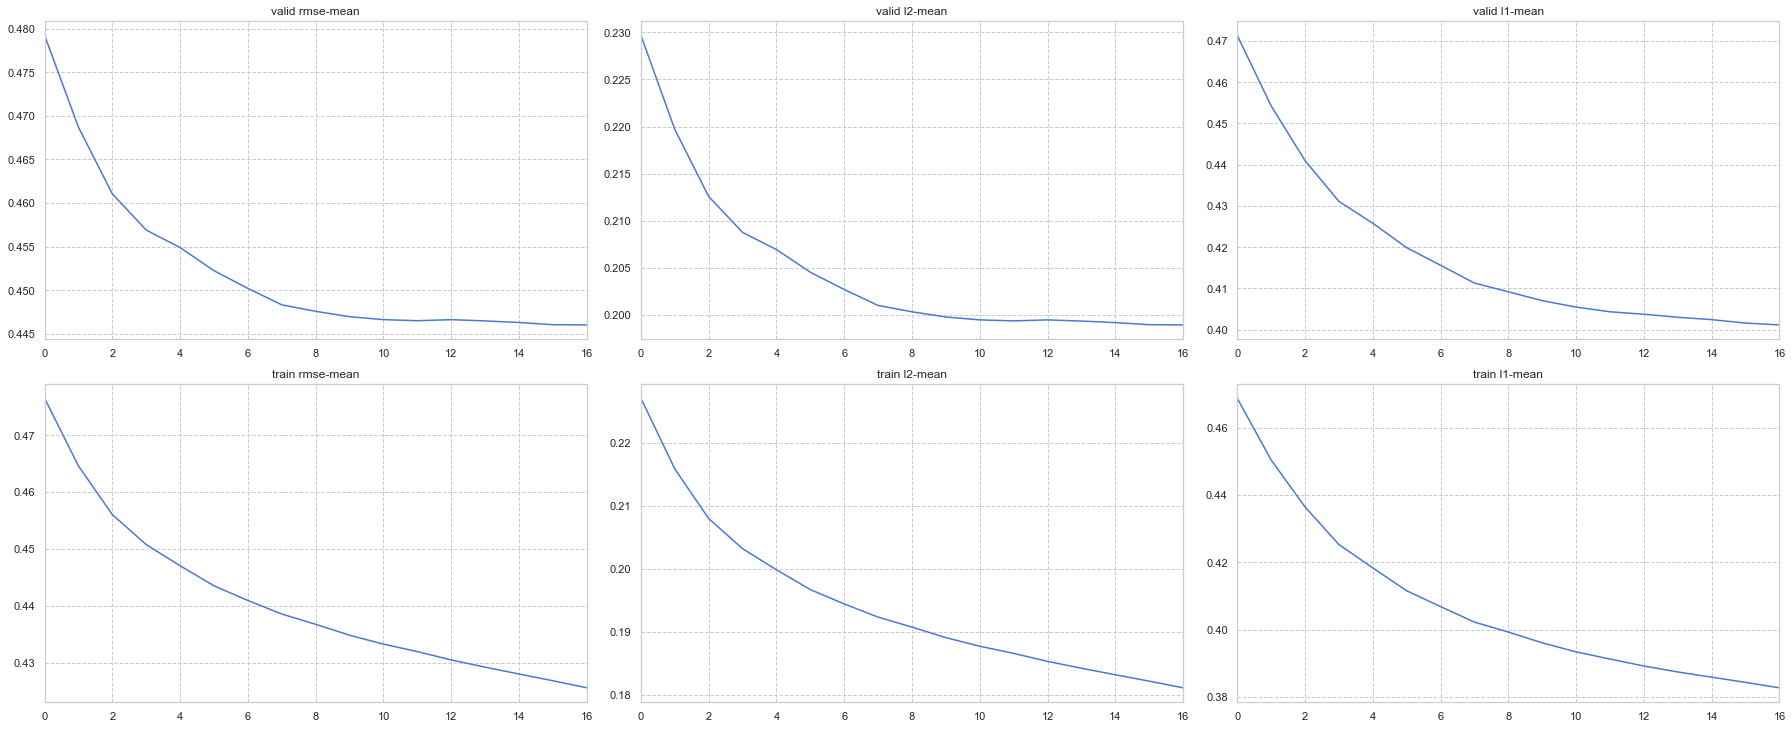


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l1', 'rmse', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.00087461

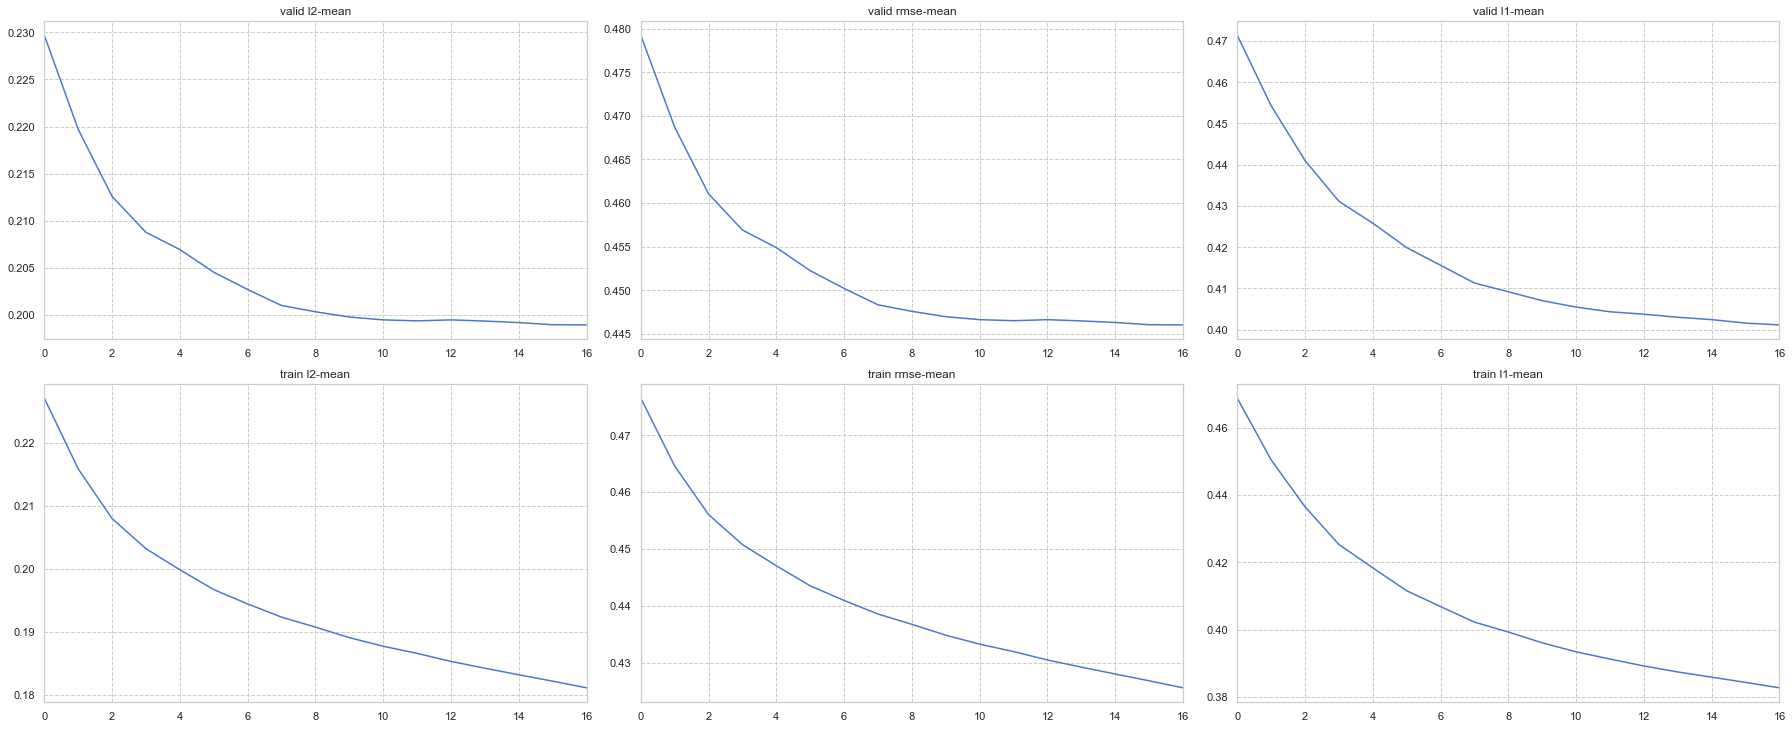


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l2', 'l1', 'rmse')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102

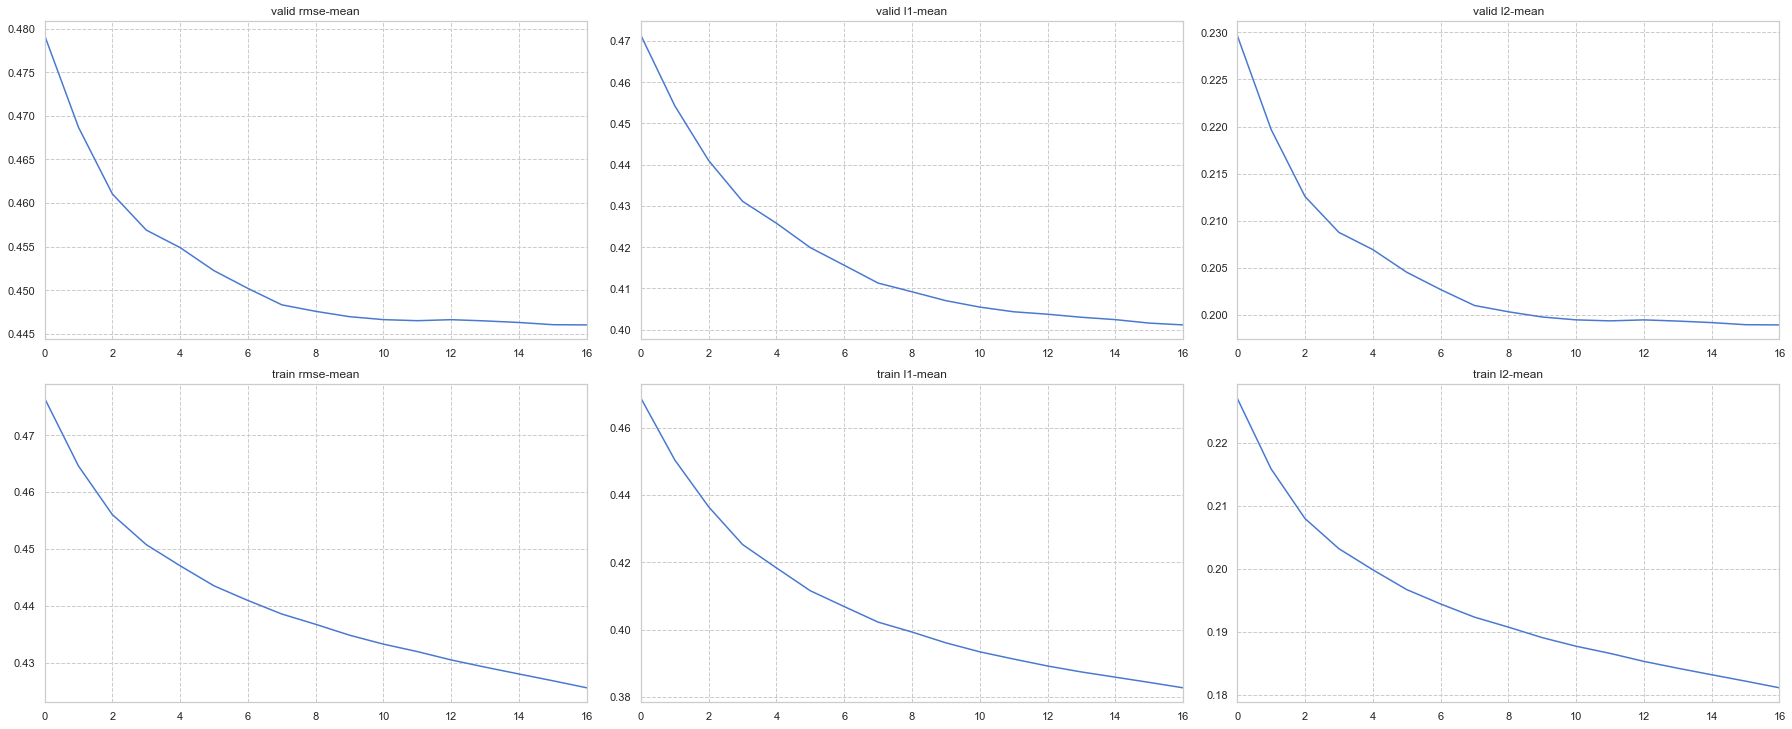


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('l2', 'rmse', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731

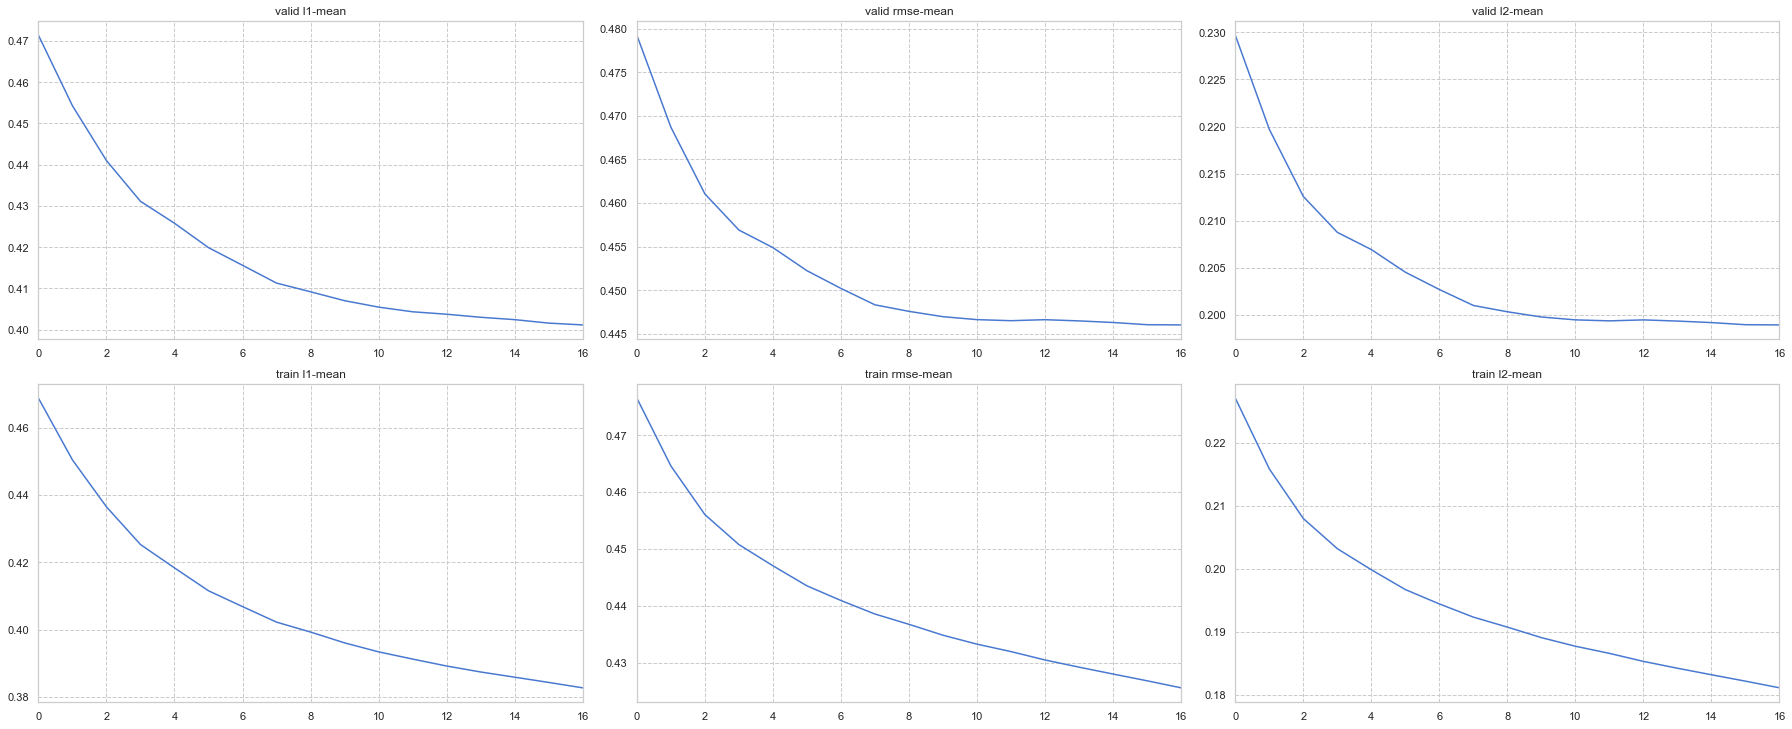


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('rmse', 'l1', 'l2')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.00087461

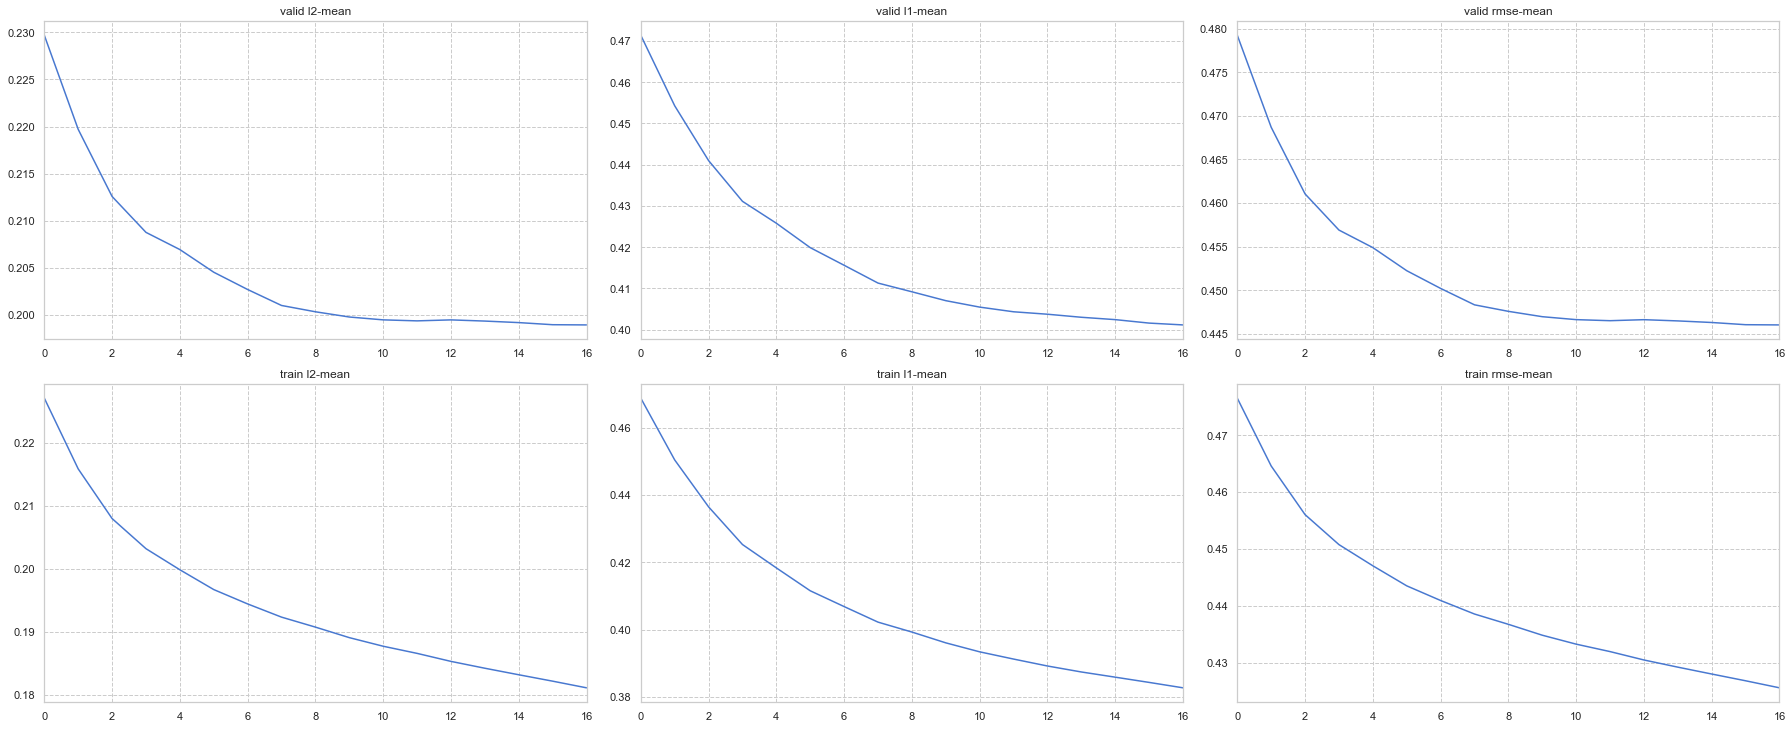


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ('rmse', 'l2', 'l1')}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid l1: 0.397114 + 0.00305829	cv_agg's valid l2: 0.200411 + 0.002401	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid l1: 0.393348 + 0.00251237	cv_agg's valid l2: 0.203798 + 0.00269383	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid l1: 0.394692 + 0.00291469	cv_agg's valid l2: 0.208915 + 0.00278042	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train l1: 0.38271 + 0.00180731

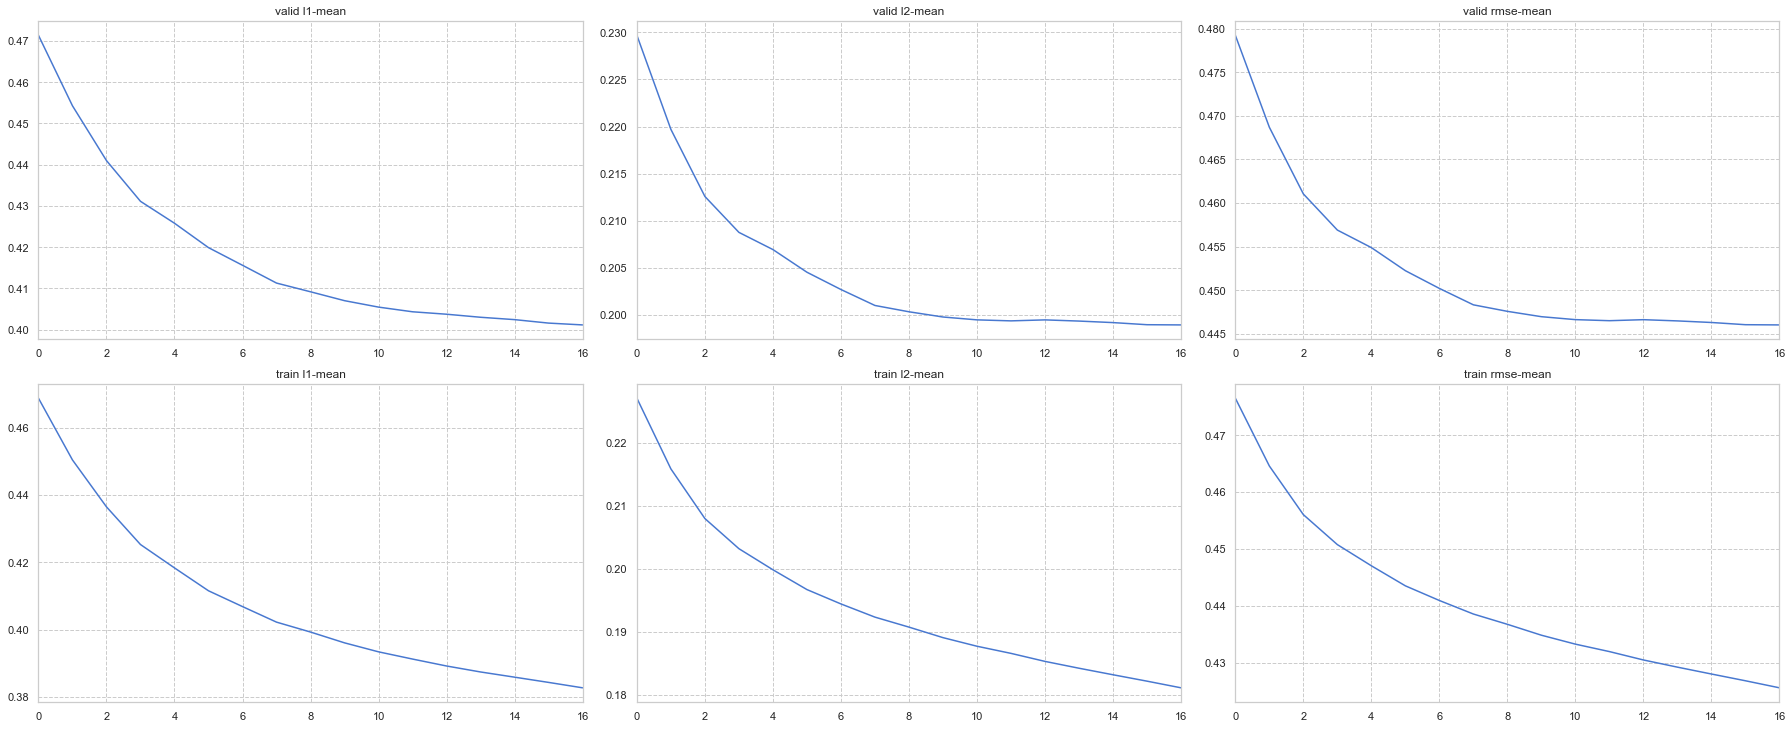


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


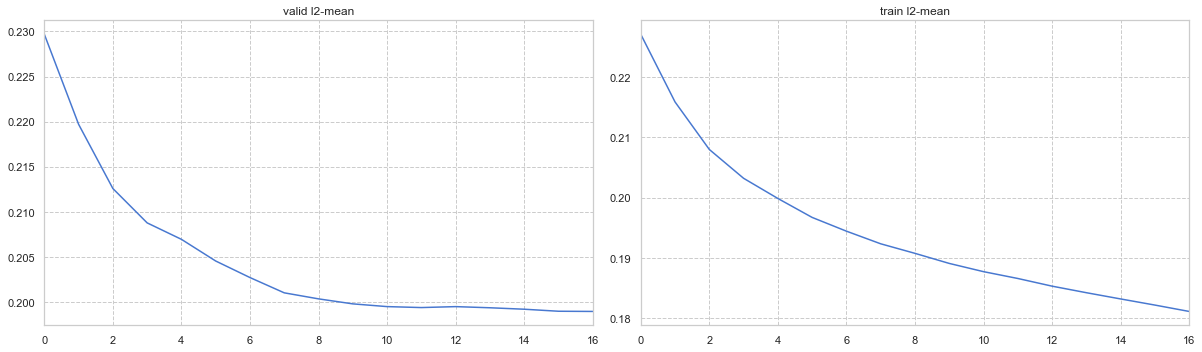


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


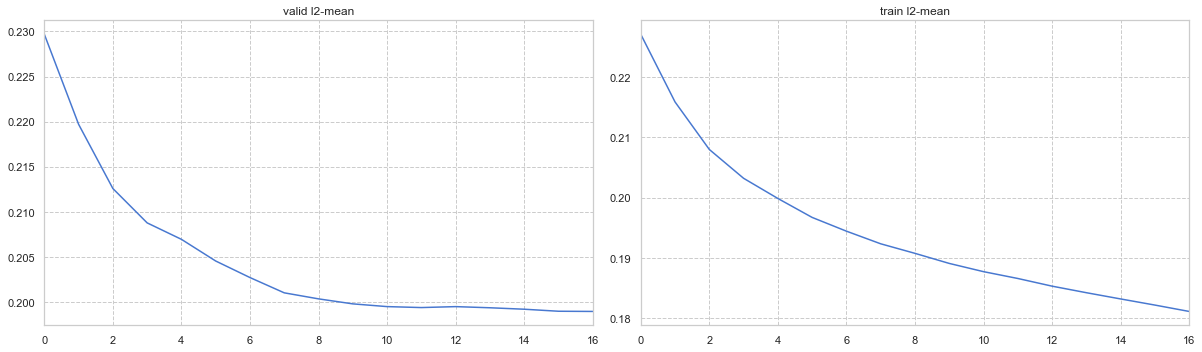


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'None'}

{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'l1'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-11-0c1aa0274f0d>", line 46, in regression_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[30]	cv_agg's train l1: 0.365335 + 0.00176749	cv_agg's valid l1: 0.397114 + 0.00305829
[60]	cv_agg's train l1: 0.336772 + 0.00186777	cv_agg's valid l1: 0.393348 + 0.00251237
[90]	cv_agg's train l1: 0.315529 + 0.00174053	cv_agg's valid l1: 0.394692 + 0.00291469
[120]	cv_agg's train l1: 0.296659 + 0.00196172	cv_agg's valid l1: 0.395996 + 0.00343599
[150]	cv_agg's train l1: 0.280029 + 0.00192059	cv_agg's valid l1: 0.39735 + 0.00318484
Early stopping, best iteration is:
[68]	cv_agg's train l1: 0.330498 + 0.00213712	cv_agg's valid l1: 0.393031 + 0.00319347


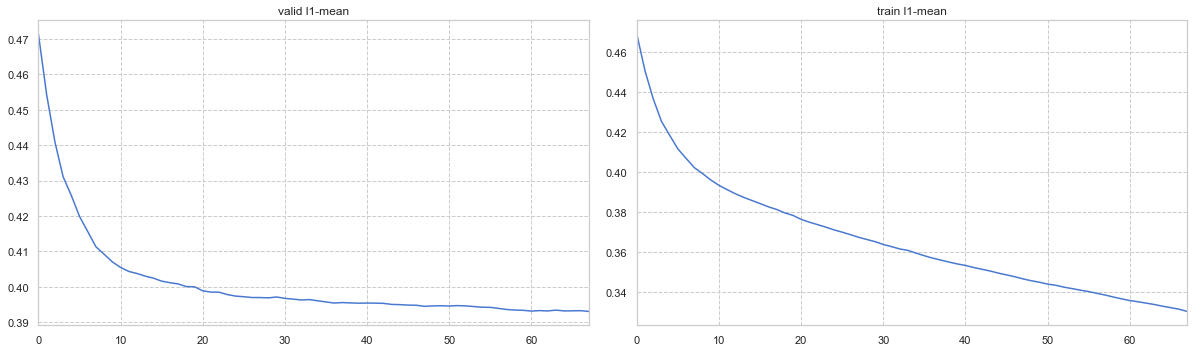


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'l2'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train l2: 0.170143 + 0.00111771	cv_agg's valid l2: 0.200411 + 0.002401
[60]	cv_agg's train l2: 0.150475 + 0.000866427	cv_agg's valid l2: 0.203798 + 0.00269383
[90]	cv_agg's train l2: 0.135389 + 0.000850166	cv_agg's valid l2: 0.208915 + 0.00278042
Early stopping, best iteration is:
[17]	cv_agg's train l2: 0.18111 + 0.000874619	cv_agg's valid l2: 0.198944 + 0.00400309


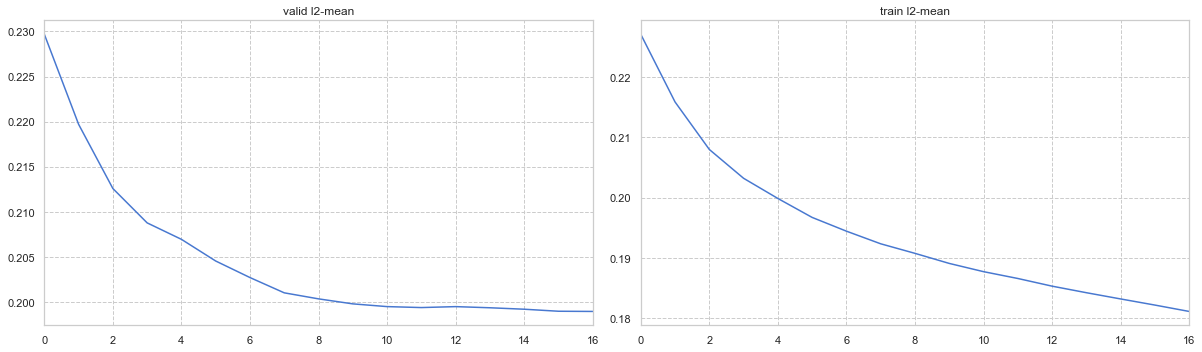


{'eval_train_metric': False, 'first_metric_only': False, 'metric_list': 'rmse'}
Training until validation scores don't improve for 100 rounds.
[30]	cv_agg's train rmse: 0.412481 + 0.00135635	cv_agg's valid rmse: 0.447665 + 0.0026799
[60]	cv_agg's train rmse: 0.387909 + 0.00111695	cv_agg's valid rmse: 0.45143 + 0.00297996
[90]	cv_agg's train rmse: 0.367951 + 0.00115597	cv_agg's valid rmse: 0.457062 + 0.00303972
Early stopping, best iteration is:
[17]	cv_agg's train rmse: 0.425569 + 0.00102774	cv_agg's valid rmse: 0.446009 + 0.00448162


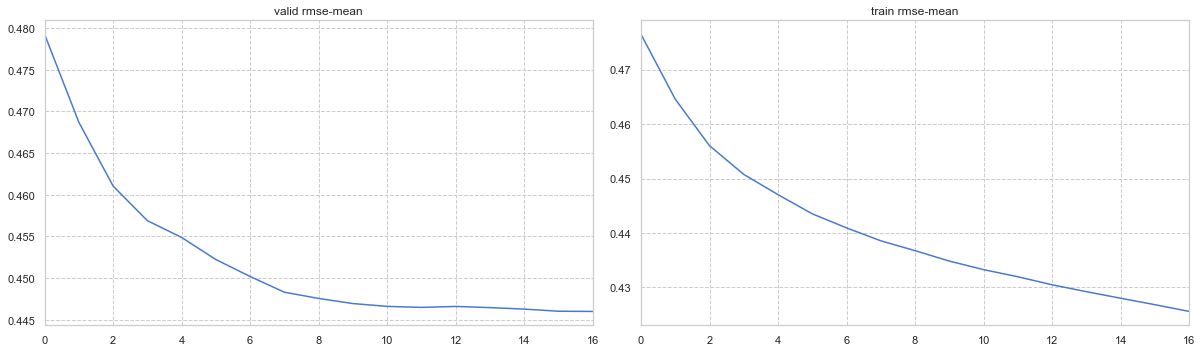

In [12]:
test_train(regression_train, 
           param_func=regression_params, 
           dataset=load_data_for_regression())

# sandbox

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss','auc', ],
    #'metric': ['auc', 'binary_logloss',],
    'num_leaves': 8,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

res_dict = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=100, first_metric_only=True, verbose=True),
    #lgb.record_evaluation(res_dict)
]

# Training settings
FOLD_NUM = 5
fold_seed = 71
folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)

# Fitting
ret = lgb.cv(params=params,
               train_set=lgb_train,
               folds=folds,
               num_boost_round=5000,
               verbose_eval = 10,
               callbacks=callbacks, 
               eval_train_metric=True,
               # return_boosters=True
               )

#print(f"best_iteration : {model.best_iteration}")
df_ret = pd.DataFrame(ret)
df_ret.tail()

oof = model.get_oof_prediction()
print(f"roc_auc_score on oof preds: {roc_auc_score(lgb_train.label, oof)}")

test_preds_list = model.predict(X_test, num_iteration=model.best_iteration)
test_preds_avg = np.array(test_preds_list).mean(axis=0)

print(f"roc_auc_score on oof preds: {roc_auc_score(y_test, test_preds_avg)}")

In [ ]:
rd.seed(123)

# Loading Iris Dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split dataset for this demonstration.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                shuffle=True,
                                                random_state=42)

# one hot representation of y_train
max_class_num = y_train.max()+1
y_train_ohe = np.identity(max_class_num)[y_train]
    
# Create LightGBM dataset for train.
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

# LightGBM parameter
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric' : ["multi_logloss", "multi_error", ],
    'num_class': 3,
    'verbosity' : -1,
}
callbacks = [
    lgb.early_stopping(stopping_rounds=100, first_metric_only=False, verbose=True),
]

# Training settings
FOLD_NUM = 5
fold_seed = 71
folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
eval_train_metric=True
# # Fitting
ret, model = lgb.cv(params=params,
               train_set=lgb_train,
               folds=folds,
               num_boost_round=1000,
               verbose_eval = 30,
               callbacks=callbacks, 
               eval_train_metric=eval_train_metric,
               return_boosters=True
               )

print(f"best_iteration : {model.best_iteration}")
df_ret = pd.DataFrame(ret)
df_ret.tail()

In [ ]:
oof = model.get_oof_prediction()

print(f"accuracy on oof preds: {accuracy_score(lgb_train.label, np.argmax(oof, axis=1))}")

test_preds_list = model.predict(X_test, num_iteration=model.best_iteration)
test_preds_avg = np.array(test_preds_list).mean(axis=0)
test_preds = np.argmax(test_preds_avg, axis=1)

print(f"accuracy on oof preds: {accuracy_score(y_test, test_preds)}")

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}

callbacks = [
    lgb.early_stopping(stopping_rounds=100, first_metric_only=False, verbose=True),
]

# Training settings
FOLD_NUM = 5
fold_seed = 71
folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
eval_train_metric=True
# # Fitting
ret, model = lgb.cv(params=params,
               train_set=lgb_train,
               folds=folds,
               num_boost_round=5000,
               verbose_eval = 200,
               callbacks=callbacks, 
               eval_train_metric=eval_train_metric,
               return_boosters=True
               )
print(f"best_iteration : {model.best_iteration}")

df_ret = pd.DataFrame(ret)
df_ret.tail()

In [ ]:
oof = model.get_oof_prediction()
print(f"mae: {mean_absolute_error(y_train, oof):.5f}")
test_preds_list = model.predict(X_test, num_iteration=model.best_iteration)
test_preds_avg = np.array(test_preds_list).mean(axis=0)

In [ ]:
num_boost_round = 300
pg = classification_params()
for p in pg:
    print("="*100, flush=True)
    print("="*100, flush=True)
    print(p, flush=True)
    try:
        df_ret = classification_train(metric_list=p["metric_list"], 
                             eval_train_metric=p["eval_train_metric"], 
                             first_metric_only=p["first_metric_only"],
                             num_boost_round=num_boost_round)
        draw_metric_graph(df_ret)
        if df_ret.shape[0]==num_boost_round:
            raise Exception("early_stopping was not applied.")
    except Exception as e:
        traceback.print_exc()
        
    print("", flush=True)
    # break

In [ ]:
num_boost_round = 300
for p in pg:
    print("="*100, flush=True)
    print("="*100, flush=True)
    print(p, flush=True)
    try:
        df_ret = multi_label_classification_train(metric_list=p["metric_list"], 
                             eval_train_metric=p["eval_train_metric"], 
                             first_metric_only=p["first_metric_only"],
                             num_boost_round=num_boost_round)
        draw_metric_graph(df_ret)
        if df_ret.shape[0]==num_boost_round:
            raise Exception("early_stopping was not applied.")
    except Exception as e:
        traceback.print_exc()
        
    print("", flush=True)
    # break

In [ ]:
num_boost_round = 300
for p in pg:
    print("="*100, flush=True)
    print("="*100, flush=True)
    print(p, flush=True)
    try:
        df_ret = regression_train(metric_list=p["metric_list"], 
                             eval_train_metric=p["eval_train_metric"], 
                             first_metric_only=p["first_metric_only"],
                             num_boost_round=num_boost_round)
        draw_metric_graph(df_ret)
        if df_ret.shape[0]==num_boost_round:
            raise Exception("early_stopping was not applied.")
    except Exception as e:
        traceback.print_exc()
        
    print("", flush=True)
    # break